In [14]:
import os
import json
import re
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker

from skimage.io import imread, imsave
from skimage.transform import warp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks
import scipy.stats as stats
from scipy.integrate import odeint, solve_ivp
from numba import njit, prange
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter1d
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score

In [2]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [3]:
def gompertz(t, A, mu, l):
    log_B = A * np.exp(-np.exp(mu * np.exp(1) / A * (l - t) + 1))
    return log_B

In [4]:
def gompertz_growth_rate(t, A, mu, l):
    gr = mu * np.exp(np.exp(1) * mu * (l - t) / A - np.exp(np.exp(1) * mu * (l - t) / A + 1) + 2)
    return gr

In [5]:
def tm_gomp(A, mu, l):
    return A / (mu * np.e) + l

In [6]:
def logistic(t, A, mu, l):
    log_B = A / (1 + np.exp(4 * mu / A * (l - t) + 2))
    return log_B

In [7]:
def logistic_growth_rate(t, A, mu, l):
    gr = 4 * mu * np.exp(4 * mu / A * (l - t) + 2) / (1 + np.exp(4 * mu / A * (l - t) + 2))**2
    return gr

In [8]:
def tm_logistic(A, mu, l):
    return A / (2 * mu) + l

### Gompertz and Logistic fit

#### $\mu m$

In [11]:
df = pd.read_excel('../data_processed.xlsx')

4
Gompertz Model:
  SSR: 0.3235
  R²: 0.9946
  AIC: -1398.8392
  BIC: -1388.7134

Logistic Model:
  SSR: 0.2520
  R²: 0.9958
  AIC: -1452.7677
  BIC: -1442.6419

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.17903872e+01 3.84768055e-02 7.10448825e+01]
Logistic params are: [1.17880769e+01 2.82275892e-02 4.60229002e-11]


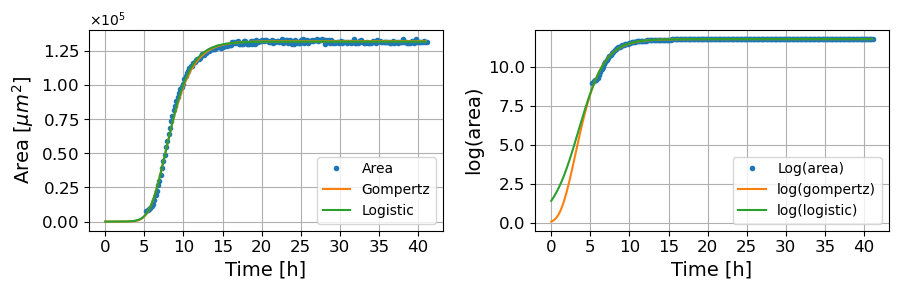

In [47]:
aic_gomp = 0
aic_log = 0
bic_gomp = 0
bic_log = 0

gomp_params = np.zeros((len(df.index.values),3))
log_params = np.zeros((len(df.index.values),3))

for i in [4]:#df.index.values:
    print(i)
    # Fit the model
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60
    #area = extract_array(df.loc[i,'area'])
    area = extract_array(df.loc[i,'area_px']) * df.loc[i,'um_px']**2
    time_points = np.arange(0, df.loc[i, 'exp length'])*10 + incub_time_n

    # this is for positions i in [146,147,149,152,153] that contain area = 0 then log(a) = inf
    valid_indices = area > 0
    time_points = time_points[valid_indices]
    area = area[valid_indices]
    
    #p0_gomp=[area[-1], 200, incub_time_n]
    #p0_log=[np.log(area[-1]), 0.1, incub_time_n]

    p0_gomp=[np.log(area[-1]), 0.02, 300]
    p0_log=[np.log(area[-1]), 0.02, 300]

    # Fit both models   
    ## gomp
    bounds_gomp = ([0, 0, 0], [np.inf, np.inf, np.inf])
    bounds_log = ([0, 0, 0], [np.inf, np.inf, np.inf])
    
    #try:
    params_gompertz, cov_gompertz = curve_fit(gompertz, time_points, np.log(area), p0_gomp, bounds=bounds_gomp, maxfev=10000)
    #except:
    #    idx = np.where(np.isfinite(np.log(area)))[0]
    #    params_gompertz, cov_gompertz = curve_fit(gompertz, time_points[idx], np.log(area)[idx], p0_gomp, bounds=bounds_gomp, maxfev = 10000)#, bounds=([1, 0, 0], [np.inf, np.inf, np.inf]), max_nfev=10000)
    
    ## logistic
    #try:
    params_logistic, cov_logistic = curve_fit(logistic, time_points, np.log(area), p0_log, bounds=bounds_log, maxfev=10000)     
    #except:
    #    idx = np.where(np.isfinite(np.log(area)))[0]
    #    params_logistic, cov_logistic = curve_fit(logistic, time_points[idx], np.log(area)[idx], p0_log, bounds=bounds_log, maxfev=10000)#, bounds=([1, 0, 0], [np.inf, np.inf, np.inf]), max_nfev=10000)

    gomp_params[i,:] = params_gompertz
    log_params[i,:] = params_logistic
    
     # Calculate predicted values
    pred_gompertz = gompertz(time_points, *params_gompertz)
    pred_logistic = logistic(time_points, *params_logistic)
    
    # Calculate residuals
    residuals_gompertz = np.log(area) - pred_gompertz
    residuals_logistic = np.log(area) - pred_logistic
    
    # Calculate SSR (Sum of Squared Residuals)
    ssr_gompertz = np.sum(residuals_gompertz**2)
    ssr_logistic = np.sum(residuals_logistic**2)
    
    # Calculate R²
    r2_gompertz = r2_score(np.log(area), pred_gompertz)
    r2_logistic = r2_score(np.log(area), pred_logistic)
    
    # Calculate AIC
    n = len(area)
    aic_gompertz = n * np.log(ssr_gompertz/n) + 2 * len(params_gompertz)
    aic_logistic = n * np.log(ssr_logistic/n) + 2 * len(params_logistic)
    
    # Calculate BIC
    bic_gompertz = n * np.log(ssr_gompertz/n) + len(params_gompertz) * np.log(n)
    bic_logistic = n * np.log(ssr_logistic/n) + len(params_logistic) * np.log(n)
    
    # Print results
    print("Gompertz Model:")
    print(f"  SSR: {ssr_gompertz:.4f}")
    print(f"  R²: {r2_gompertz:.4f}")
    print(f"  AIC: {aic_gompertz:.4f}")
    print(f"  BIC: {bic_gompertz:.4f}")
    
    print("\nLogistic Model:")
    print(f"  SSR: {ssr_logistic:.4f}")
    print(f"  R²: {r2_logistic:.4f}")
    print(f"  AIC: {aic_logistic:.4f}")
    print(f"  BIC: {bic_logistic:.4f}")
    
    # Determine which model is better
    if aic_gompertz < aic_logistic:
        print("\nThe Gompertz model is preferred based on AIC.")
        aic_gomp = aic_gomp + 1
        
    else:
        print("\nThe Logistic model is preferred based on AIC.")
        aic_log = aic_log + 1
    
    if bic_gompertz < bic_logistic:
        print("The Gompertz model is preferred based on BIC.")
        bic_gomp = bic_gomp + 1
        
    else:
        print("The Logistic model is preferred based on BIC.")
        bic_log = bic_log + 1

    print(f"Gompertz params are: {params_gompertz}")
    print(f"Logistic params are: {params_logistic}")

    ## store fitting results in data_processed file
    pars_gomp_dict = {'A': params_gompertz[0], 'mu_m': params_gompertz[1], 'lambda': params_gompertz[2]}
    pars_log_dict = {'A': params_logistic[0], 'mu_m': params_logistic[1], 'lambda': params_logistic[2]}
    df.at[i, 'gompertz_params_um'] = json.dumps(pars_gomp_dict)
    df.at[i, 'logistic_params_um'] = json.dumps(pars_log_dict)

    time = np.arange(0, time_points[-1], 10, like=time_points)
    #params = list(json.loads(df.loc[i,'logistic_params']).values())
    #params_gomp = list(json.loads(df.loc[i,'gomp_params']).values())
    
    gompertz_full = gompertz(time, *params_gompertz)
    logistic_full = logistic(time, *params_logistic)

    # create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10,3))
    plt.subplots_adjust(wspace=10)  # Increase the spacing between the two plots
    # Set xticks to be every 30 minutes
    x_minutes = time / 60    
    tick_positions = np.arange(0, max(x_minutes), 5)  # Every 5 hours
  
    # Plot data for Area
    axes[0].plot(time_points, area, '.', label='Area')
    axes[0].plot(time, np.exp(gompertz_full), label='Gompertz')
    axes[0].plot(time, np.exp(logistic_full), label='Logistic')
    axes[0].set_xlabel('Time [h]', fontsize=14)
    axes[0].set_xticks(tick_positions * 60)  # Convert tick positions back to seconds for plotting
    axes[0].set_xticklabels([f'{int(tick)}' for tick in tick_positions], fontsize=12)  # No decimal values
    axes[0].set_ylabel('Area [$\mu m^2$]', fontsize=14)  # Change the ylabel size
    axes[0].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))  # Ensure scientific notation for y-axis
    axes[0].tick_params(axis='y', labelsize=12)  # Adjust the y-axis tick label size
    axes[0].grid(True)
    axes[0].legend()
    
    # Plot data for log(Area)
    axes[1].plot(time_points, np.log(area), '.', label='Log(area)')
    axes[1].plot(time, gompertz_full, label='log(gompertz)')
    axes[1].plot(time, logistic_full, label='log(logistic)')
    axes[1].set_xlabel('Time [h]', fontsize=14)
    axes[1].set_ylabel('log(area)', fontsize=14)  # Change the ylabel size
    axes[1].set_xticks(tick_positions * 60)  # Apply to the second plot
    axes[1].set_xticklabels([f'{int(tick)}' for tick in tick_positions], fontsize=12)
    axes[1].tick_params(axis='y', labelsize=12)  # Adjust the y-axis tick label size
    axes[1].grid(True)
    axes[1].legend()

    #plt.suptitle('Growth dynamics', fontsize=16)
    plt.tight_layout()
    plt.savefig('growth_dynamics.png', dpi=300)
    plt.show()

In [49]:
df.to_excel('../data_processed.xlsx', index=False)

In [50]:
aic_gomp

99

In [51]:
bic_gomp

99

In [15]:
gomp_params_um = np.zeros((160,3))
log_params_um = np.zeros((160,3))
for i in df.index.values:
    gomp_um = json.loads(df.loc[i,'gompertz_params_um'])
    gomp_params_um[i,0] = gomp_um['A']
    gomp_params_um[i,1] = gomp_um['mu_m']
    gomp_params_um[i,2] = gomp_um['lambda']

    log_um = json.loads(df.loc[i,'logistic_params_um'])
    log_params_um[i,0] = log_um['A']
    log_params_um[i,1] = log_um['mu_m']
    log_params_um[i,2] = log_um['lambda']

In [16]:
stacked = np.hstack((gomp_params_um, log_params_um))

# Convert to DataFrame
df_gomp_log = pd.DataFrame(stacked, columns=['A_gomp', 'mu_gomp', 'l_gomp',
    'A_log', 'mu_log', 'l_log'
])

df_joined = df_gomp_log.join(pd.DataFrame(df['Dilution']))
df_joined.head()

grouped_df = df_joined.groupby('Dilution').agg(['mean', 'std'])
grouped_df

A_gomp             mu_gomp               l_gomp            \
               mean       std      mean       std       mean       std   
Dilution                                                                 
10^(-5)   12.234114  0.543963  0.029596  0.006252  51.443247  44.69781   
10^(-6)   13.113745  0.442856  0.027737  0.003943  37.293515  42.49082   

              A_log              mu_log              l_log             
               mean       std      mean       std     mean        std  
Dilution                                                               
10^(-5)   12.217536  0.539285  0.023952  0.003818  8.60324  21.594717  
10^(-6)   13.083715  0.429310  0.023330  0.002368  3.08958  10.352982

In [17]:
df_joined

A_gomp   mu_gomp        l_gomp      A_log    mu_log         l_log  \
0    11.556809  0.035012  7.122193e+01  11.553572  0.025999  9.104144e-17   
1    11.913673  0.037267  6.815468e+01  11.910042  0.027747  4.892776e-12   
2    11.842488  0.037759  6.200541e+01  11.837941  0.028473  3.669908e-13   
3    11.525276  0.034977  2.682414e+01  11.514210  0.029012  1.536110e-19   
4    11.790387  0.038477  7.104488e+01  11.788077  0.028228  4.602290e-11   
..         ...       ...           ...        ...       ...           ...   
155  12.091331  0.024264  9.002088e-16  12.069362  0.022430  3.134765e-18   
156  12.176539  0.023336  1.343271e-12  12.152314  0.021632  3.311927e-16   
157  12.276364  0.033693  2.827979e+01  12.267686  0.028345  3.915530e-17   
158  12.174536  0.019783  2.056840e-12  12.145096  0.018395  1.124039e-15   
159  10.638036  0.017806  2.497006e-14  10.607339  0.016640  1.838783e-14   

    Dilution  
0    10^(-5)  
1    10^(-5)  
2    10^(-5)  
3    10^(-5)  
4    10^(-5)  
..       ...  
155  10^(-5)  
156  10^(-5)  
157  10^(-5)  
158  10^(-5)  
159  10^(-5)  

[160 rows x 7 columns]

In [155]:
np.exp(grouped_df['A_gomp']['mean'])

Dilution
10^(-5)    205687.550183
10^(-6)    495709.152483
Name: mean, dtype: float64

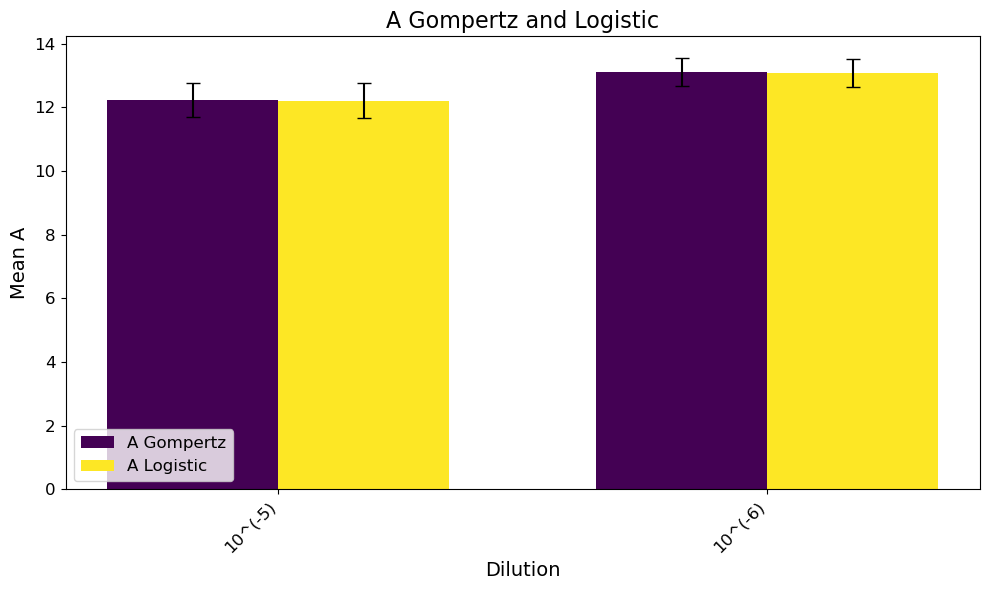

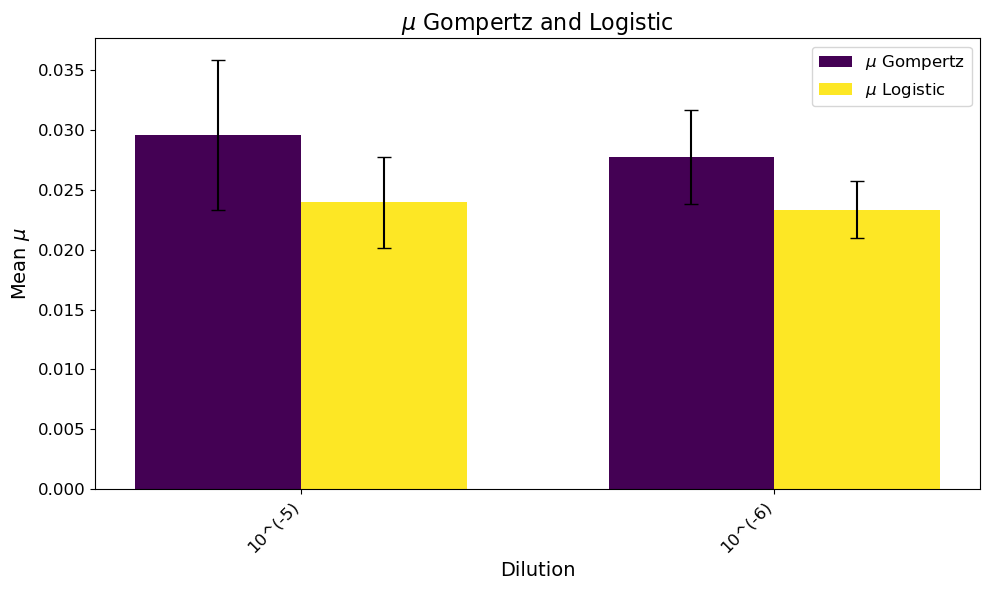

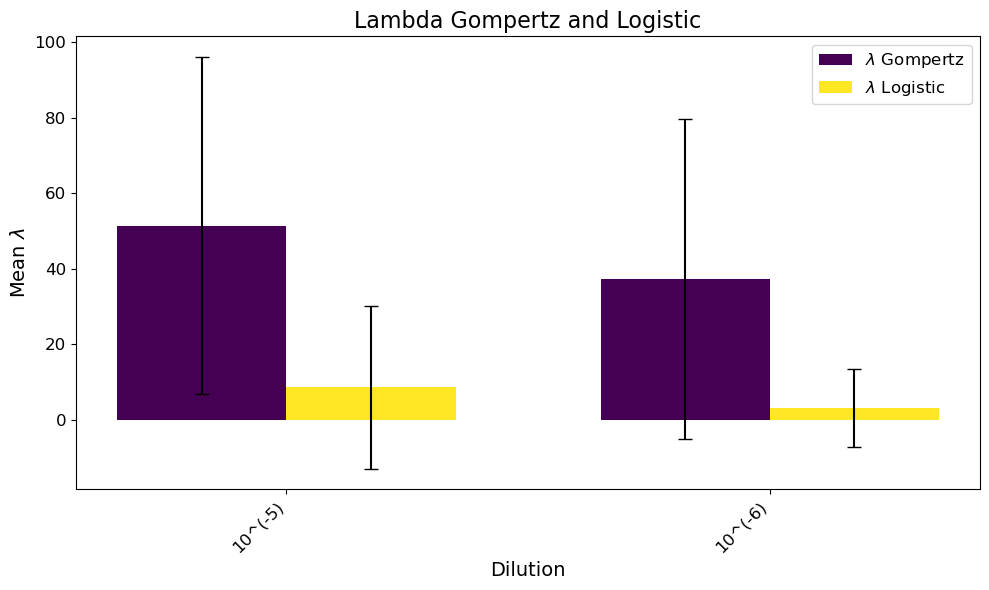

In [156]:
def create_bar_plot(df, parameter1, parameter2, leg1, leg2, title, ylabel, filename):
    # Extract relevant data for plotting
    plot_data = df[[parameter1, parameter2]]
    plot_data.columns = [f'{parameter1}_mean', f'{parameter1}_std', f'{parameter2}_mean', f'{parameter2}_std']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a colormap
    dilutions = plot_data.index
    colors = plt.cm.viridis(np.linspace(0, 1, 2))  # Using only 2 colors for the two parameters

    # Plot the data
    bar_width = 0.35  # width of the bars
    x = np.arange(len(dilutions))  # the label locations

    # Plot parameter1 means with error bars
    ax.bar(x - bar_width/2, plot_data[f'{parameter1}_mean'], yerr=plot_data[f'{parameter1}_std'],
           capsize=5, color=colors[0], label=f'{leg1}', width=bar_width)

    # Plot parameter2 means with error bars
    ax.bar(x + bar_width/2, plot_data[f'{parameter2}_mean'], yerr=plot_data[f'{parameter2}_std'],
           capsize=5, color=colors[1], label=f'{leg2}', width=bar_width)

    # Set the title and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Dilution', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(dilutions, rotation=45, ha="right")
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    #ax.legend(title="Parameter", title_fontsize=14, fontsize=12)
    ax.legend(fontsize=12)

    # Adjust layout for better fit
    plt.tight_layout()

    # Save the plot
    plt.savefig(filename, dpi=300)

    # Show the plot
    plt.show()

# Create the three plots
create_bar_plot(grouped_df, 'A_gomp', 'A_log', 'A Gompertz', 'A Logistic', 'A Gompertz and Logistic', 'Mean A', 'A_gomp_A_log_comparison.png')
create_bar_plot(grouped_df, 'mu_gomp', 'mu_log', '$\mu$ Gompertz', '$\mu$ Logistic', '$\mu$ Gompertz and Logistic', 'Mean $\mu$', 'mu_gomp_mu_log_comparison.png')
create_bar_plot(grouped_df, 'l_gomp', 'l_log', '$\lambda$ Gompertz', '$\lambda$ Logistic', 'Lambda Gompertz and Logistic', 'Mean $\lambda$', 'l_gomp_l_log_comparison.png')


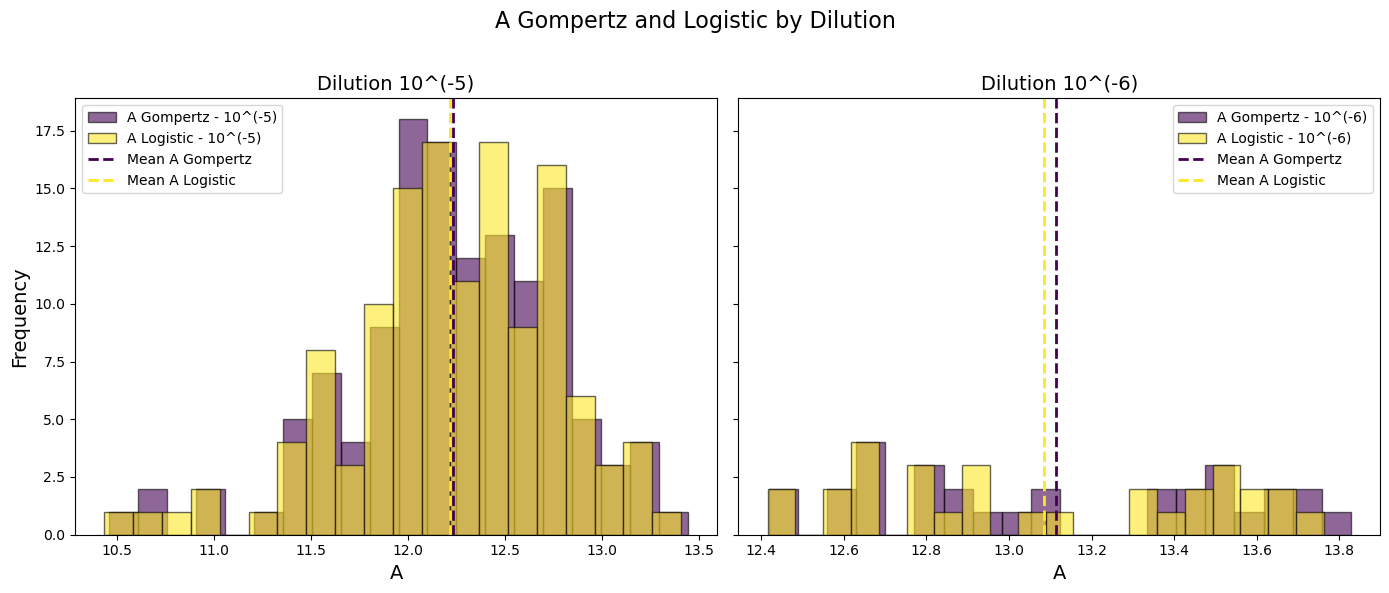

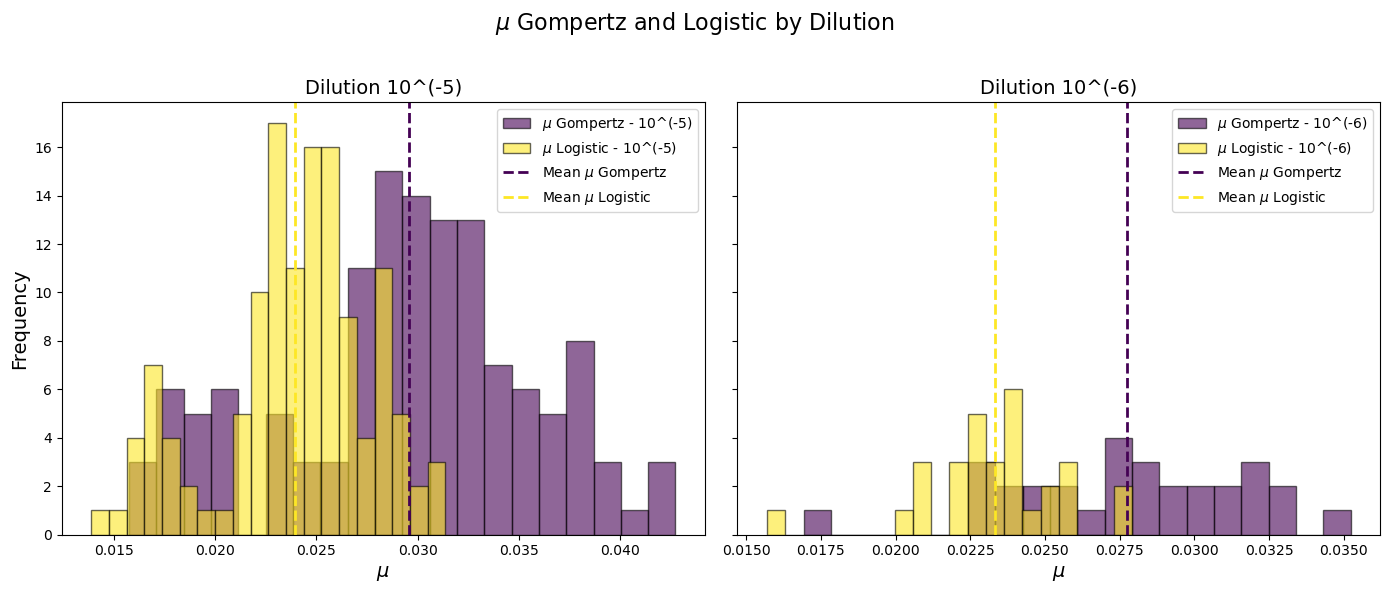

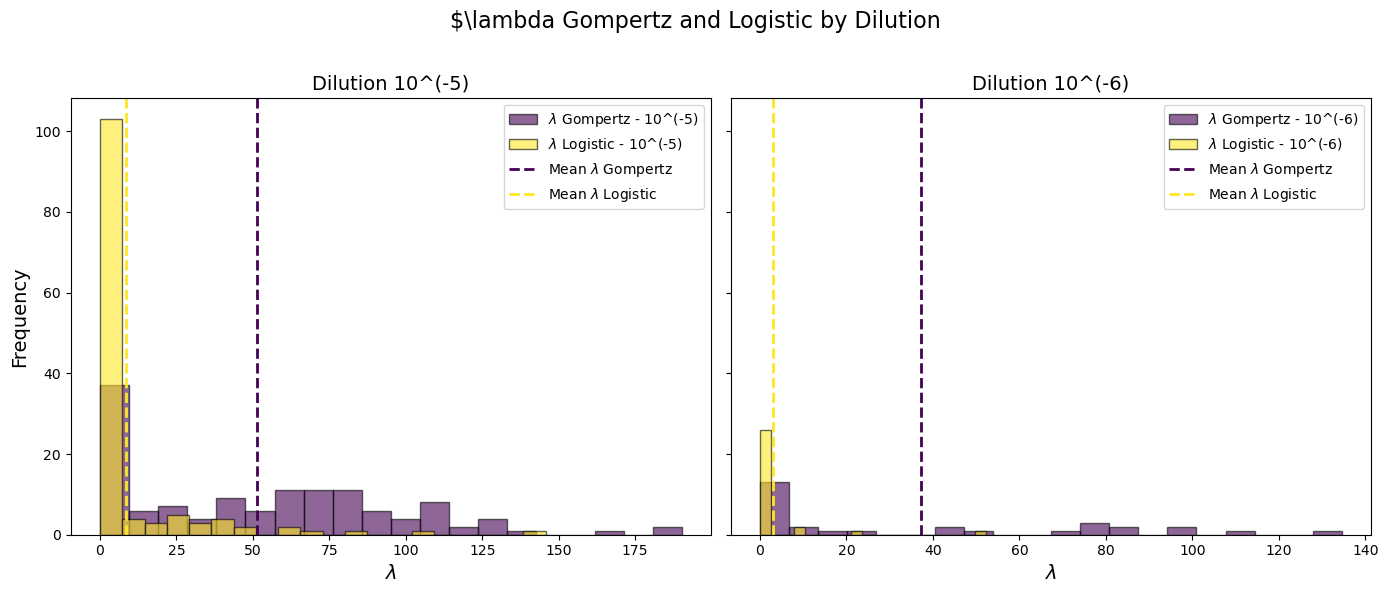

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot overlaid histograms for each parameter and dilution
def create_param_histogram(df, parameter_gomp, parameter_log, leg_gomp, leg_log, title, xlabel, filename):
    # Filter data by dilution
    dilution_5 = df[df['Dilution'] == '10^(-5)']
    dilution_6 = df[df['Dilution'] == '10^(-6)']

    # Create a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, 2))  # Using only 2 colors for the two parameters

    # Create a figure with two subplots, one for each dilution
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Plot histograms for dilution 10^(-5)
    ax[0].hist(dilution_5[parameter_gomp], bins=20, alpha=0.6, color=colors[0], edgecolor='black', label=f'{leg_gomp} - 10^(-5)')
    ax[0].hist(dilution_5[parameter_log], bins=20, alpha=0.6, color=colors[1], edgecolor='black', label=f'{leg_log} - 10^(-5)')
    ax[0].set_title(f'Dilution 10^(-5)', fontsize=14)
    ax[0].set_xlabel(xlabel, fontsize=14)
    ax[0].set_ylabel('Frequency', fontsize=14)

    # Add mean lines for dilution 10^(-5)
    ax[0].axvline(dilution_5[parameter_gomp].mean(), color=colors[0], linestyle='dashed', linewidth=2, label=f'Mean {leg_gomp}')
    ax[0].axvline(dilution_5[parameter_log].mean(), color=colors[1], linestyle='dashed', linewidth=2, label=f'Mean {leg_log}')
    ax[0].legend(fontsize=10)

    # Plot histograms for dilution 10^(-6)
    ax[1].hist(dilution_6[parameter_gomp], bins=20, alpha=0.6, color=colors[0], edgecolor='black', label=f'{leg_gomp} - 10^(-6)')
    ax[1].hist(dilution_6[parameter_log], bins=20, alpha=0.6, color=colors[1], edgecolor='black', label=f'{leg_log} - 10^(-6)')
    ax[1].set_title(f'Dilution 10^(-6)', fontsize=14)
    ax[1].set_xlabel(xlabel, fontsize=14)

    # Add mean lines for dilution 10^(-6)
    ax[1].axvline(dilution_6[parameter_gomp].mean(), color=colors[0], linestyle='dashed', linewidth=2, label=f'Mean {leg_gomp}')
    ax[1].axvline(dilution_6[parameter_log].mean(), color=colors[1], linestyle='dashed', linewidth=2, label=f'Mean {leg_log}')
    ax[1].legend(fontsize=10)

    # Set the main title for the figure
    fig.suptitle(title, fontsize=16)

    # Adjust layout for better fit
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the plot
    plt.savefig(filename, dpi=300)

    # Show the plot
    plt.show()

# Create the histogram plots for A, mu, and lambda
create_param_histogram(df_joined, 'A_gomp', 'A_log', 'A Gompertz', 'A Logistic', 'A Gompertz and Logistic by Dilution', 'A', 'hist_A_gomp_A_log.png')
create_param_histogram(df_joined, 'mu_gomp', 'mu_log', '$\mu$ Gompertz', '$\mu$ Logistic', '$\mu$ Gompertz and Logistic by Dilution', '$\mu$', 'hist_mu_gomp_mu_log.png')
create_param_histogram(df_joined, 'l_gomp', 'l_log', '$\lambda$ Gompertz', '$\lambda$ Logistic', '$\lambda Gompertz and Logistic by Dilution', '$\lambda$', 'hist_l_gomp_l_log.png')

In [152]:
grouped_df

A_gomp             mu_gomp               l_gomp            \
               mean       std      mean       std       mean       std   
Dilution                                                                 
10^(-5)   12.234114  0.543963  0.029596  0.006252  51.443247  44.69781   
10^(-6)   13.113745  0.442856  0.027737  0.003943  37.293515  42.49082   

              A_log              mu_log              l_log             
               mean       std      mean       std     mean        std  
Dilution                                                               
10^(-5)   12.217536  0.539285  0.023952  0.003818  8.60324  21.594717  
10^(-6)   13.083715  0.429310  0.023330  0.002368  3.08958  10.352982

#### Pixels

In [69]:
df = pd.read_excel('../data_processed.xlsx')

0
Gompertz Model:
  SSR: 0.4405
  R²: 0.9945
  AIC: -1332.1265
  BIC: -1322.0007

Logistic Model:
  SSR: 0.3137
  R²: 0.9961
  AIC: -1405.4876
  BIC: -1395.3617

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.12946715e+01 3.42966594e-02 7.50828185e+01]
Logistic params are: [11.29185479  0.02538485  2.80632795]


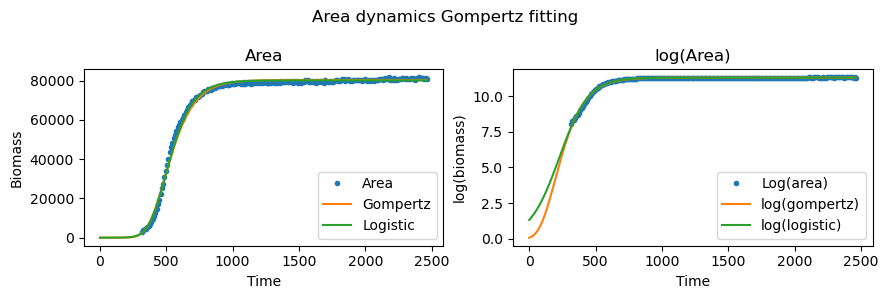

1
Gompertz Model:
  SSR: 0.2839
  R²: 0.9960
  AIC: -1427.0574
  BIC: -1416.9316

Logistic Model:
  SSR: 0.2043
  R²: 0.9971
  AIC: -1498.0545
  BIC: -1487.9287

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16515508e+01 3.65208066e-02 7.17035742e+01]
Logistic params are: [1.16488361e+01 2.69331363e-02 2.01020365e-11]


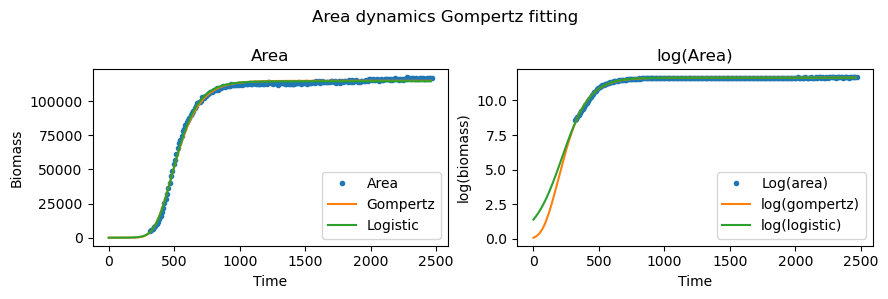

2
Gompertz Model:
  SSR: 0.2726
  R²: 0.9953
  AIC: -1435.7892
  BIC: -1425.6633

Logistic Model:
  SSR: 0.2144
  R²: 0.9963
  AIC: -1487.6376
  BIC: -1477.5118

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15803773e+01 3.69917672e-02 6.54432688e+01]
Logistic params are: [1.15766337e+01 2.76386440e-02 1.24001281e-15]


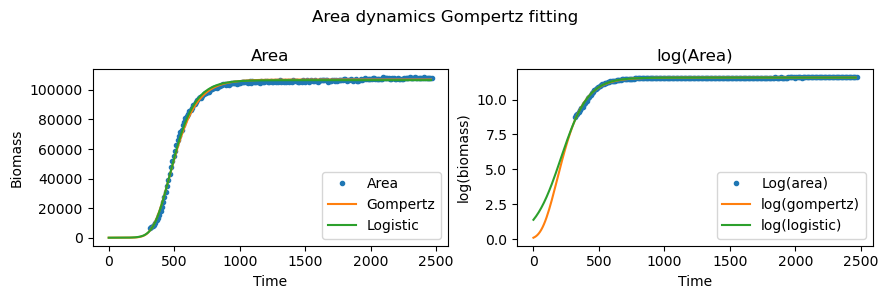

3
Gompertz Model:
  SSR: 0.1950
  R²: 0.9952
  AIC: -1508.1143
  BIC: -1497.9884

Logistic Model:
  SSR: 0.3372
  R²: 0.9918
  AIC: -1389.8725
  BIC: -1379.7466

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.26317914  0.03423451 30.40648262]
Logistic params are: [1.12528244e+01 2.81455114e-02 1.01468261e-18]


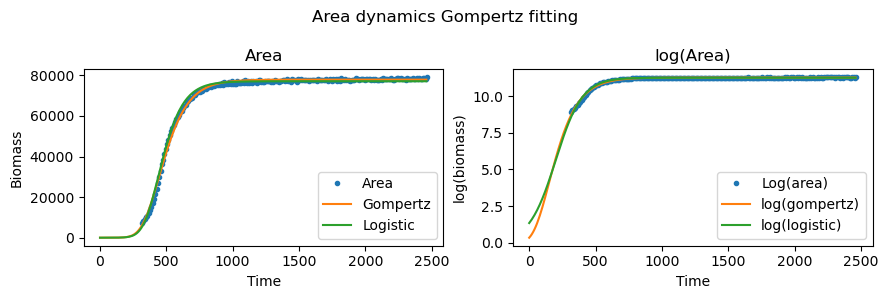

4
Gompertz Model:
  SSR: 0.3211
  R²: 0.9946
  AIC: -1400.4305
  BIC: -1390.3047

Logistic Model:
  SSR: 0.2483
  R²: 0.9958
  AIC: -1455.9555
  BIC: -1445.8296

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15282749e+01 3.76935025e-02 7.44408536e+01]
Logistic params are: [11.52623615  0.02758671  2.66450021]


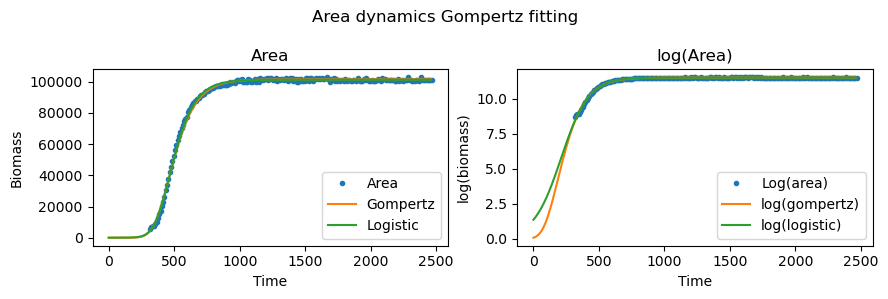

5
Gompertz Model:
  SSR: 0.2232
  R²: 0.9967
  AIC: -1478.9640
  BIC: -1468.8382

Logistic Model:
  SSR: 0.1577
  R²: 0.9977
  AIC: -1553.9609
  BIC: -1543.8351

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.13011062e+01 3.59379971e-02 7.71691916e+01]
Logistic params are: [11.29871967  0.02643601  5.53800146]


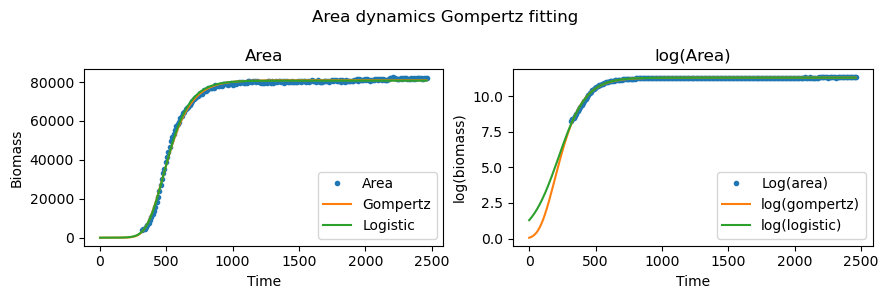

6
Gompertz Model:
  SSR: 0.8088
  R²: 0.9919
  AIC: -1200.8930
  BIC: -1190.7672

Logistic Model:
  SSR: 0.9769
  R²: 0.9902
  AIC: -1160.1001
  BIC: -1149.9743

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.06661699e+01 2.62405127e-02 3.32791281e+01]
Logistic params are: [1.06486262e+01 2.20280959e-02 1.23086543e-19]


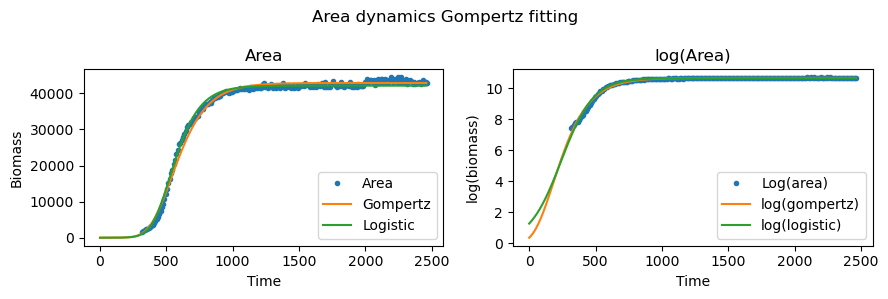

7
Gompertz Model:
  SSR: 0.3549
  R²: 0.9971
  AIC: -1378.8071
  BIC: -1368.6812

Logistic Model:
  SSR: 0.7759
  R²: 0.9936
  AIC: -1209.8531
  BIC: -1199.7272

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.02008212e+01 2.29323066e-02 2.71679608e+01]
Logistic params are: [1.01776184e+01 1.97342775e-02 2.83198765e-20]


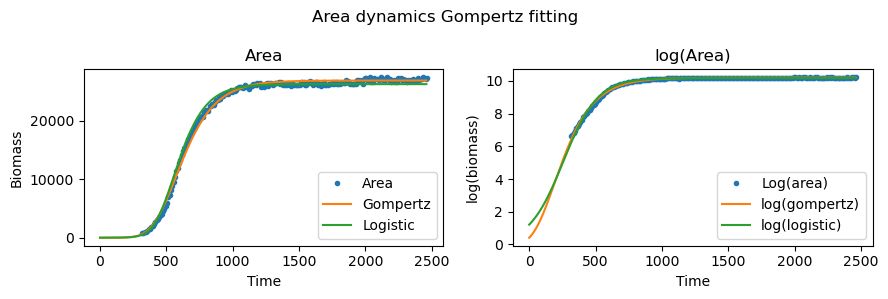

8
Gompertz Model:
  SSR: 0.2758
  R²: 0.9960
  AIC: -1433.2694
  BIC: -1423.1436

Logistic Model:
  SSR: 0.1941
  R²: 0.9972
  AIC: -1509.1877
  BIC: -1499.0618

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16329090e+01 3.71807721e-02 7.58348216e+01]
Logistic params are: [11.63060682  0.02730825  3.94648256]


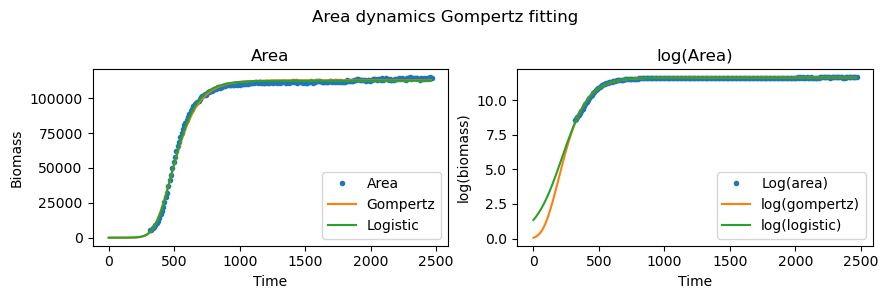

9
Gompertz Model:
  SSR: 0.1863
  R²: 0.9993
  AIC: -1518.0615
  BIC: -1507.9357

Logistic Model:
  SSR: 2.2311
  R²: 0.9916
  AIC: -981.7194
  BIC: -971.5935

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [13.02487156  0.02863516  7.48775434]
Logistic params are: [1.29803605e+01 2.60679491e-02 1.63680103e-15]


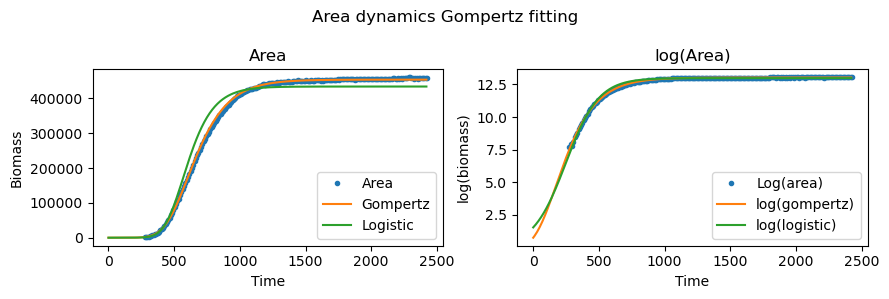

10
Gompertz Model:
  SSR: 0.8056
  R²: 0.9979
  AIC: -1201.7601
  BIC: -1191.6342

Logistic Model:
  SSR: 0.8978
  R²: 0.9976
  AIC: -1178.3523
  BIC: -1168.2264

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.28562285e+01 2.89969457e-02 5.45275941e+01]
Logistic params are: [1.28365171e+01 2.34360906e-02 1.70967893e-22]


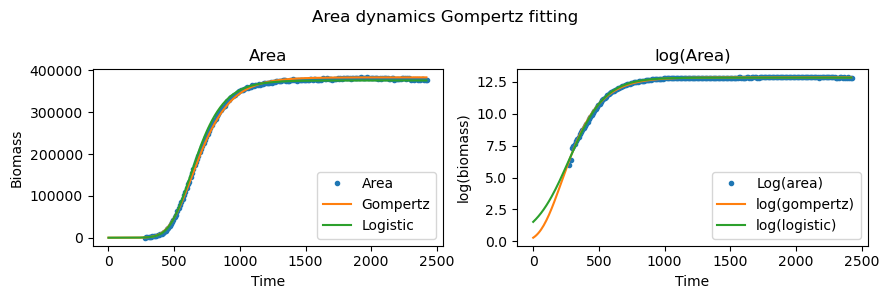

11
Gompertz Model:
  SSR: 0.6309
  R²: 0.9977
  AIC: -1254.5637
  BIC: -1244.4379

Logistic Model:
  SSR: 1.4191
  R²: 0.9949
  AIC: -1079.4578
  BIC: -1069.3319

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.46909191  0.02753392 22.29092118]
Logistic params are: [1.24342316e+01 2.41345245e-02 4.44524969e-16]


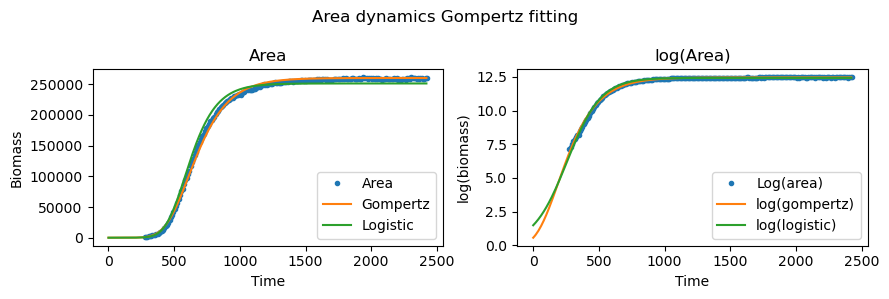

12
Gompertz Model:
  SSR: 0.2273
  R²: 0.9976
  AIC: -1475.0498
  BIC: -1464.9240

Logistic Model:
  SSR: 1.9002
  R²: 0.9800
  AIC: -1016.3982
  BIC: -1006.2724

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.22948330e+01 2.82133284e-02 1.35374311e-20]
Logistic params are: [1.22636016e+01 2.56170285e-02 1.37716349e-14]


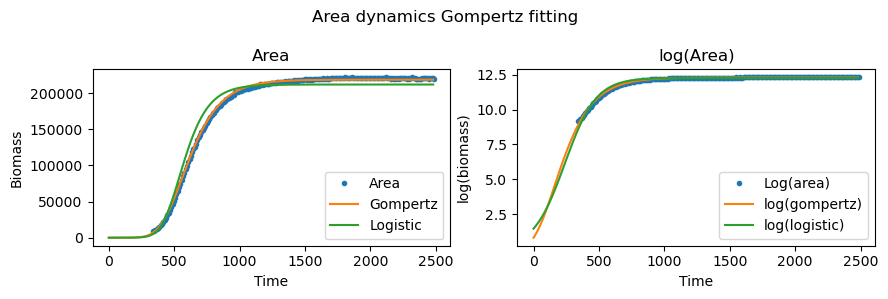

13
Gompertz Model:
  SSR: 0.1436
  R²: 0.9982
  AIC: -1574.2001
  BIC: -1564.0743

Logistic Model:
  SSR: 1.1774
  R²: 0.9856
  AIC: -1119.7795
  BIC: -1109.6537

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.25715387e+01 3.01451615e-02 2.03446073e-12]
Logistic params are: [1.25439613e+01 2.72231637e-02 2.38588098e-17]


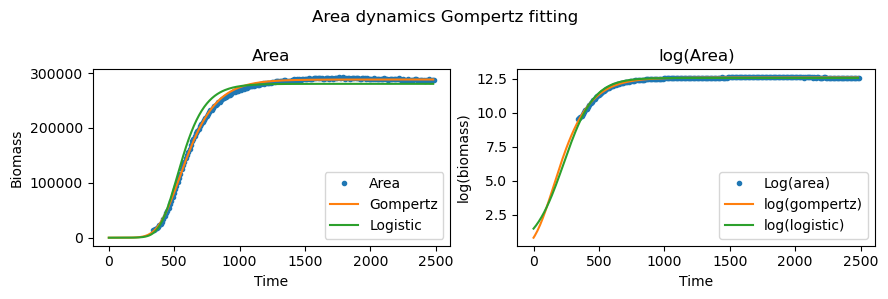

14
Gompertz Model:
  SSR: 0.1512
  R²: 0.9981
  AIC: -1563.1077
  BIC: -1552.9818

Logistic Model:
  SSR: 1.2951
  R²: 0.9840
  AIC: -1099.2063
  BIC: -1089.0804

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.27007938e+01 3.06556815e-02 3.78653235e-29]
Logistic params are: [1.26732784e+01 2.76698247e-02 1.04562586e-17]


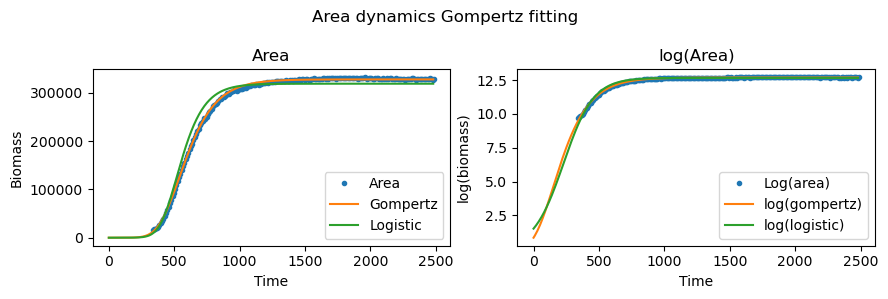

15
Gompertz Model:
  SSR: 0.1810
  R²: 0.9983
  AIC: -1524.2865
  BIC: -1514.1607

Logistic Model:
  SSR: 1.8846
  R²: 0.9823
  AIC: -1018.1798
  BIC: -1008.0539

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.24897139e+01 2.81605485e-02 3.53818235e-18]
Logistic params are: [1.24564984e+01 2.56139785e-02 1.43014286e-14]


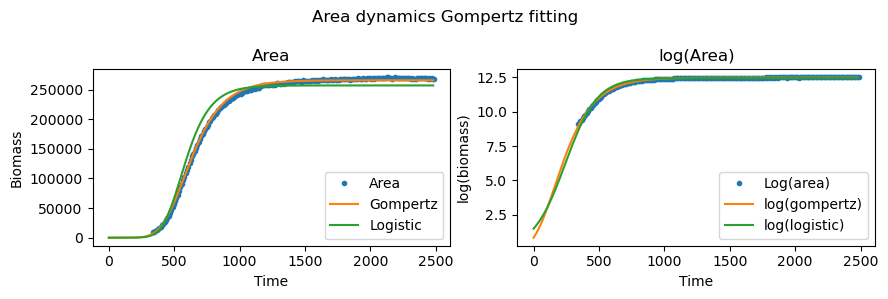

16
Gompertz Model:
  SSR: 0.2186
  R²: 0.9971
  AIC: -1483.5316
  BIC: -1473.4058

Logistic Model:
  SSR: 1.2290
  R²: 0.9838
  AIC: -1110.5247
  BIC: -1100.3989

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.25192052e+01 3.04646874e-02 3.89356499e-25]
Logistic params are: [1.24928713e+01 2.74673426e-02 4.12085285e-17]


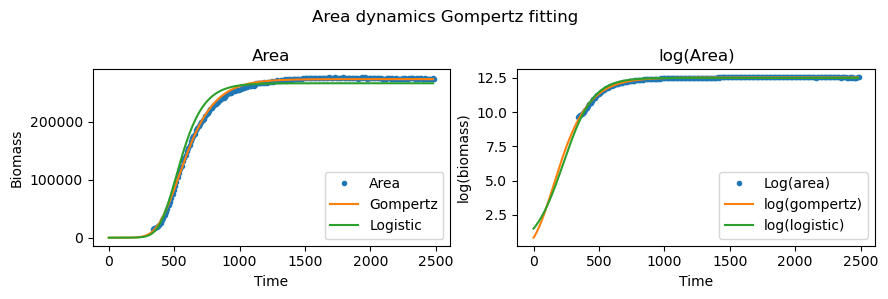

17
Gompertz Model:
  SSR: 0.2110
  R²: 0.9972
  AIC: -1491.1064
  BIC: -1480.9805

Logistic Model:
  SSR: 1.4425
  R²: 0.9810
  AIC: -1075.9151
  BIC: -1065.7892

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.25934742e+01 3.06579915e-02 1.17614743e-24]
Logistic params are: [1.25665883e+01 2.76547433e-02 2.83372047e-18]


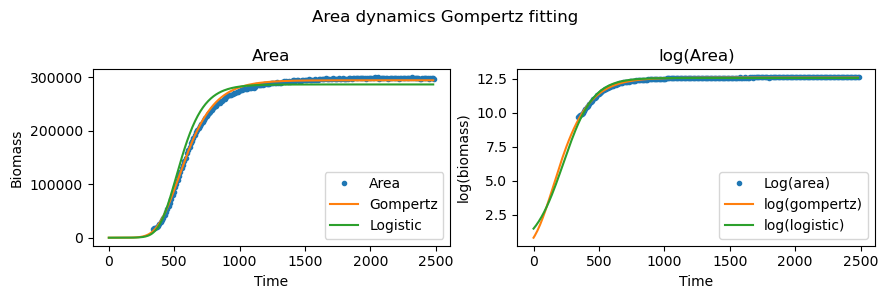

18
Gompertz Model:
  SSR: 8.7131
  R²: 0.9405
  AIC: -687.4585
  BIC: -677.3326

Logistic Model:
  SSR: 17.3876
  R²: 0.8812
  AIC: -538.2164
  BIC: -528.0906

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.29900498e+01 2.59388314e-02 3.46779494e-13]
Logistic params are: [1.29340008e+01 2.39822974e-02 2.61853632e-12]


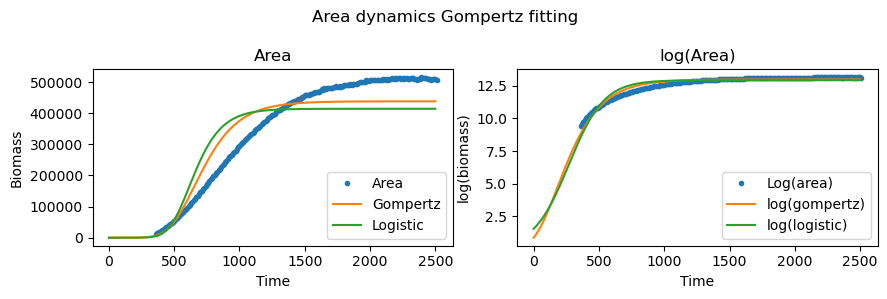

19
Gompertz Model:
  SSR: 0.0619
  R²: 0.9993
  AIC: -1755.8741
  BIC: -1745.7483

Logistic Model:
  SSR: 1.1189
  R²: 0.9869
  AIC: -1130.7998
  BIC: -1120.6740

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.28290454e+01 2.90937909e-02 1.68219537e-13]
Logistic params are: [1.27995581e+01 2.62466542e-02 7.42560289e-18]


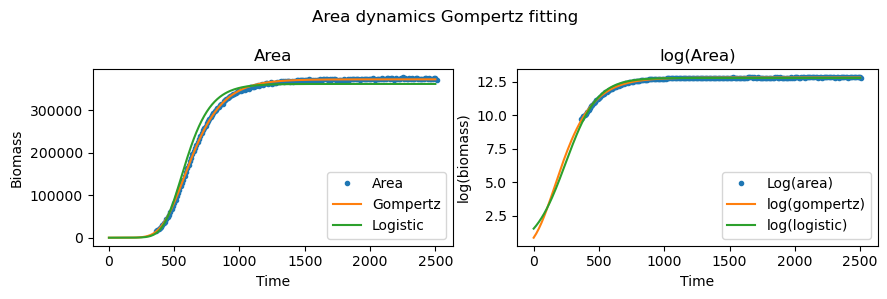

20
Gompertz Model:
  SSR: 0.2674
  R²: 0.9985
  AIC: -1439.9283
  BIC: -1429.8025

Logistic Model:
  SSR: 3.5349
  R²: 0.9807
  AIC: -882.3213
  BIC: -872.1954

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.32850052e+01 2.48483782e-02 4.38247435e-17]
Logistic params are: [1.32334920e+01 2.28174739e-02 1.69127130e-15]


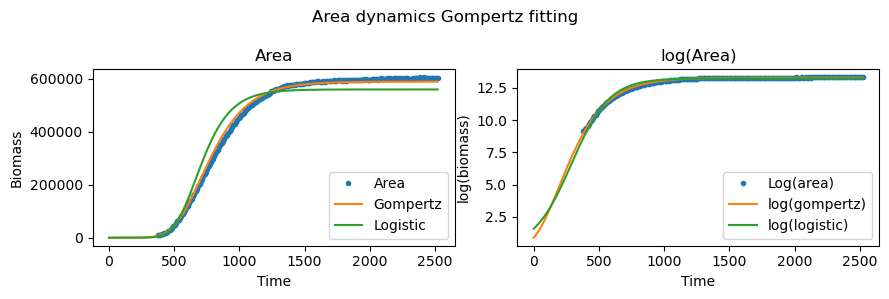

21
Gompertz Model:
  SSR: 1.9104
  R²: 0.9921
  AIC: -1015.2415
  BIC: -1005.1157

Logistic Model:
  SSR: 8.3563
  R²: 0.9653
  AIC: -696.4886
  BIC: -686.3628

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.35690233e+01 2.37722214e-02 1.37503250e-17]
Logistic params are: [1.35033638e+01 2.20045503e-02 1.06446412e-12]


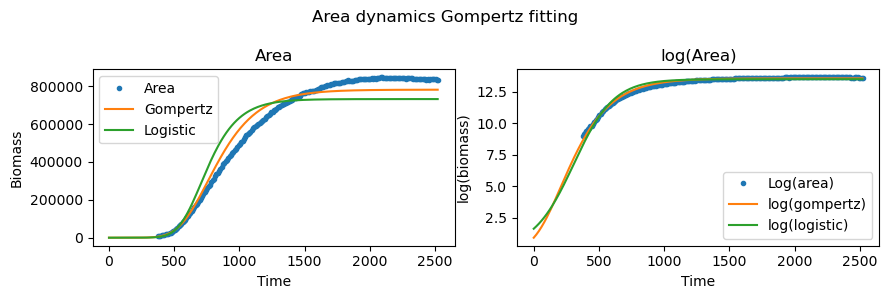

22
Gompertz Model:
  SSR: 1.3505
  R²: 0.9949
  AIC: -1090.1507
  BIC: -1080.0248

Logistic Model:
  SSR: 7.2454
  R²: 0.9728
  AIC: -727.3014
  BIC: -717.1756

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.34941262e+01 2.29653724e-02 5.17995303e-16]
Logistic params are: [1.34255936e+01 2.12888946e-02 7.69789486e-13]


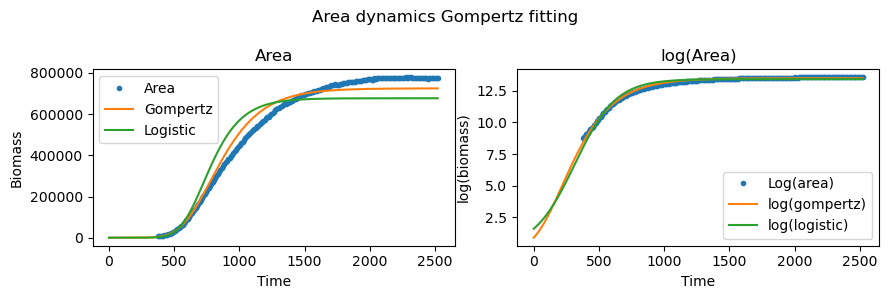

23
Gompertz Model:
  SSR: 0.3434
  R²: 0.9984
  AIC: -1385.9636
  BIC: -1375.8378

Logistic Model:
  SSR: 0.1470
  R²: 0.9993
  AIC: -1569.1530
  BIC: -1559.0271

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.19788975e+01 2.93284501e-02 1.12902975e+02]
Logistic params are: [1.19713467e+01 2.24634230e-02 4.05304187e+01]


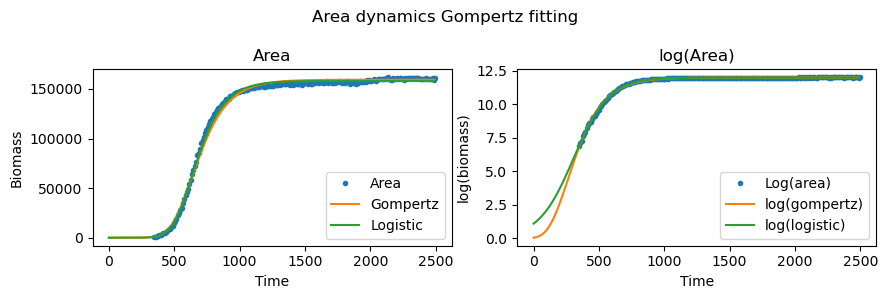

24
Gompertz Model:
  SSR: 0.7110
  R²: 0.9969
  AIC: -1228.7335
  BIC: -1218.6076

Logistic Model:
  SSR: 0.4230
  R²: 0.9981
  AIC: -1340.8922
  BIC: -1330.7664

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.19899099e+01 2.96429774e-02 1.18683328e+02]
Logistic params are: [1.19821223e+01 2.27798588e-02 4.85666694e+01]


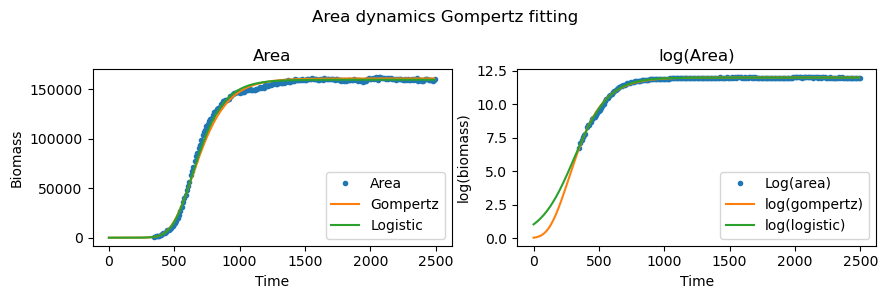

25
Gompertz Model:
  SSR: 0.1151
  R²: 0.9994
  AIC: -1622.0595
  BIC: -1611.9337

Logistic Model:
  SSR: 0.7558
  R²: 0.9962
  AIC: -1215.5267
  BIC: -1205.4009

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.20284973e+01 2.46074008e-02 3.99305524e+01]
Logistic params are: [1.19994301e+01 2.07708226e-02 4.11389159e-19]


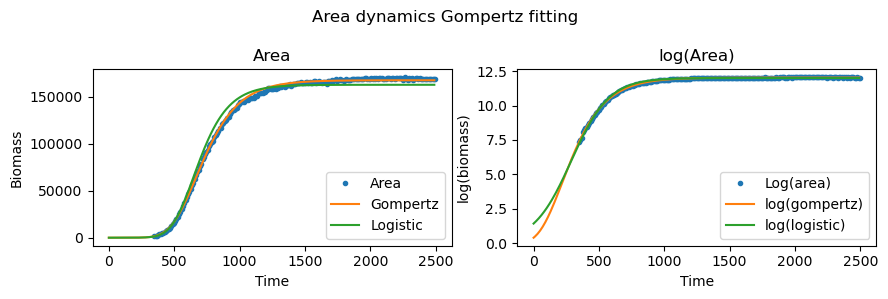

26
Gompertz Model:
  SSR: 0.2191
  R²: 0.9989
  AIC: -1482.9697
  BIC: -1472.8439

Logistic Model:
  SSR: 1.1682
  R²: 0.9940
  AIC: -1121.4770
  BIC: -1111.3511

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.20307572e+01 2.39244186e-02 2.67042645e+01]
Logistic params are: [1.19956411e+01 2.08065186e-02 6.45396471e-14]


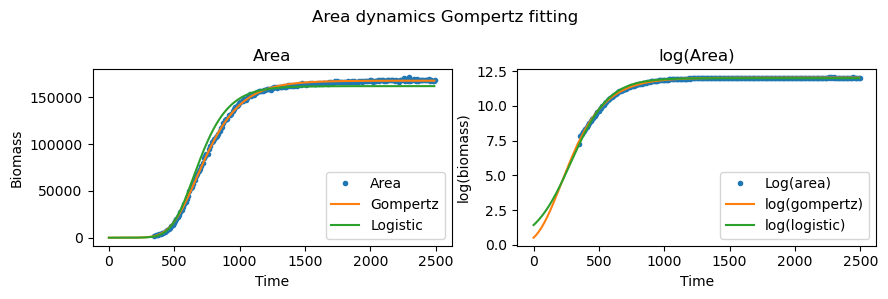

27
Gompertz Model:
  SSR: 0.1303
  R²: 0.9994
  AIC: -1595.2146
  BIC: -1585.0887

Logistic Model:
  SSR: 1.5751
  R²: 0.9930
  AIC: -1056.9213
  BIC: -1046.7955

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.10685514  0.02275994 18.66162961]
Logistic params are: [1.20634038e+01 2.02303782e-02 1.32827510e-16]


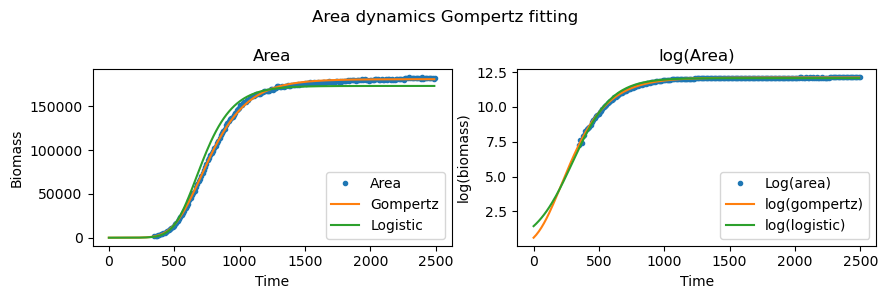

28
Gompertz Model:
  SSR: 0.0982
  R²: 0.9994
  AIC: -1656.3714
  BIC: -1646.2456

Logistic Model:
  SSR: 0.2935
  R²: 0.9983
  AIC: -1419.8510
  BIC: -1409.7252

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.24662021e+01 2.83662838e-02 5.81634375e+01]
Logistic params are: [1.24490562e+01 2.27216197e-02 5.01358637e-19]


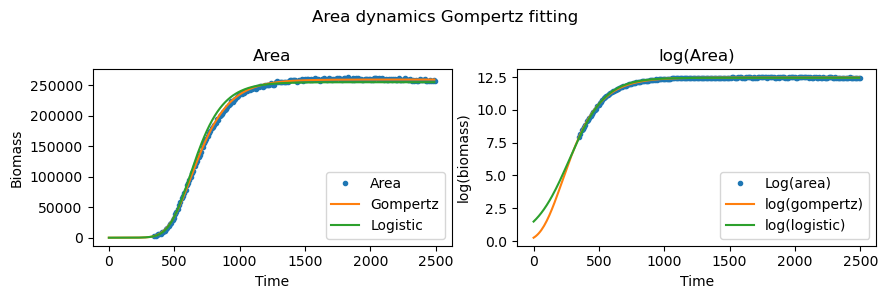

29
Gompertz Model:
  SSR: 0.2278
  R²: 0.9988
  AIC: -1474.6261
  BIC: -1464.5002

Logistic Model:
  SSR: 0.7976
  R²: 0.9958
  AIC: -1203.9081
  BIC: -1193.7823

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.28410441e+01 2.73487279e-02 3.66250191e+01]
Logistic params are: [1.28128211e+01 2.31196866e-02 2.49034446e-18]


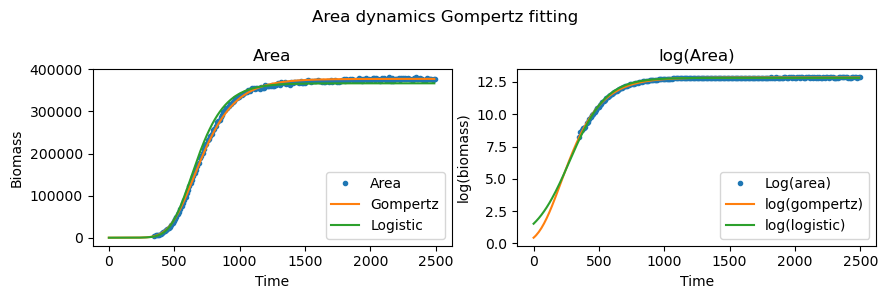

30
Gompertz Model:
  SSR: 0.1044
  R²: 0.9994
  AIC: -1643.1424
  BIC: -1633.0166

Logistic Model:
  SSR: 0.5024
  R²: 0.9973
  AIC: -1303.7431
  BIC: -1293.6172

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.19946318e+01 2.52726434e-02 4.63212419e+01]
Logistic params are: [1.19703213e+01 2.09665592e-02 8.81142483e-18]


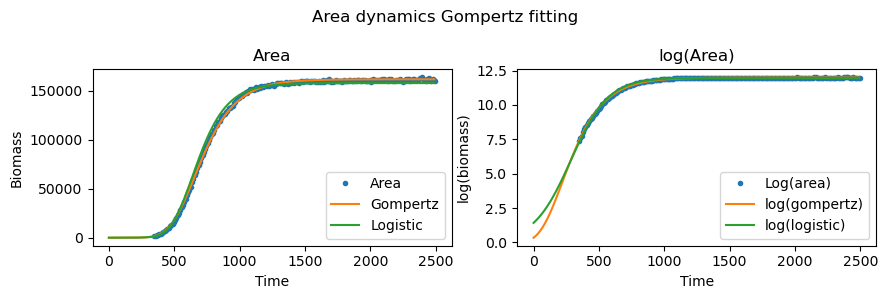

31
Gompertz Model:
  SSR: 0.1758
  R²: 0.9991
  AIC: -1530.5946
  BIC: -1520.4688

Logistic Model:
  SSR: 1.6739
  R²: 0.9912
  AIC: -1043.7915
  BIC: -1033.6657

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.0381379   0.02313197  9.4207409 ]
Logistic params are: [1.19947183e+01 2.08966899e-02 2.68705316e-16]


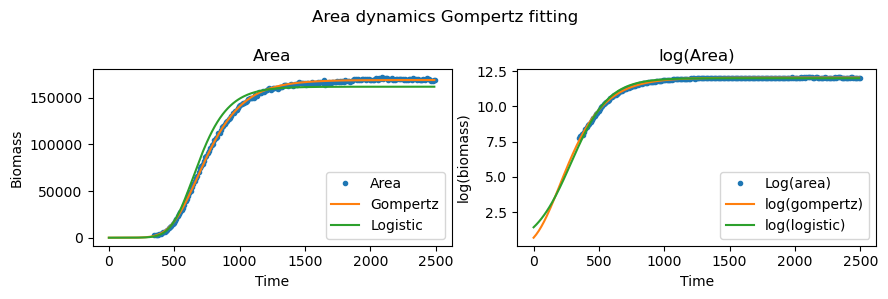

32
Gompertz Model:
  SSR: 0.3330
  R²: 0.9983
  AIC: -1392.5836
  BIC: -1382.4577

Logistic Model:
  SSR: 0.3056
  R²: 0.9984
  AIC: -1411.0956
  BIC: -1400.9698

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.26450251e+01 2.87108121e-02 6.52140034e+01]
Logistic params are: [1.26303517e+01 2.26476490e-02 4.31794070e-19]


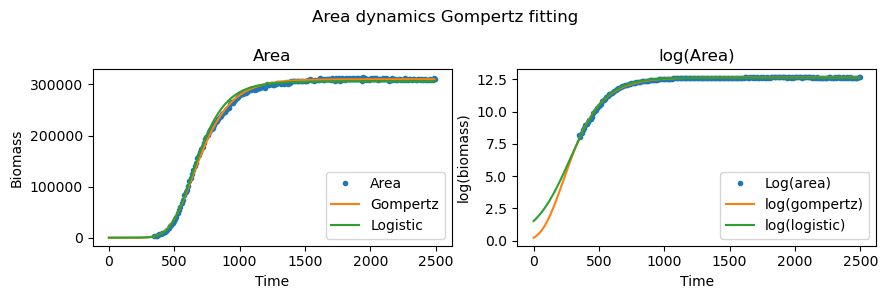

33
Gompertz Model:
  SSR: 0.2710
  R²: 0.9987
  AIC: -1437.0405
  BIC: -1426.9146

Logistic Model:
  SSR: 1.3441
  R²: 0.9935
  AIC: -1091.1901
  BIC: -1081.0642

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.91586804  0.02283315 21.09939664]
Logistic params are: [1.18764785e+01 2.01496346e-02 7.56276274e-16]


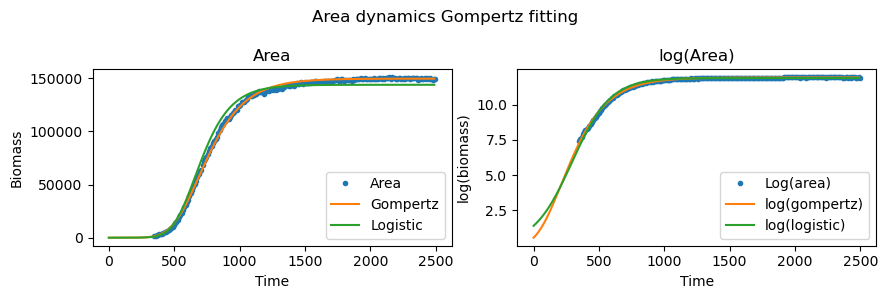

34
Gompertz Model:
  SSR: 0.0665
  R²: 0.9996
  AIC: -2405.6682
  BIC: -2394.6794

Logistic Model:
  SSR: 1.6530
  R²: 0.9903
  AIC: -1480.1862
  BIC: -1469.1973

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [13.45711054  0.02677444  8.202256  ]
Logistic params are: [1.34283445e+01 2.40076260e-02 8.26527871e-15]


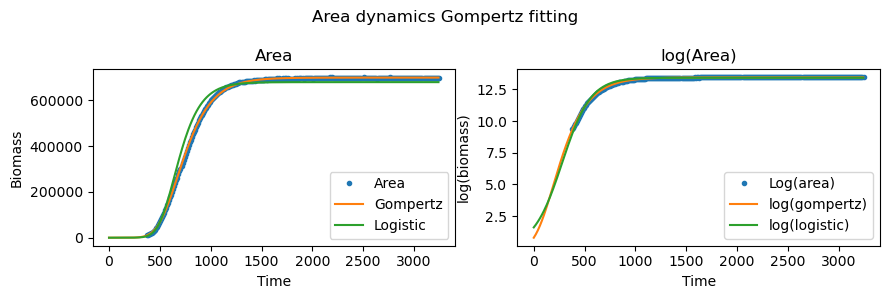

35
Gompertz Model:
  SSR: 0.1701
  R²: 0.9990
  AIC: -2135.1217
  BIC: -2124.1328

Logistic Model:
  SSR: 2.8635
  R²: 0.9827
  AIC: -1321.9394
  BIC: -1310.9505

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.31205029e+01 2.54336398e-02 1.42090888e-24]
Logistic params are: [1.30885341e+01 2.32340437e-02 1.03394937e-15]


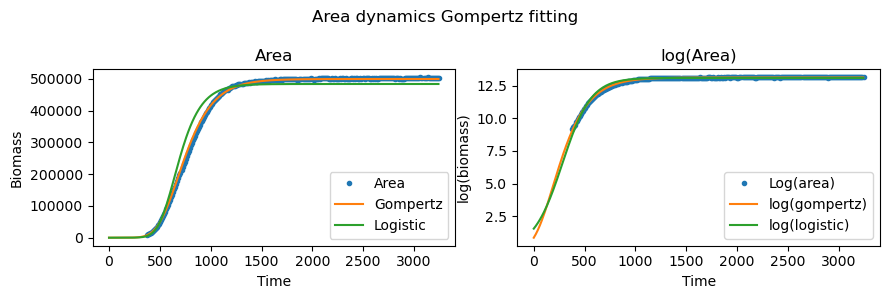

36
Gompertz Model:
  SSR: 0.1972
  R²: 0.9989
  AIC: -2092.4444
  BIC: -2081.4556

Logistic Model:
  SSR: 0.1076
  R²: 0.9994
  AIC: -2267.0019
  BIC: -2256.0130

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.32597023e+01 3.16084057e-02 8.96921621e+01]
Logistic params are: [13.25576284  0.0235969   2.29034372]


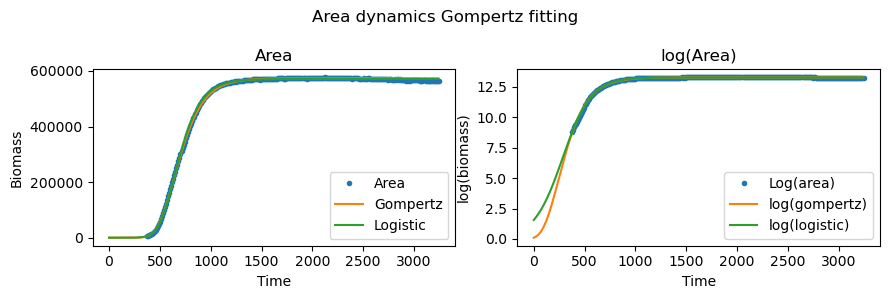

37
Gompertz Model:
  SSR: 0.0712
  R²: 0.9997
  AIC: -2385.7649
  BIC: -2374.7760

Logistic Model:
  SSR: 2.3901
  R²: 0.9890
  AIC: -1373.9863
  BIC: -1362.9975

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.32568797e+01 2.42464560e-02 1.98880433e-15]
Logistic params are: [1.32202340e+01 2.22534515e-02 2.63440372e-17]


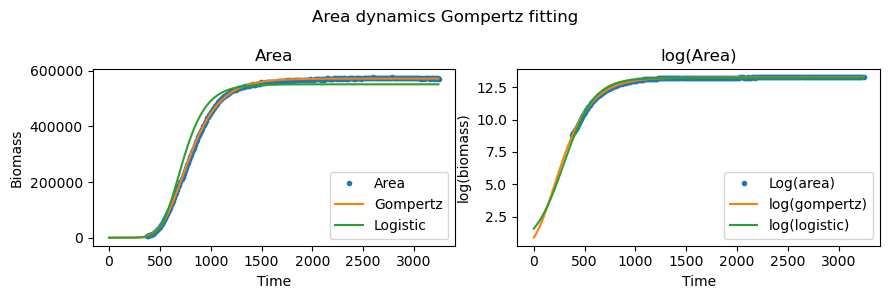

38
Gompertz Model:
  SSR: 0.0921
  R²: 0.9994
  AIC: -2311.6850
  BIC: -2300.6961

Logistic Model:
  SSR: 2.2440
  R²: 0.9855
  AIC: -1392.1506
  BIC: -1381.1617

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.26945290e+01 2.46501493e-02 1.00809173e-20]
Logistic params are: [1.26637676e+01 2.25152100e-02 1.58405282e-16]


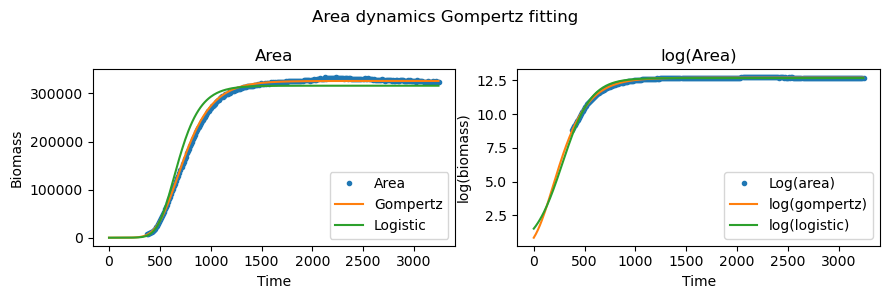

39
Gompertz Model:
  SSR: 0.1045
  R²: 0.9993
  AIC: -2275.4148
  BIC: -2264.4259

Logistic Model:
  SSR: 1.4015
  R²: 0.9911
  AIC: -1527.7255
  BIC: -1516.7366

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [13.11148835  0.02664665 14.79993236]
Logistic params are: [1.30855209e+01 2.35567748e-02 2.78946395e-12]


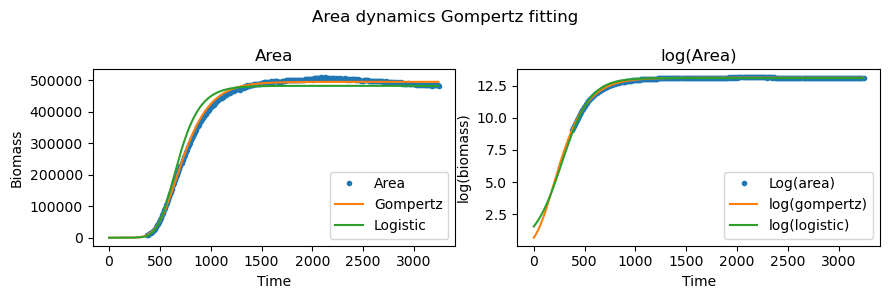

40
Gompertz Model:
  SSR: 4.9293
  R²: 0.9942
  AIC: -1165.5169
  BIC: -1154.5281

Logistic Model:
  SSR: 5.8398
  R²: 0.9931
  AIC: -1116.7005
  BIC: -1105.7116

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [13.41295131  0.01668069 16.57149106]
Logistic params are: [1.33434887e+01 1.52132950e-02 1.01081811e-15]


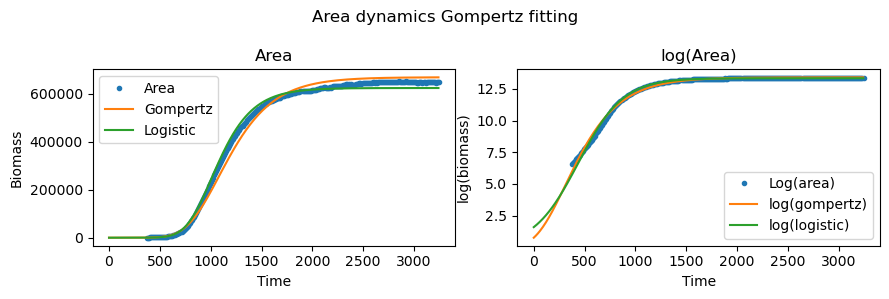

41
Gompertz Model:
  SSR: 0.2322
  R²: 0.9791
  AIC: -1470.4360
  BIC: -1460.3102

Logistic Model:
  SSR: 0.2418
  R²: 0.9782
  AIC: -1461.6728
  BIC: -1451.5469

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.12361345e+01 3.53659614e-02 9.86799126e+01]
Logistic params are: [11.23559777  0.02482528  3.53742593]


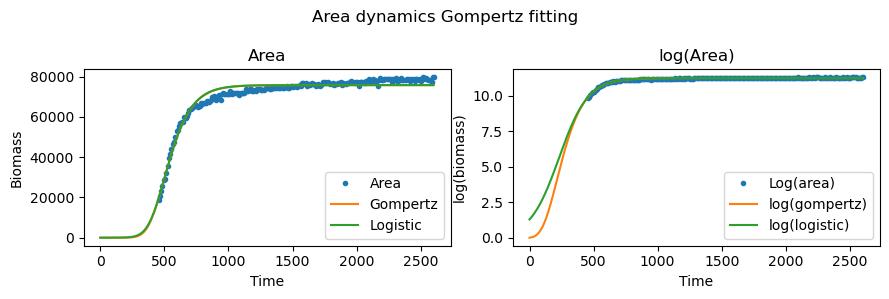

42
Gompertz Model:
  SSR: 0.1459
  R²: 0.9860
  AIC: -1570.7855
  BIC: -1560.6596

Logistic Model:
  SSR: 0.1526
  R²: 0.9854
  AIC: -1561.0769
  BIC: -1550.9510

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.13653822e+01 3.67027288e-02 1.04210267e+02]
Logistic params are: [11.36494908  0.02570915 10.42149277]


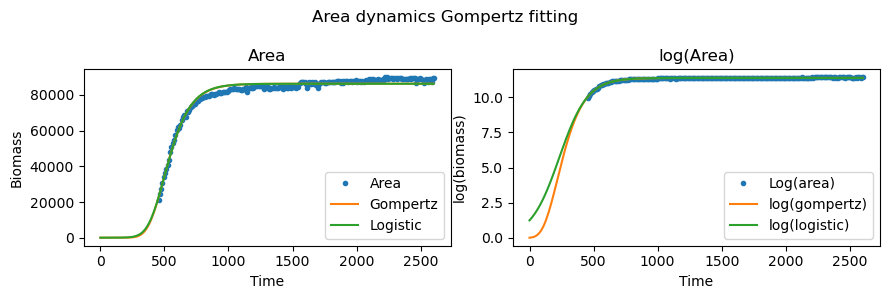

43
Gompertz Model:
  SSR: 0.0573
  R²: 0.9965
  AIC: -1772.8082
  BIC: -1762.6824

Logistic Model:
  SSR: 0.0879
  R²: 0.9947
  AIC: -1680.3532
  BIC: -1670.2273

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.08976628e+01 2.95084095e-02 6.62523628e+01]
Logistic params are: [1.08930658e+01 2.24517372e-02 1.84090987e-19]


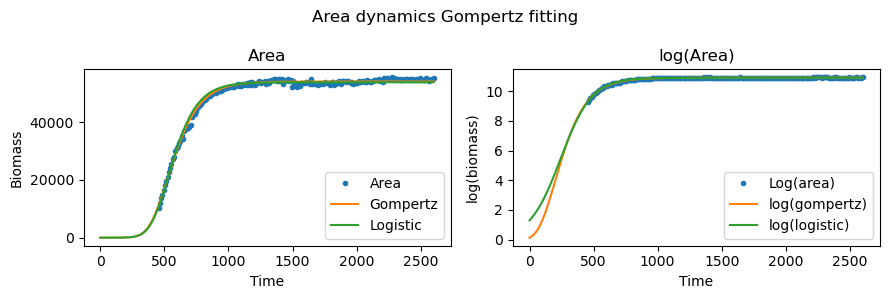

44
Gompertz Model:
  SSR: 0.1185
  R²: 0.9938
  AIC: -1615.7190
  BIC: -1605.5931

Logistic Model:
  SSR: 0.3414
  R²: 0.9823
  AIC: -1387.1694
  BIC: -1377.0435

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.08089459e+01 2.48099256e-02 1.22260056e-15]
Logistic params are: [1.07947135e+01 2.17057063e-02 4.84137975e-17]


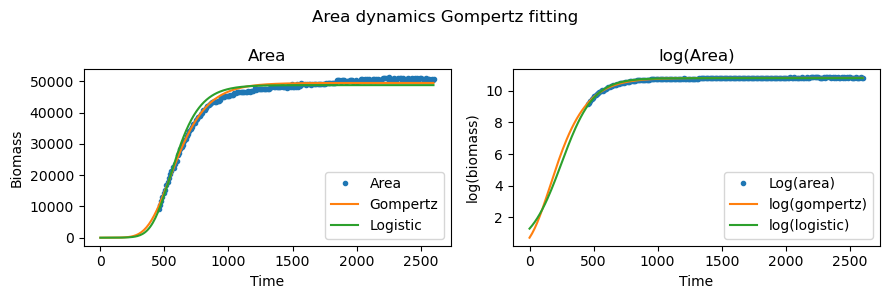

45
Gompertz Model:
  SSR: 0.0920
  R²: 0.9953
  AIC: -1670.3458
  BIC: -1660.2200

Logistic Model:
  SSR: 0.1486
  R²: 0.9924
  AIC: -1566.8122
  BIC: -1556.6864

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.07242946e+01 2.74998396e-02 5.68426196e+01]
Logistic params are: [1.07176669e+01 2.14764605e-02 1.25390282e-14]


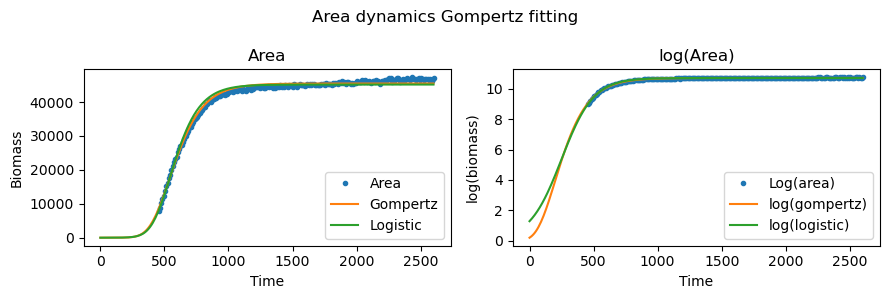

46
Gompertz Model:
  SSR: 0.0878
  R²: 0.9962
  AIC: -1680.6042
  BIC: -1670.4783

Logistic Model:
  SSR: 0.1110
  R²: 0.9952
  AIC: -1629.9235
  BIC: -1619.7976

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.07626794e+01 2.89313272e-02 8.91631546e+01]
Logistic params are: [1.07599627e+01 2.11273120e-02 6.37592253e-19]


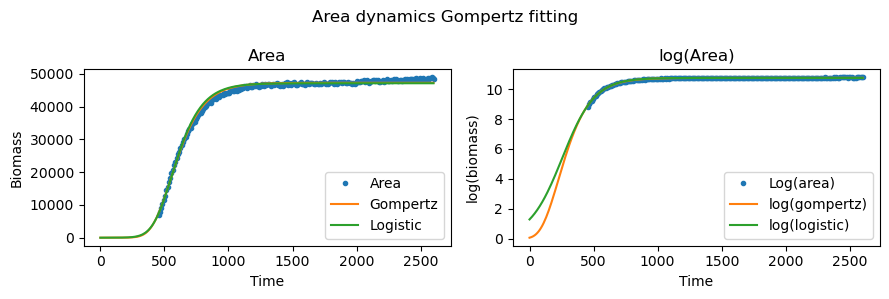

47
Gompertz Model:
  SSR: 0.0530
  R²: 0.9974
  AIC: -1789.3831
  BIC: -1779.2572

Logistic Model:
  SSR: 0.0895
  R²: 0.9956
  AIC: -1676.4262
  BIC: -1666.3004

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.08127041e+01 2.85011920e-02 7.08356171e+01]
Logistic params are: [1.08078426e+01 2.16046227e-02 2.32873380e-19]


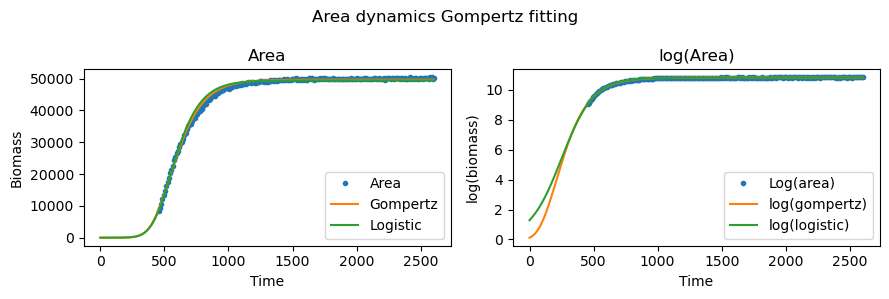

48
Gompertz Model:
  SSR: 0.1855
  R²: 0.9917
  AIC: -1518.9236
  BIC: -1508.7978

Logistic Model:
  SSR: 0.1944
  R²: 0.9913
  AIC: -1508.8769
  BIC: -1498.7511

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.09739160e+01 3.72235905e-02 1.71532893e+02]
Logistic params are: [1.09729644e+01 2.65511499e-02 9.10686092e+01]


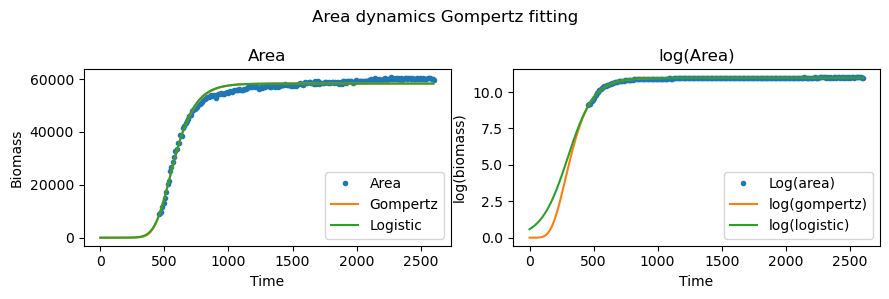

49
Gompertz Model:
  SSR: 0.2812
  R²: 0.9840
  AIC: -1429.1336
  BIC: -1419.0077

Logistic Model:
  SSR: 0.2975
  R²: 0.9831
  AIC: -1416.8988
  BIC: -1406.7729

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.12243102e+01 3.60394159e-02 1.34798471e+02]
Logistic params are: [1.12234934e+01 2.55187030e-02 4.60684753e+01]


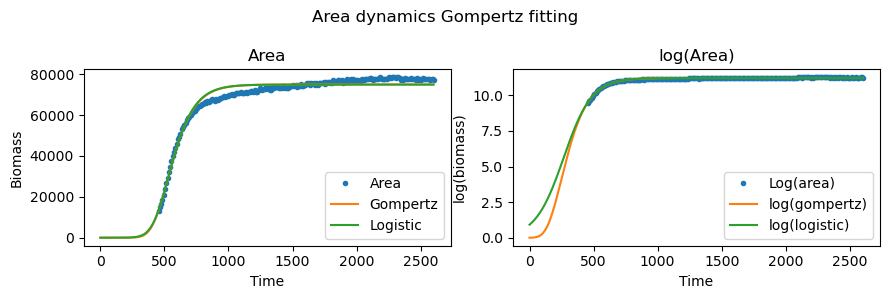

50
Gompertz Model:
  SSR: 0.0282
  R²: 0.9987
  AIC: -1925.4622
  BIC: -1915.3364

Logistic Model:
  SSR: 0.0297
  R²: 0.9986
  AIC: -1914.7446
  BIC: -1904.6188

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.12413921e+01 4.06846022e-02 1.88669730e+02]
Logistic params are: [1.12406870e+01 2.89307271e-02 1.12088722e+02]


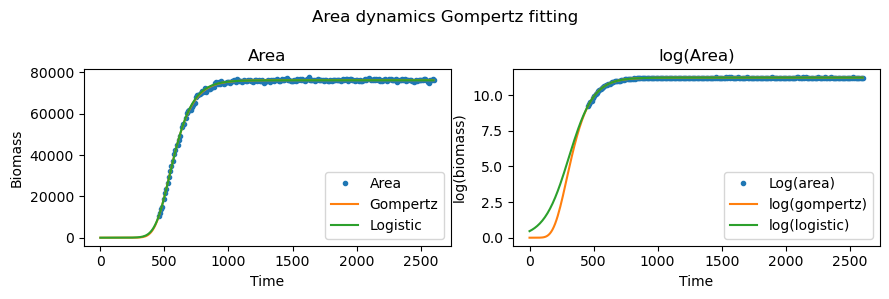

51
Gompertz Model:
  SSR: 0.1285
  R²: 0.9874
  AIC: -1598.3355
  BIC: -1588.2097

Logistic Model:
  SSR: 0.1350
  R²: 0.9868
  AIC: -1587.5781
  BIC: -1577.4522

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.13691483e+01 3.62859850e-02 9.83618778e+01]
Logistic params are: [11.36871043  0.02541276  3.35361221]


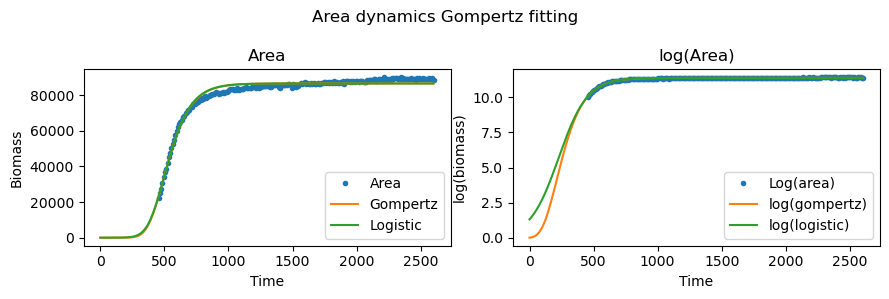

52
Gompertz Model:
  SSR: 0.1161
  R²: 0.9953
  AIC: -1620.1792
  BIC: -1610.0534

Logistic Model:
  SSR: 0.1326
  R²: 0.9946
  AIC: -1591.4020
  BIC: -1581.2761

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.01357947e+01 2.92558674e-02 1.30630919e+02]
Logistic params are: [1.01347304e+01 2.08827916e-02 3.65307033e+01]


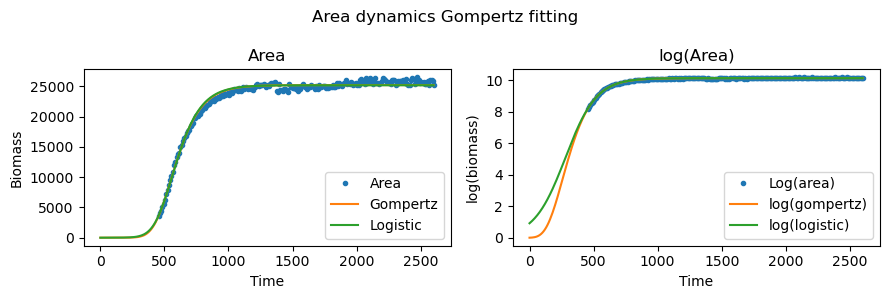

53
Gompertz Model:
  SSR: 0.0935
  R²: 0.9936
  AIC: -1666.9440
  BIC: -1656.8182

Logistic Model:
  SSR: 0.1742
  R²: 0.9881
  AIC: -1532.5260
  BIC: -1522.4001

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.09365944e+01 2.80057265e-02 3.05981469e+01]
Logistic params are: [1.09283387e+01 2.29026395e-02 1.99808295e-17]


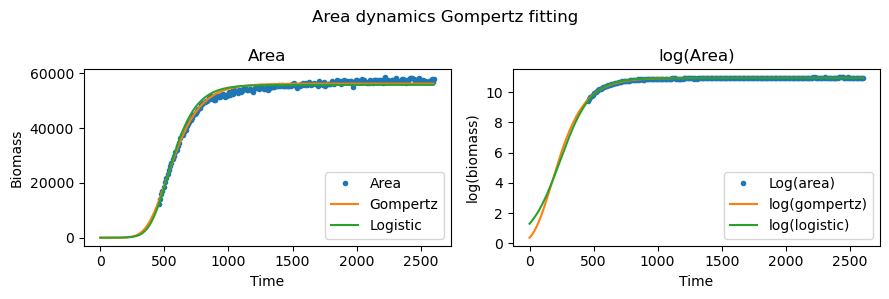

54
Gompertz Model:
  SSR: 0.1068
  R²: 0.9944
  AIC: -1638.1539
  BIC: -1628.0280

Logistic Model:
  SSR: 0.3209
  R²: 0.9832
  AIC: -1400.5546
  BIC: -1390.4288

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.08104762e+01 2.48508829e-02 3.05935662e-11]
Logistic params are: [1.07963421e+01 2.17362141e-02 1.27950686e-16]


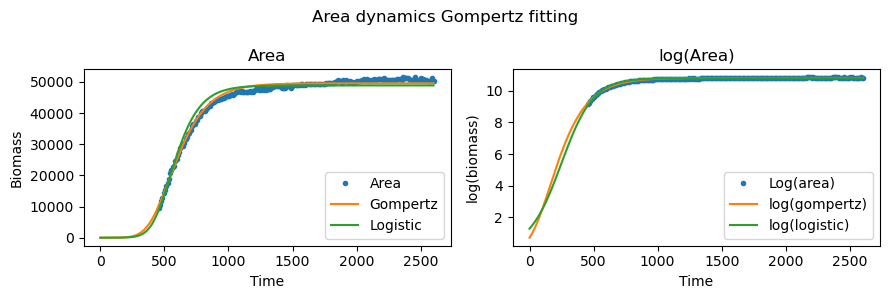

55
Gompertz Model:
  SSR: 0.1430
  R²: 0.9941
  AIC: -1575.0973
  BIC: -1564.9715

Logistic Model:
  SSR: 0.1749
  R²: 0.9928
  AIC: -1531.7264
  BIC: -1521.6005

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.03171017e+01 2.69294731e-02 8.60746386e+01]
Logistic params are: [1.03136361e+01 1.98831449e-02 5.71621508e-17]


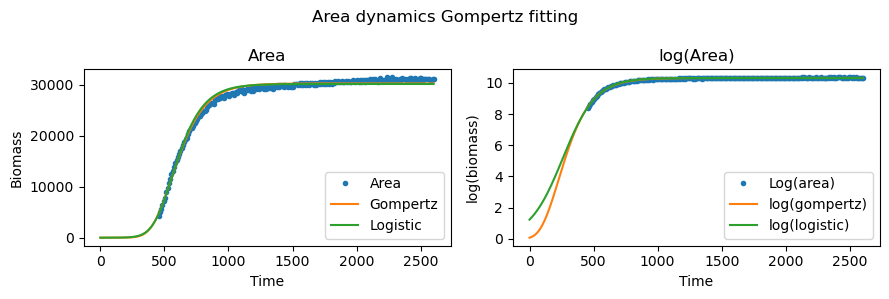

56
Gompertz Model:
  SSR: 0.4544
  R²: 0.9948
  AIC: -1325.4411
  BIC: -1315.3153

Logistic Model:
  SSR: 0.3595
  R²: 0.9959
  AIC: -1376.0282
  BIC: -1365.9024

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.24256451e+01 3.18914373e-02 1.04551314e+02]
Logistic params are: [12.42239807  0.02340344 14.41381639]


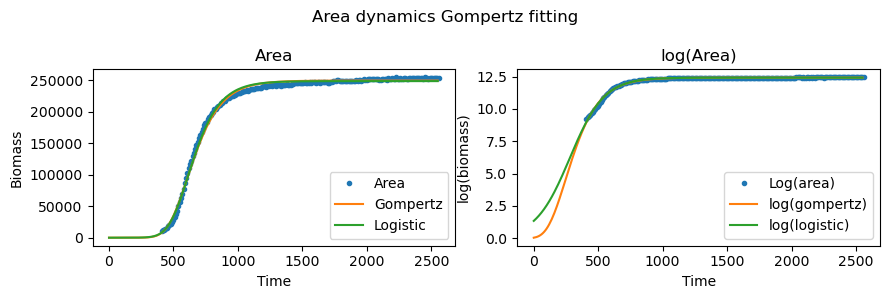

57
Gompertz Model:
  SSR: 0.2557
  R²: 0.9961
  AIC: -1449.6144
  BIC: -1439.4886

Logistic Model:
  SSR: 0.2542
  R²: 0.9962
  AIC: -1450.9055
  BIC: -1440.7797

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.26368208e+01 3.19230874e-02 7.26957586e+01]
Logistic params are: [1.26292861e+01 2.43460998e-02 6.64556904e-20]


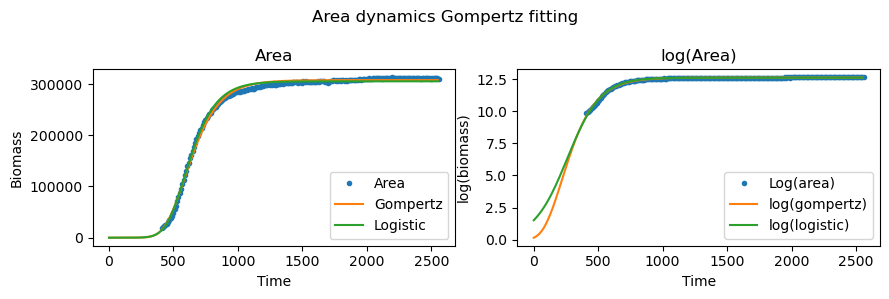

58
Gompertz Model:
  SSR: 0.4427
  R²: 0.9951
  AIC: -1331.0648
  BIC: -1320.9390

Logistic Model:
  SSR: 0.3676
  R²: 0.9959
  AIC: -1371.2443
  BIC: -1361.1185

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.21569778e+01 3.15847284e-02 1.14632922e+02]
Logistic params are: [1.21534687e+01 2.32605790e-02 2.73660883e+01]


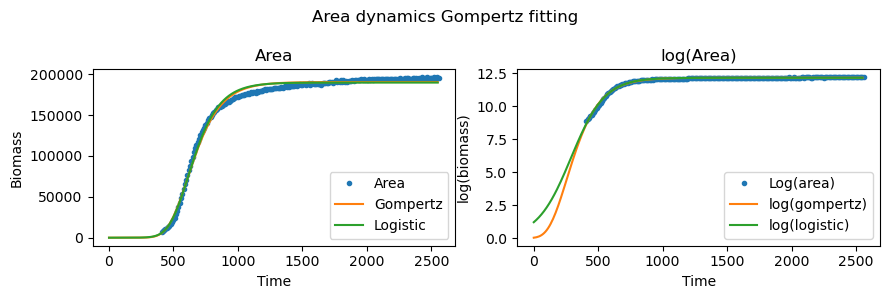

59
Gompertz Model:
  SSR: 0.4210
  R²: 0.9964
  AIC: -1341.9315
  BIC: -1331.8056

Logistic Model:
  SSR: 0.2814
  R²: 0.9976
  AIC: -1428.9315
  BIC: -1418.8057

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.28598507e+01 3.46027151e-02 1.38422495e+02]
Logistic params are: [1.28559460e+01 2.56359117e-02 5.72427412e+01]


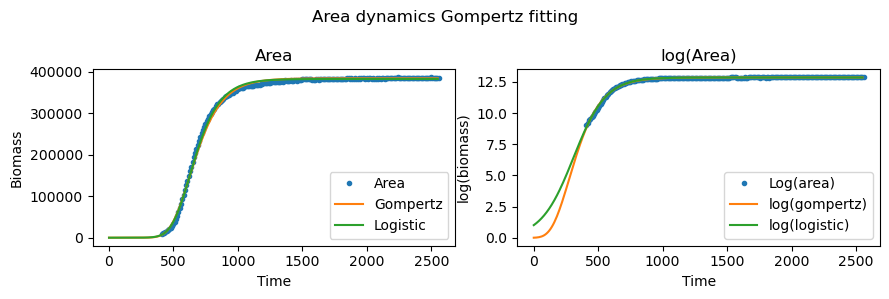

60
Gompertz Model:
  SSR: 0.4030
  R²: 0.9958
  AIC: -1351.3613
  BIC: -1341.2354

Logistic Model:
  SSR: 0.3019
  R²: 0.9969
  AIC: -1413.7833
  BIC: -1403.6575

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.25132005e+01 3.16027108e-02 1.04635934e+02]
Logistic params are: [12.5097054   0.02323784 14.11604121]


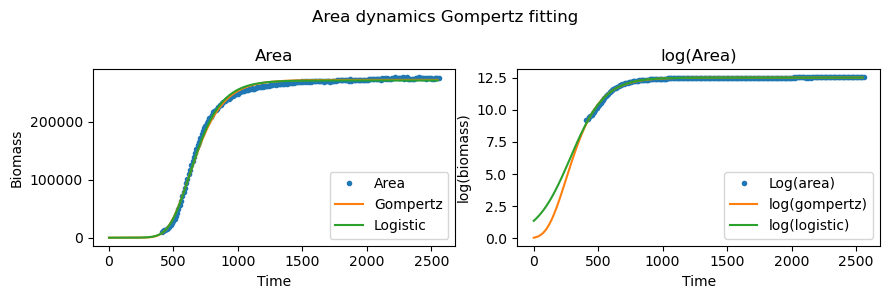

61
Gompertz Model:
  SSR: 0.2682
  R²: 0.9965
  AIC: -1439.3305
  BIC: -1429.2046

Logistic Model:
  SSR: 0.2353
  R²: 0.9969
  AIC: -1467.5453
  BIC: -1457.4194

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.23214182e+01 3.05614273e-02 8.15766184e+01]
Logistic params are: [1.23152559e+01 2.29673331e-02 4.48325430e-26]


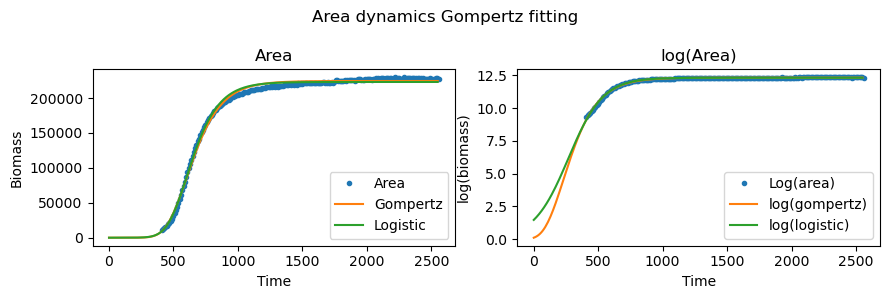

62
Gompertz Model:
  SSR: 0.1983
  R²: 0.9982
  AIC: -1504.5620
  BIC: -1494.4361

Logistic Model:
  SSR: 0.1459
  R²: 0.9987
  AIC: -1570.8172
  BIC: -1560.6914

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.23784547e+01 2.85916098e-02 8.68946156e+01]
Logistic params are: [1.23715807e+01 2.15123454e-02 1.81753553e-27]


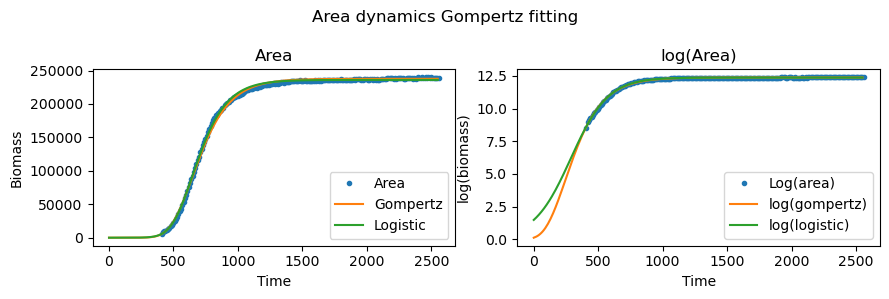

63
Gompertz Model:
  SSR: 0.0790
  R²: 0.9991
  AIC: -1703.4453
  BIC: -1693.3194

Logistic Model:
  SSR: 0.2742
  R²: 0.9968
  AIC: -1434.5410
  BIC: -1424.4151

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.21800516e+01 2.73764188e-02 5.24488650e+01]
Logistic params are: [1.21642408e+01 2.21173861e-02 2.44873819e-19]


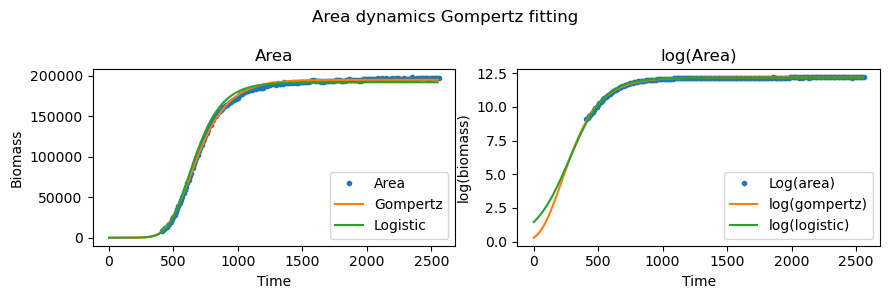

64
Gompertz Model:
  SSR: 0.1782
  R²: 0.9982
  AIC: -1527.5794
  BIC: -1517.4536

Logistic Model:
  SSR: 0.4025
  R²: 0.9960
  AIC: -1351.6383
  BIC: -1341.5125

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.23550996e+01 2.67326381e-02 4.96937349e+01]
Logistic params are: [1.23366789e+01 2.18219123e-02 1.15436548e-16]


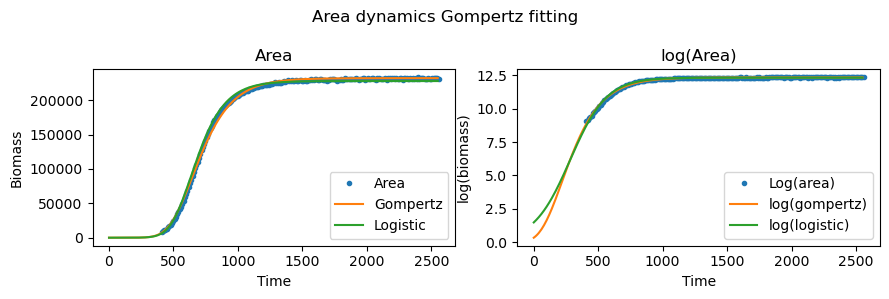

65
Gompertz Model:
  SSR: 0.4235
  R²: 0.9962
  AIC: -1340.6449
  BIC: -1330.5191

Logistic Model:
  SSR: 0.3227
  R²: 0.9971
  AIC: -1399.3483
  BIC: -1389.2224

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.25236477e+01 2.88687483e-02 8.22242682e+01]
Logistic params are: [1.25155115e+01 2.19265796e-02 1.56570444e-19]


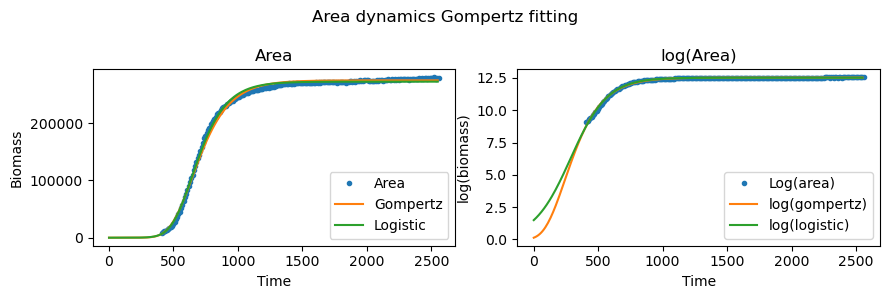

66
Gompertz Model:
  SSR: 0.3177
  R²: 0.9971
  AIC: -1402.7372
  BIC: -1392.6114

Logistic Model:
  SSR: 0.2394
  R²: 0.9978
  AIC: -1463.8227
  BIC: -1453.6969

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.23743298e+01 2.81643252e-02 7.94759859e+01]
Logistic params are: [1.23651617e+01 2.15510451e-02 3.67929936e-21]


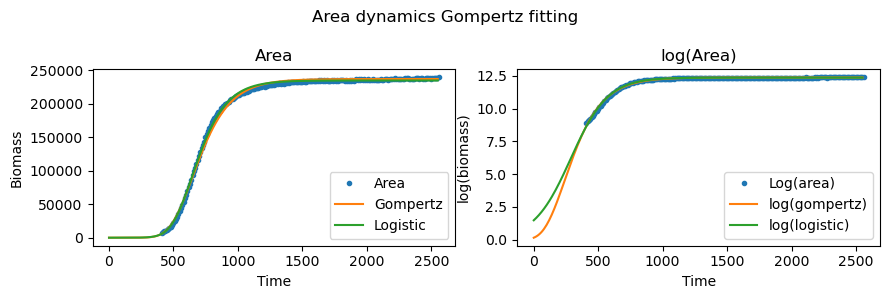

67
Gompertz Model:
  SSR: 0.2090
  R²: 0.9988
  AIC: -1493.1739
  BIC: -1483.0481

Logistic Model:
  SSR: 1.7570
  R²: 0.9901
  AIC: -1033.3208
  BIC: -1023.1950

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.73841644  0.02234901  8.58067175]
Logistic params are: [1.26906057e+01 2.01540496e-02 1.50115866e-16]


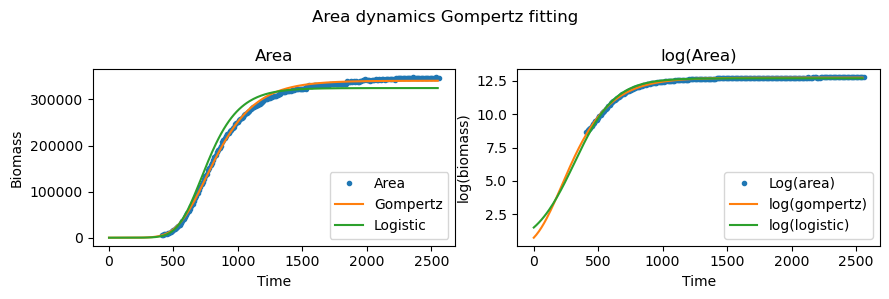

68
Gompertz Model:
  SSR: 0.2237
  R²: 0.9984
  AIC: -1478.5061
  BIC: -1468.3803

Logistic Model:
  SSR: 1.8203
  R²: 0.9867
  AIC: -1025.6729
  BIC: -1015.5470

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.24151183e+01 2.25237764e-02 1.85455548e-19]
Logistic params are: [1.23701094e+01 2.05594555e-02 1.11866792e-15]


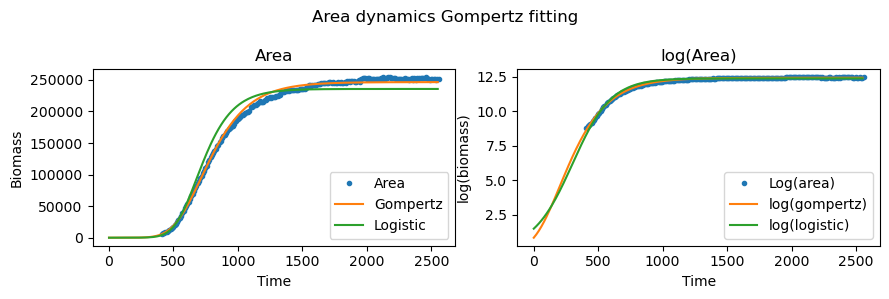

69
Gompertz Model:
  SSR: 0.2381
  R²: 0.9987
  AIC: -1465.0444
  BIC: -1454.9186

Logistic Model:
  SSR: 1.2053
  R²: 0.9932
  AIC: -1114.7282
  BIC: -1104.6024

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.25694857e+01 2.27948146e-02 2.69624472e+01]
Logistic params are: [1.25305936e+01 1.98396654e-02 7.47934518e-14]


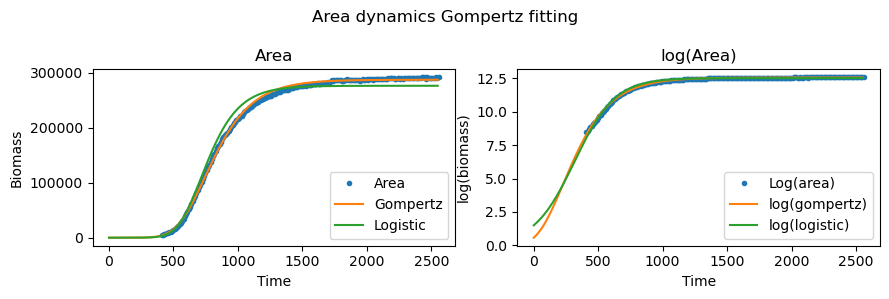

70
Gompertz Model:
  SSR: 0.3611
  R²: 0.9978
  AIC: -1375.1002
  BIC: -1364.9743

Logistic Model:
  SSR: 1.3885
  R²: 0.9917
  AIC: -1084.1598
  BIC: -1074.0340

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.26028055e+01 2.30853612e-02 2.35892048e+01]
Logistic params are: [1.25636291e+01 2.01961857e-02 2.06889573e-13]


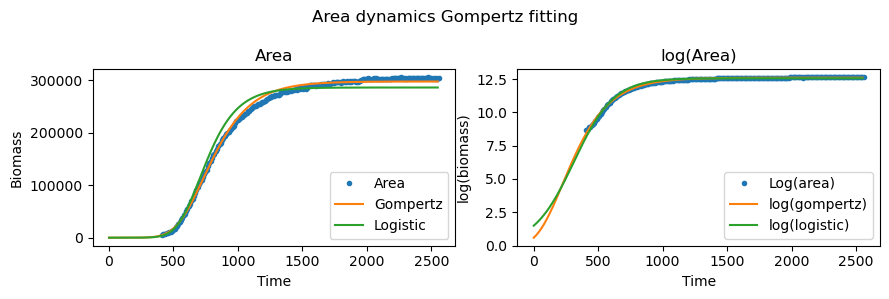

71
Gompertz Model:
  SSR: 0.2981
  R²: 0.9972
  AIC: -1416.5077
  BIC: -1406.3819

Logistic Model:
  SSR: 0.1770
  R²: 0.9984
  AIC: -1529.0823
  BIC: -1518.9565

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16628413e+01 3.25151794e-02 7.62916397e+01]
Logistic params are: [11.65914382  0.02420294  0.21752008]


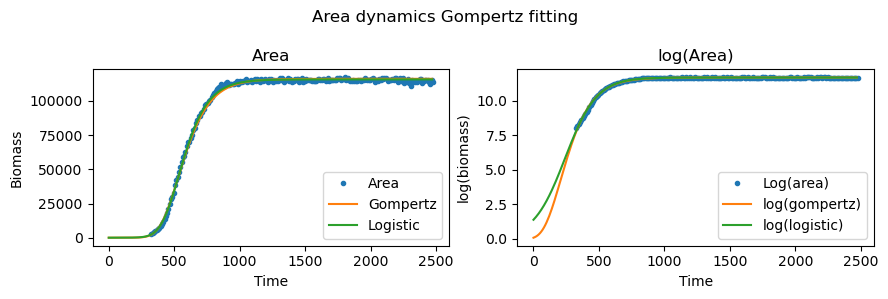

72
Gompertz Model:
  SSR: 0.4606
  R²: 0.9960
  AIC: -1322.4941
  BIC: -1312.3683

Logistic Model:
  SSR: 0.2895
  R²: 0.9975
  AIC: -1422.7884
  BIC: -1412.6626

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16475629e+01 3.14563386e-02 7.20558139e+01]
Logistic params are: [1.16421374e+01 2.37675977e-02 2.29167064e-14]


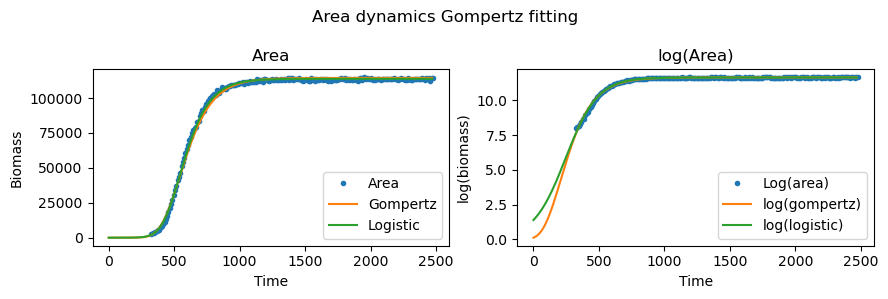

73
Gompertz Model:
  SSR: 0.6109
  R²: 0.9966
  AIC: -1261.5028
  BIC: -1251.3769

Logistic Model:
  SSR: 0.4340
  R²: 0.9976
  AIC: -1335.3621
  BIC: -1325.2362

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.19072918e+01 3.18011687e-02 1.01891603e+02]
Logistic params are: [1.19012917e+01 2.41960574e-02 3.26687320e+01]


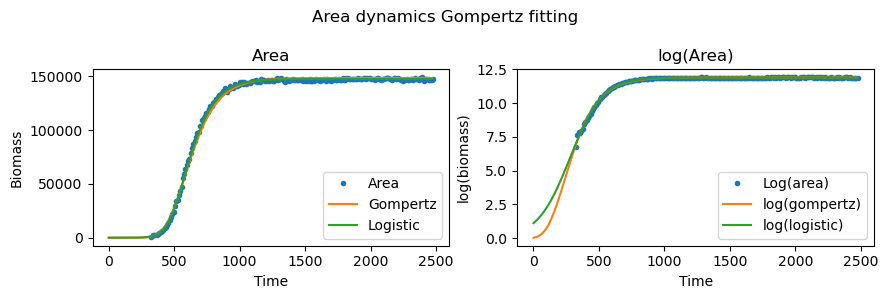

74
Gompertz Model:
  SSR: 0.6519
  R²: 0.9958
  AIC: -1247.4797
  BIC: -1237.3538

Logistic Model:
  SSR: 0.4129
  R²: 0.9973
  AIC: -1346.1377
  BIC: -1336.0119

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.18563241e+01 3.16467138e-02 8.87309585e+01]
Logistic params are: [11.850795    0.02394942 16.90435672]


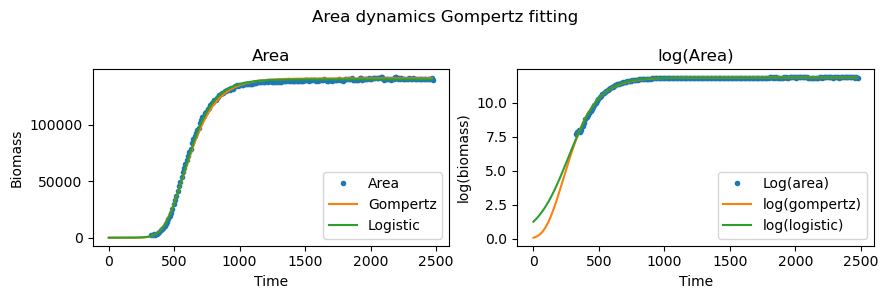

75
Gompertz Model:
  SSR: 0.3284
  R²: 0.9977
  AIC: -1395.5497
  BIC: -1385.4239

Logistic Model:
  SSR: 0.1755
  R²: 0.9988
  AIC: -1530.9139
  BIC: -1520.7881

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.21161272e+01 3.31755229e-02 8.71179618e+01]
Logistic params are: [12.11125529  0.02494159 14.20128413]


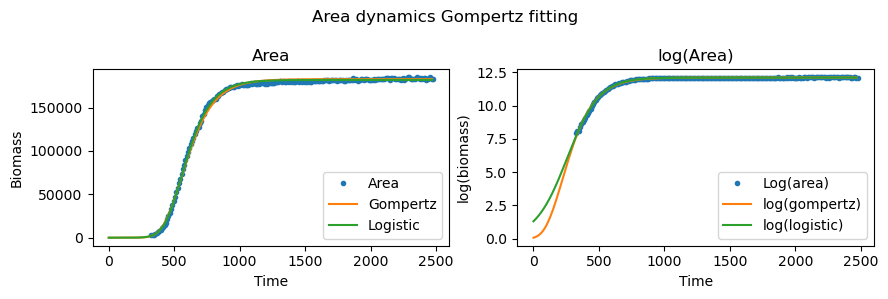

76
Gompertz Model:
  SSR: 0.2885
  R²: 0.9981
  AIC: -1423.5423
  BIC: -1413.4164

Logistic Model:
  SSR: 0.1146
  R²: 0.9993
  AIC: -1622.8944
  BIC: -1612.7686

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.22288895e+01 3.33470437e-02 9.01072252e+01]
Logistic params are: [12.22385727  0.02511548 17.76093775]


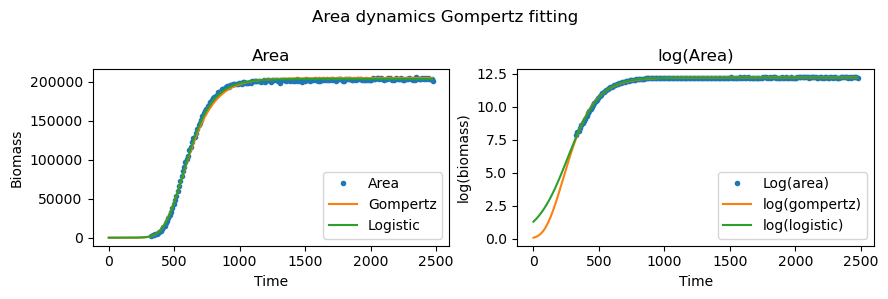

77
Gompertz Model:
  SSR: 0.4647
  R²: 0.9961
  AIC: -1320.6150
  BIC: -1310.4891

Logistic Model:
  SSR: 0.3221
  R²: 0.9973
  AIC: -1399.7984
  BIC: -1389.6726

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15203966e+01 3.02934771e-02 6.78027472e+01]
Logistic params are: [1.15130674e+01 2.32248843e-02 2.05356447e-16]


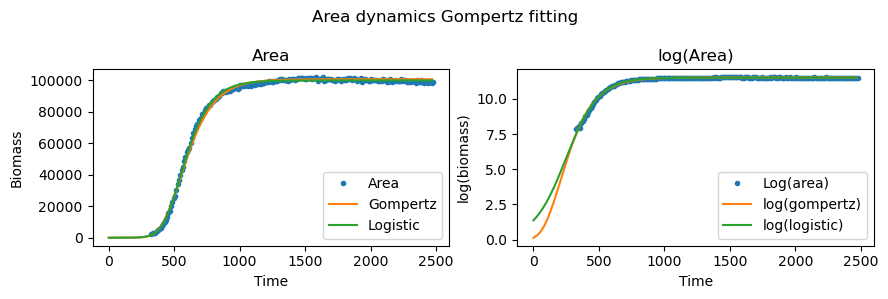

78
Gompertz Model:
  SSR: 0.4907
  R²: 0.9949
  AIC: -1308.8314
  BIC: -1298.7055

Logistic Model:
  SSR: 0.4771
  R²: 0.9951
  AIC: -1314.9196
  BIC: -1304.7938

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.13675328e+01 3.01338482e-02 5.54141913e+01]
Logistic params are: [1.13570942e+01 2.37701688e-02 1.40779986e-17]


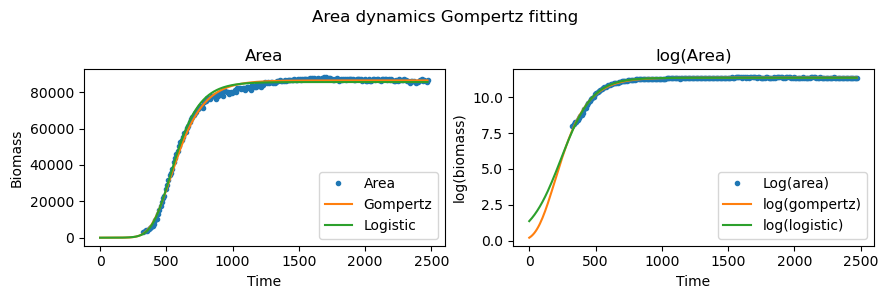

79
Gompertz Model:
  SSR: 0.2792
  R²: 0.9973
  AIC: -1430.6664
  BIC: -1420.5405

Logistic Model:
  SSR: 0.2967
  R²: 0.9971
  AIC: -1417.5345
  BIC: -1407.4087

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.14062184e+01 3.00083244e-02 5.69101108e+01]
Logistic params are: [1.13958113e+01 2.36149854e-02 1.75784152e-17]


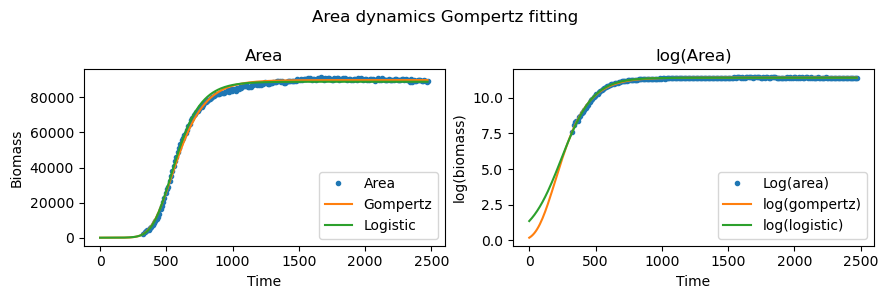

80
Gompertz Model:
  SSR: 0.1955
  R²: 0.9983
  AIC: -1507.6671
  BIC: -1497.5413

Logistic Model:
  SSR: 0.1773
  R²: 0.9984
  AIC: -1528.7598
  BIC: -1518.6340

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15914122e+01 3.11670591e-02 6.92813199e+01]
Logistic params are: [1.15847186e+01 2.37345031e-02 1.44998945e-25]


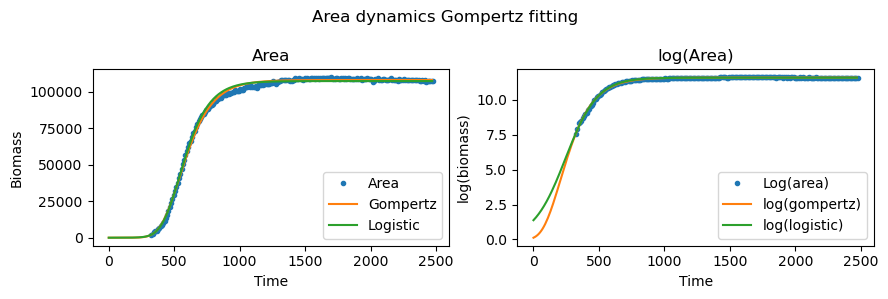

81
Gompertz Model:
  SSR: 0.9525
  R²: 0.9946
  AIC: -1165.5671
  BIC: -1155.4413

Logistic Model:
  SSR: 0.6719
  R²: 0.9962
  AIC: -1240.9489
  BIC: -1230.8231

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15968715e+01 2.72664602e-02 6.40432594e+01]
Logistic params are: [1.15850432e+01 2.14403486e-02 2.86168748e-16]


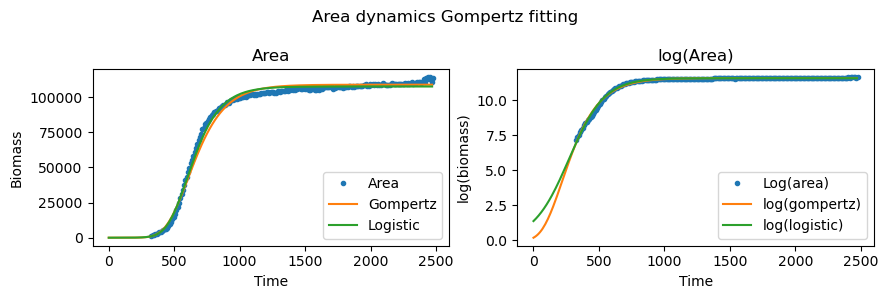

82
Gompertz Model:
  SSR: 0.8759
  R²: 0.9950
  AIC: -1183.6712
  BIC: -1173.5453

Logistic Model:
  SSR: 0.5354
  R²: 0.9970
  AIC: -1290.0185
  BIC: -1279.8927

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14500520e+01 2.76867622e-02 7.53620530e+01]
Logistic params are: [1.14432624e+01 2.11205059e-02 2.98832705e-10]


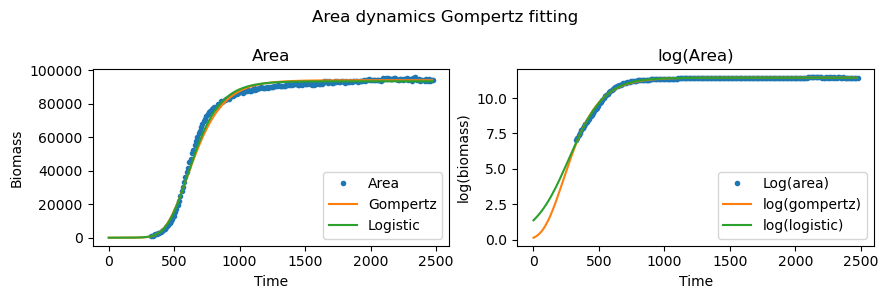

83
Gompertz Model:
  SSR: 0.9046
  R²: 0.9951
  AIC: -1176.7253
  BIC: -1166.5995

Logistic Model:
  SSR: 0.8900
  R²: 0.9952
  AIC: -1180.2248
  BIC: -1170.0990

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15714084e+01 2.98229420e-02 9.69155979e+01]
Logistic params are: [1.15652729e+01 2.26830016e-02 2.50639361e+01]


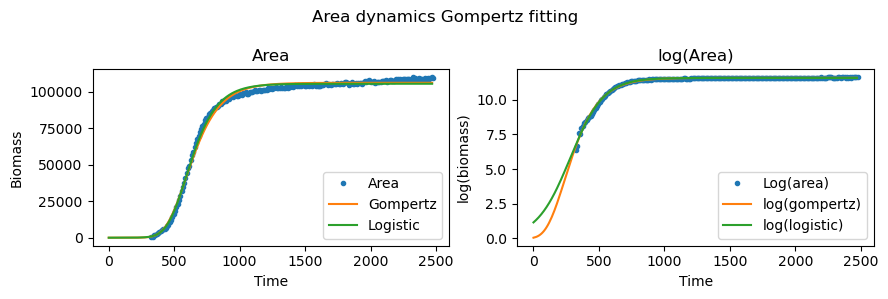

84
Gompertz Model:
  SSR: 1.3282
  R²: 0.9937
  AIC: -1093.7529
  BIC: -1083.6270

Logistic Model:
  SSR: 1.0433
  R²: 0.9951
  AIC: -1145.9000
  BIC: -1135.7742

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.17470007e+01 2.87169065e-02 9.07359378e+01]
Logistic params are: [11.73992008  0.02197974 18.0354668 ]


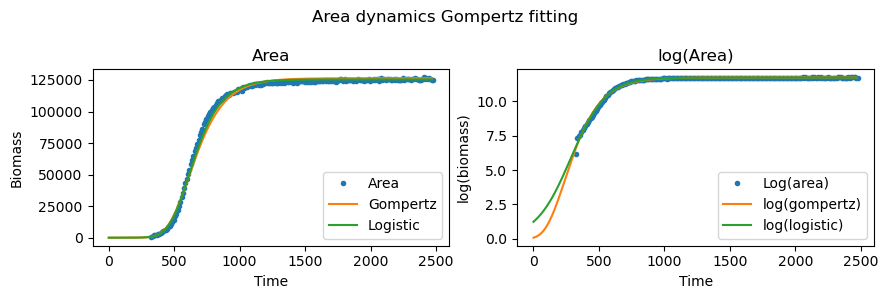

85
Gompertz Model:
  SSR: 1.7211
  R²: 0.9926
  AIC: -1037.7770
  BIC: -1027.6512

Logistic Model:
  SSR: 1.0766
  R²: 0.9954
  AIC: -1139.1097
  BIC: -1128.9838

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.19135776e+01 2.75257617e-02 7.91517040e+01]
Logistic params are: [11.90523916  0.02119061  4.98228112]


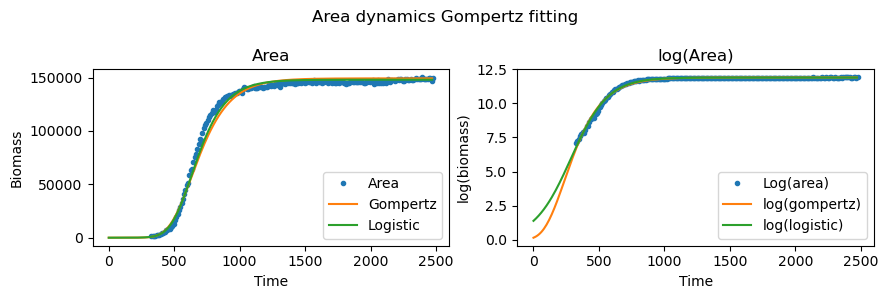

86
Gompertz Model:
  SSR: 0.8370
  R²: 0.9964
  AIC: -1193.4829
  BIC: -1183.3571

Logistic Model:
  SSR: 0.6988
  R²: 0.9970
  AIC: -1232.4586
  BIC: -1222.3327

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.20761151e+01 3.08541171e-02 1.06977534e+02]
Logistic params are: [1.20688020e+01 2.36741619e-02 3.85652789e+01]


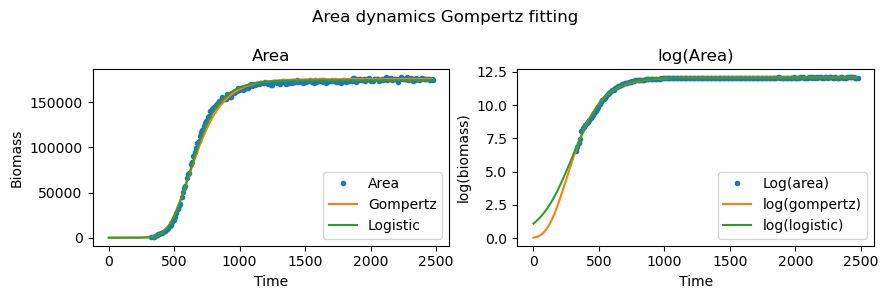

87
Gompertz Model:
  SSR: 1.0384
  R²: 0.9953
  AIC: -1146.9171
  BIC: -1136.7912

Logistic Model:
  SSR: 0.5462
  R²: 0.9975
  AIC: -1285.7094
  BIC: -1275.5836

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.18257511e+01 2.74636988e-02 7.83749039e+01]
Logistic params are: [11.81770846  0.02109077  3.35713731]


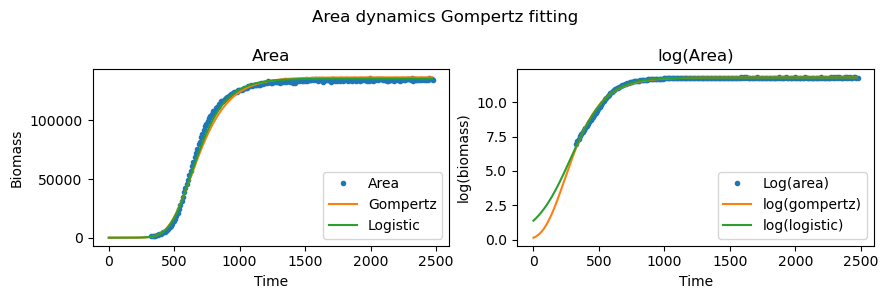

88
Gompertz Model:
  SSR: 0.9041
  R²: 0.9950
  AIC: -1176.8405
  BIC: -1166.7147

Logistic Model:
  SSR: 0.5470
  R²: 0.9970
  AIC: -1285.3680
  BIC: -1275.2421

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.18045621e+01 2.82846889e-02 6.94344082e+01]
Logistic params are: [1.17952103e+01 2.19039289e-02 6.14906117e-17]


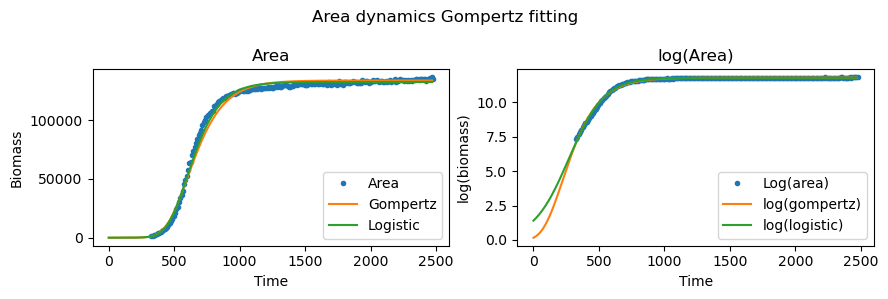

89
Gompertz Model:
  SSR: 1.8175
  R²: 0.9913
  AIC: -1026.0055
  BIC: -1015.8797

Logistic Model:
  SSR: 1.3582
  R²: 0.9935
  AIC: -1088.9236
  BIC: -1078.7978

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.17825174e+01 3.17196710e-02 1.16537052e+02]
Logistic params are: [1.17764892e+01 2.43263412e-02 5.16431569e+01]


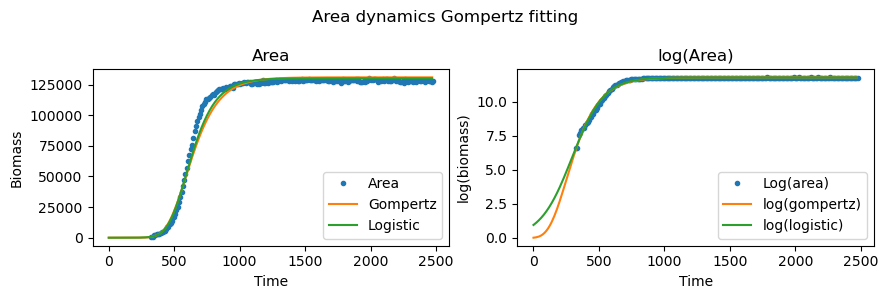

90
Gompertz Model:
  SSR: 0.7321
  R²: 0.9962
  AIC: -1222.4084
  BIC: -1212.2826

Logistic Model:
  SSR: 0.5110
  R²: 0.9974
  AIC: -1300.0930
  BIC: -1289.9671

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14766670e+01 3.17342262e-02 1.22788671e+02]
Logistic params are: [1.14710315e+01 2.42825888e-02 5.86861418e+01]


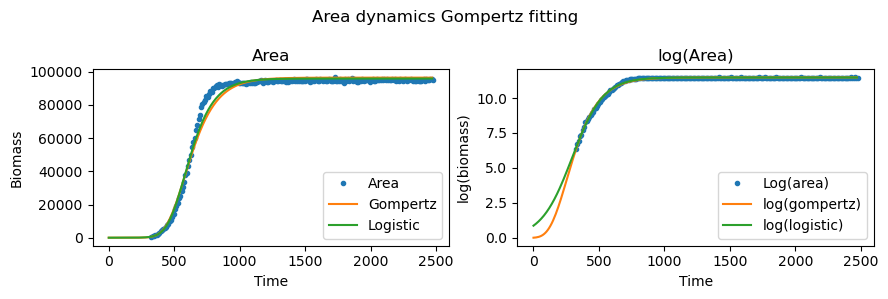

91
Gompertz Model:
  SSR: 1.8176
  R²: 0.9912
  AIC: -1025.9932
  BIC: -1015.8673

Logistic Model:
  SSR: 1.1715
  R²: 0.9943
  AIC: -1120.8720
  BIC: -1110.7462

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16321169e+01 2.90233704e-02 9.69003001e+01]
Logistic params are: [1.16252641e+01 2.22992109e-02 2.75195798e+01]


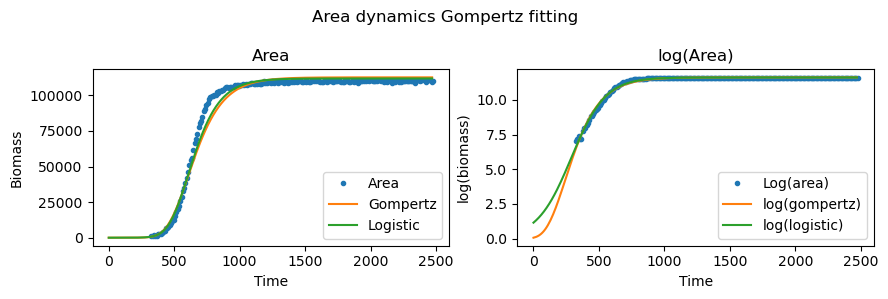

92
Gompertz Model:
  SSR: 0.2280
  R²: 0.9969
  AIC: -1474.3565
  BIC: -1464.2307

Logistic Model:
  SSR: 1.0662
  R²: 0.9857
  AIC: -1141.2096
  BIC: -1131.0837

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.11044448e+01 2.65156768e-02 5.10164048e-14]
Logistic params are: [1.10782181e+01 2.40469581e-02 6.61707518e-18]


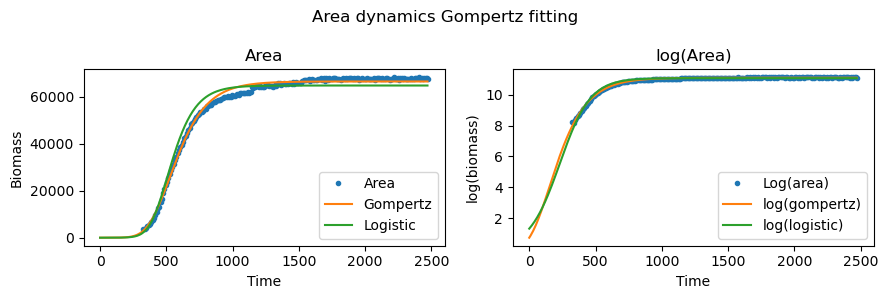

93
Gompertz Model:
  SSR: 0.8697
  R²: 0.9951
  AIC: -1185.2111
  BIC: -1175.0853

Logistic Model:
  SSR: 0.5397
  R²: 0.9969
  AIC: -1288.2855
  BIC: -1278.1597

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14365146e+01 2.79159858e-02 7.85017236e+01]
Logistic params are: [11.43003291  0.02126792  3.31747373]


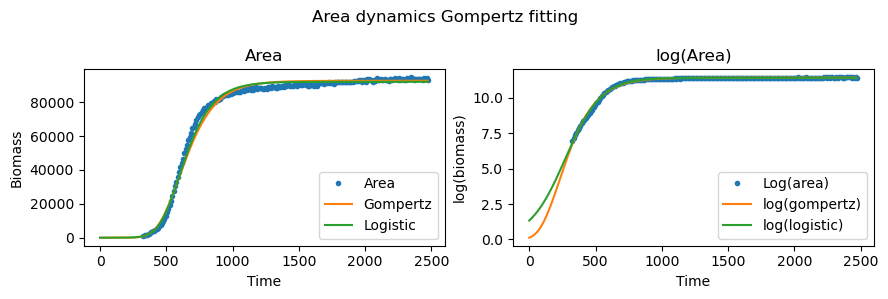

94
Gompertz Model:
  SSR: 0.7407
  R²: 0.9958
  AIC: -1219.8884
  BIC: -1209.7626

Logistic Model:
  SSR: 0.4375
  R²: 0.9975
  AIC: -1333.6243
  BIC: -1323.4985

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.13616370e+01 2.74450025e-02 7.57621249e+01]
Logistic params are: [1.13549528e+01 2.09210929e-02 3.55967986e-09]


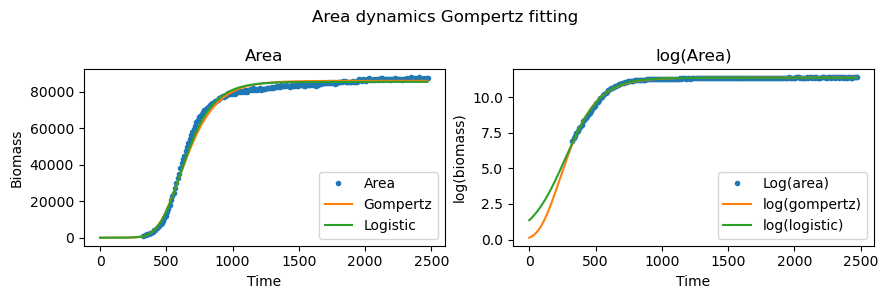

95
Gompertz Model:
  SSR: 0.9766
  R²: 0.9949
  AIC: -1160.1677
  BIC: -1150.0419

Logistic Model:
  SSR: 0.6843
  R²: 0.9964
  AIC: -1237.0027
  BIC: -1226.8769

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15832140e+01 2.83010249e-02 8.35732193e+01]
Logistic params are: [11.57617243  0.02162623  9.84774192]


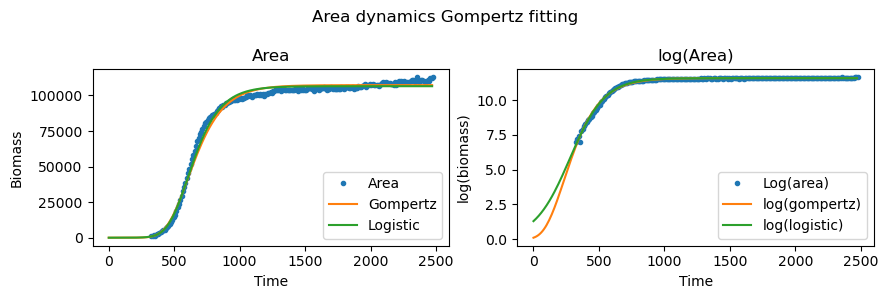

96
Gompertz Model:
  SSR: 0.1685
  R²: 0.9992
  AIC: -1539.7727
  BIC: -1529.6469

Logistic Model:
  SSR: 1.2956
  R²: 0.9936
  AIC: -1099.1143
  BIC: -1088.9884

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.63653509  0.02746463 22.78046433]
Logistic params are: [1.26023419e+01 2.39841375e-02 3.35883864e-15]


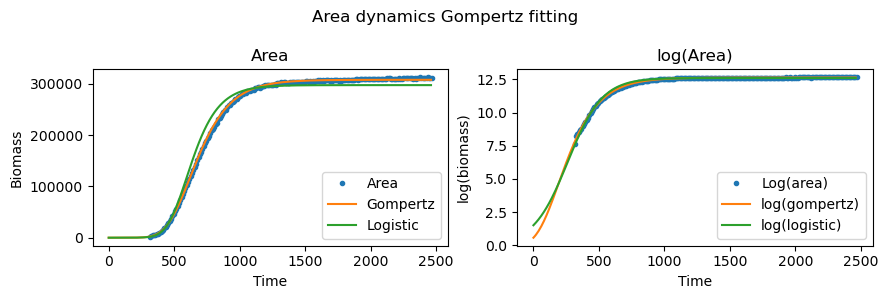

97
Gompertz Model:
  SSR: 0.1479
  R²: 0.9992
  AIC: -1567.8456
  BIC: -1557.7198

Logistic Model:
  SSR: 1.7352
  R²: 0.9907
  AIC: -1036.0118
  BIC: -1025.8859

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.42546859  0.02621889  7.23545967]
Logistic params are: [1.23850562e+01 2.37514195e-02 3.37407234e-15]


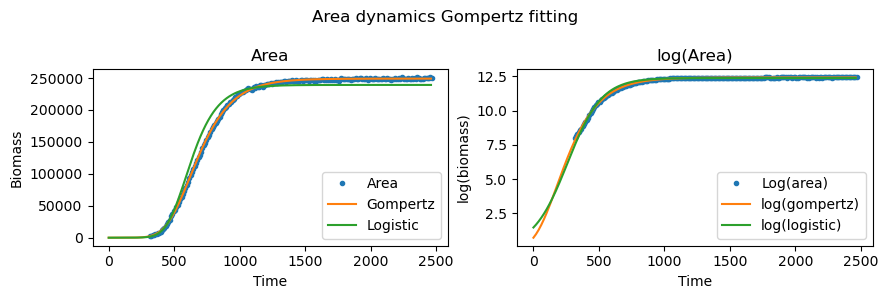

98
Gompertz Model:
  SSR: 0.1713
  R²: 0.9990
  AIC: -1536.1212
  BIC: -1525.9954

Logistic Model:
  SSR: 2.1391
  R²: 0.9880
  AIC: -990.8200
  BIC: -980.6941

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.21230495e+01 2.50610758e-02 2.97009539e-23]
Logistic params are: [1.20792926e+01 2.31089474e-02 4.41949476e-16]


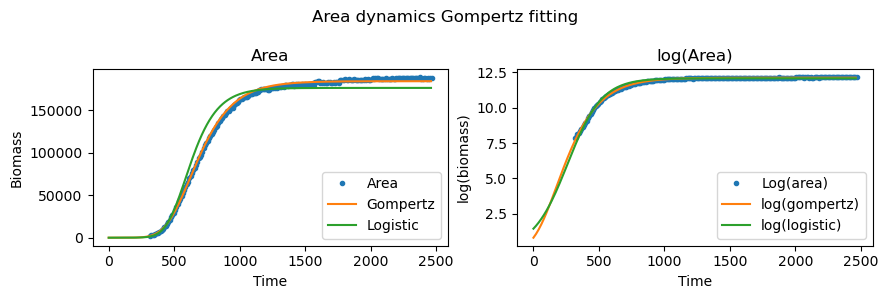

99
Gompertz Model:
  SSR: 0.2177
  R²: 0.9988
  AIC: -1484.3460
  BIC: -1474.2201

Logistic Model:
  SSR: 2.0285
  R²: 0.9891
  AIC: -1002.2877
  BIC: -992.1619

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.31935785  0.02549626  1.09320233]
Logistic params are: [1.22755205e+01 2.34487319e-02 1.20466380e-15]


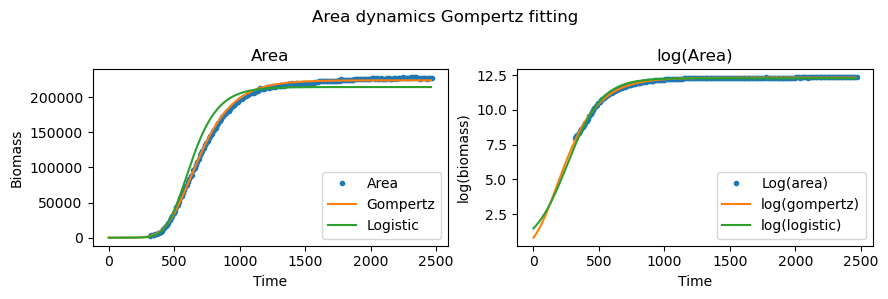

100
Gompertz Model:
  SSR: 0.3507
  R²: 0.9982
  AIC: -1381.4196
  BIC: -1371.2938

Logistic Model:
  SSR: 3.1930
  R²: 0.9836
  AIC: -904.2919
  BIC: -894.1660

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.21090443e+01 2.43322031e-02 1.20233158e-20]
Logistic params are: [1.20620991e+01 2.24882981e-02 7.55326025e-16]


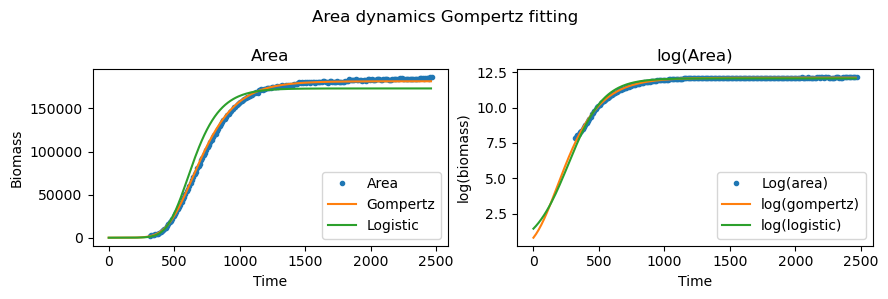

101
Gompertz Model:
  SSR: 0.8093
  R²: 0.9959
  AIC: -1200.7517
  BIC: -1190.6259

Logistic Model:
  SSR: 0.6461
  R²: 0.9967
  AIC: -1249.4121
  BIC: -1239.2863

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.21602799e+01 3.25187507e-02 9.45708627e+01]
Logistic params are: [1.21543312e+01 2.47372278e-02 2.54775352e+01]


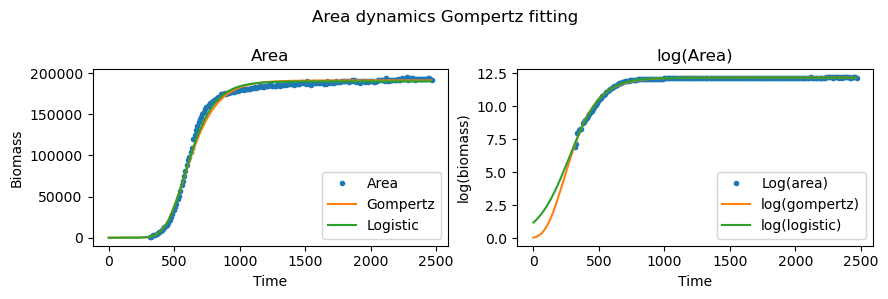

102
Gompertz Model:
  SSR: 0.8542
  R²: 0.9937
  AIC: -1189.1115
  BIC: -1178.9856

Logistic Model:
  SSR: 2.0668
  R²: 0.9849
  AIC: -998.2440
  BIC: -988.1182

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.82281404  0.02609524  3.34600592]
Logistic params are: [1.17895237e+01 2.36935000e-02 9.85319182e-18]


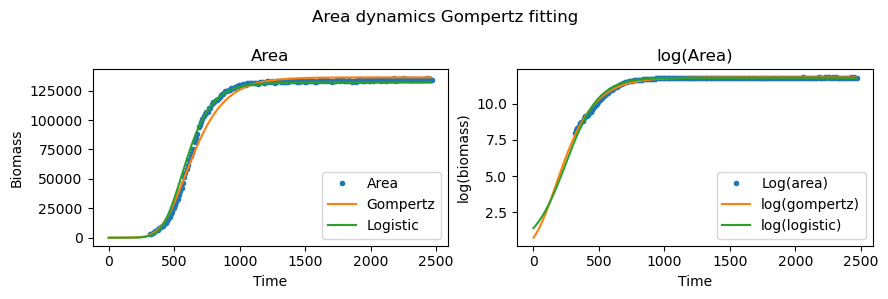

103
Gompertz Model:
  SSR: 0.6677
  R²: 0.9959
  AIC: -1242.3046
  BIC: -1232.1788

Logistic Model:
  SSR: 0.8690
  R²: 0.9947
  AIC: -1185.3913
  BIC: -1175.2654

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.18209954e+01 2.78473654e-02 4.36982581e+01]
Logistic params are: [1.18017715e+01 2.29520154e-02 1.02507778e-18]


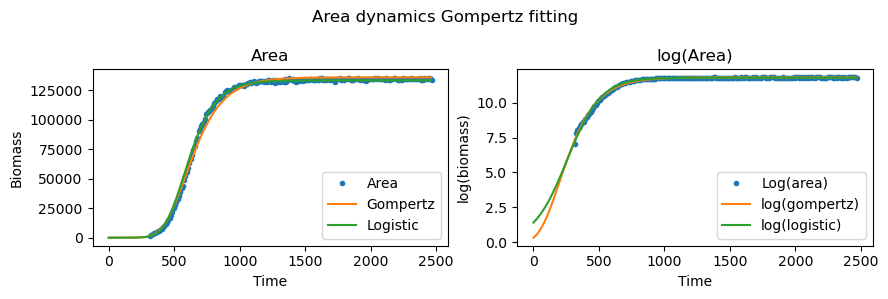

104
Gompertz Model:
  SSR: 0.9239
  R²: 0.9936
  AIC: -1172.1585
  BIC: -1162.0327

Logistic Model:
  SSR: 1.6924
  R²: 0.9882
  AIC: -1041.4167
  BIC: -1031.2909

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.81844637  0.02679922 18.39807885]
Logistic params are: [1.17904096e+01 2.34839366e-02 2.14540994e-15]


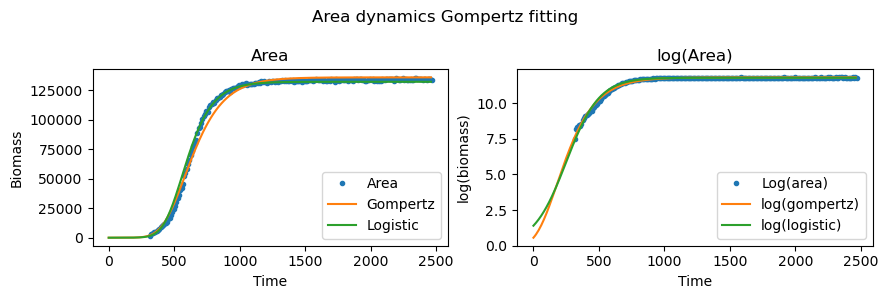

105
Gompertz Model:
  SSR: 0.6351
  R²: 0.9954
  AIC: -1253.1340
  BIC: -1243.0081

Logistic Model:
  SSR: 1.3876
  R²: 0.9901
  AIC: -1084.3027
  BIC: -1074.1769

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.57370703  0.0261202  17.92802339]
Logistic params are: [1.15454618e+01 2.29326903e-02 2.82812456e-15]


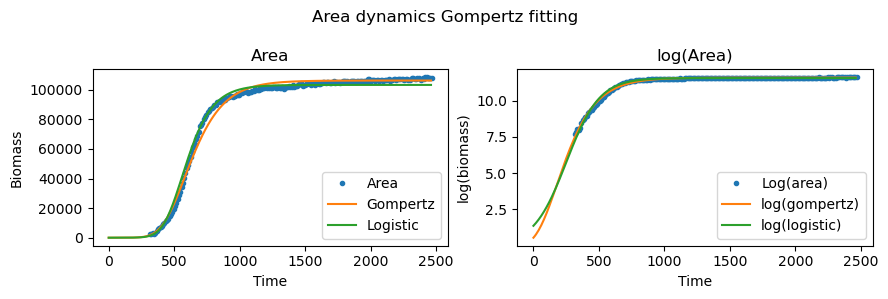

106
Gompertz Model:
  SSR: 0.5982
  R²: 0.9957
  AIC: -1266.0391
  BIC: -1255.9132

Logistic Model:
  SSR: 0.5157
  R²: 0.9963
  AIC: -1298.0845
  BIC: -1287.9587

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.13640572e+01 2.86741879e-02 5.85947387e+01]
Logistic params are: [1.13528719e+01 2.26109690e-02 2.65492101e-16]


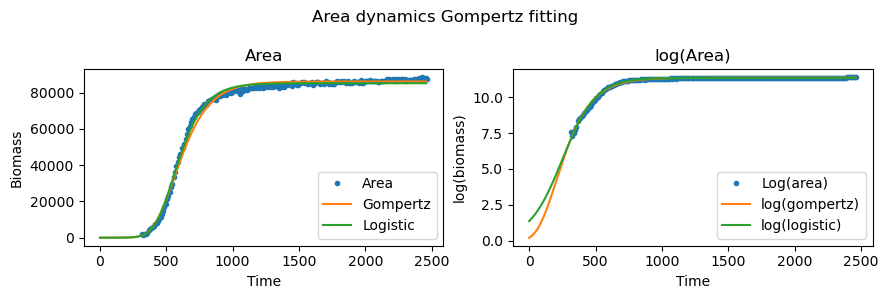

107
Gompertz Model:
  SSR: 0.8339
  R²: 0.9939
  AIC: -1194.2950
  BIC: -1184.1692

Logistic Model:
  SSR: 0.7399
  R²: 0.9946
  AIC: -1220.1372
  BIC: -1210.0114

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14516240e+01 2.84167011e-02 5.07795247e+01]
Logistic params are: [1.1437744e+01 2.2873436e-02 4.1152253e-15]


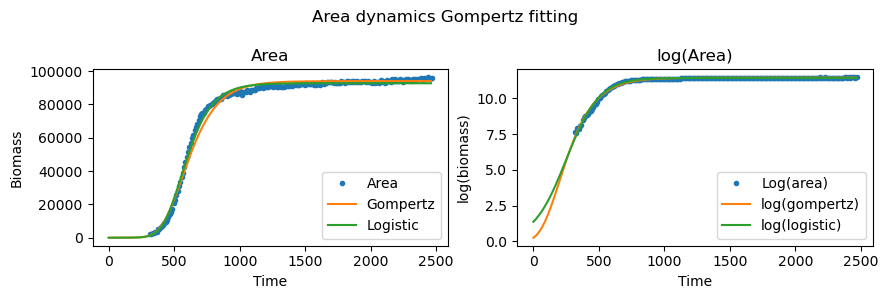

108
Gompertz Model:
  SSR: 1.8227
  R²: 0.9898
  AIC: -1025.3951
  BIC: -1015.2693

Logistic Model:
  SSR: 1.2285
  R²: 0.9932
  AIC: -1110.6159
  BIC: -1100.4901

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.22118287e+01 3.96280986e-02 1.37348342e+02]
Logistic params are: [1.22073798e+01 3.02982801e-02 8.25427767e+01]


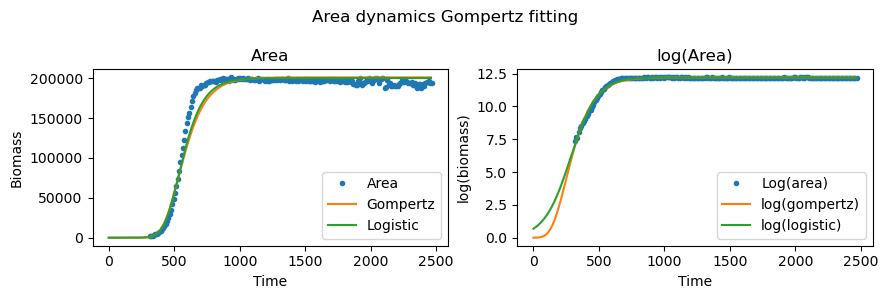

109
Gompertz Model:
  SSR: 1.0289
  R²: 0.9905
  AIC: -1148.9062
  BIC: -1138.7804

Logistic Model:
  SSR: 0.7540
  R²: 0.9930
  AIC: -1216.0597
  BIC: -1205.9338

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14764971e+01 3.49095597e-02 9.41028467e+01]
Logistic params are: [1.14733400e+01 2.60975136e-02 2.64473721e+01]


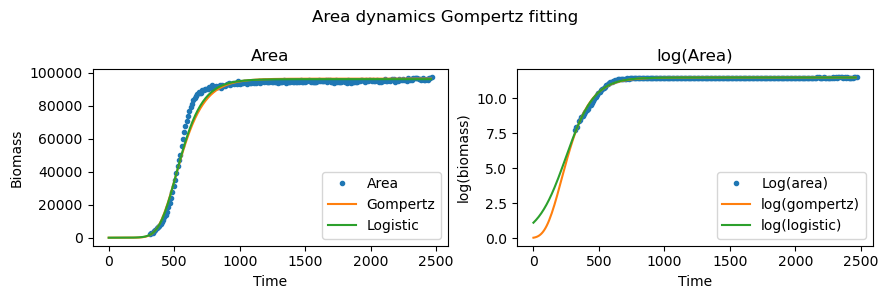

110
Gompertz Model:
  SSR: 0.7548
  R²: 0.9939
  AIC: -1215.8256
  BIC: -1205.6997

Logistic Model:
  SSR: 0.5118
  R²: 0.9958
  AIC: -1299.7280
  BIC: -1289.6022

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14966822e+01 3.63631642e-02 1.13543440e+02]
Logistic params are: [1.14931609e+01 2.73641041e-02 5.11087637e+01]


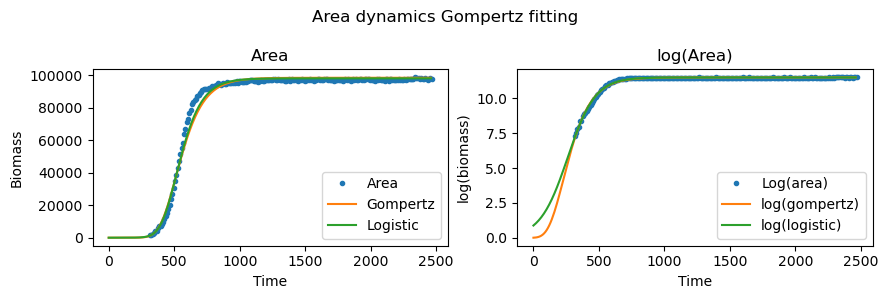

111
Gompertz Model:
  SSR: 1.6472
  R²: 0.9784
  AIC: -1047.2651
  BIC: -1037.1393

Logistic Model:
  SSR: 2.2210
  R²: 0.9709
  AIC: -982.7025
  BIC: -972.5767

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.59623366  0.02954931  8.39776373]
Logistic params are: [1.15755493e+01 2.61140832e-02 2.33581923e-17]


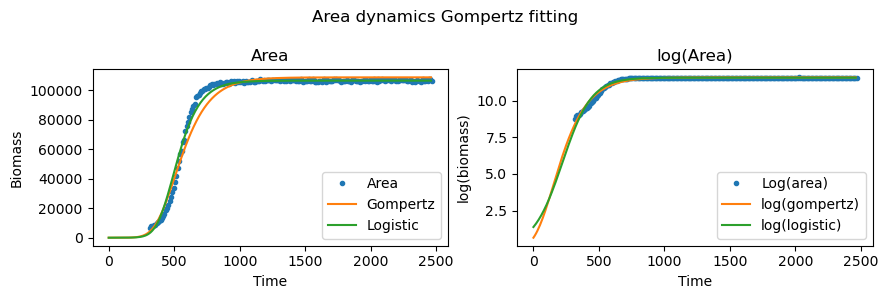

112
Gompertz Model:
  SSR: 1.3809
  R²: 0.9893
  AIC: -1085.3430
  BIC: -1075.2171

Logistic Model:
  SSR: 0.9755
  R²: 0.9924
  AIC: -1160.4180
  BIC: -1150.2921

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.20903216e+01 3.81370341e-02 1.09011108e+02]
Logistic params are: [1.20868304e+01 2.86766900e-02 4.61229323e+01]


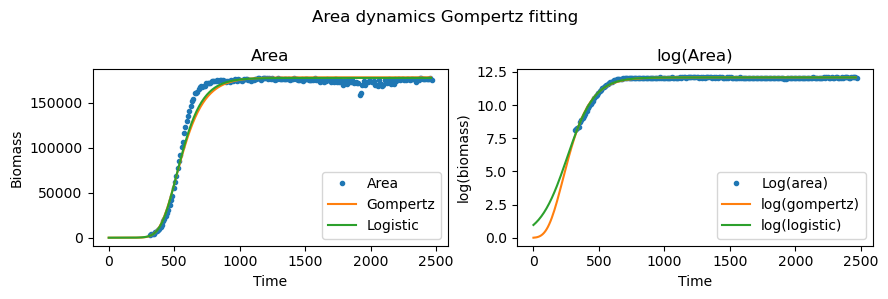

113
Gompertz Model:
  SSR: 1.0176
  R²: 0.9916
  AIC: -1151.2969
  BIC: -1141.1711

Logistic Model:
  SSR: 0.7536
  R²: 0.9938
  AIC: -1216.1596
  BIC: -1206.0338

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.17745494e+01 3.79392788e-02 1.14015846e+02]
Logistic params are: [1.17713802e+01 2.84533022e-02 5.15037392e+01]


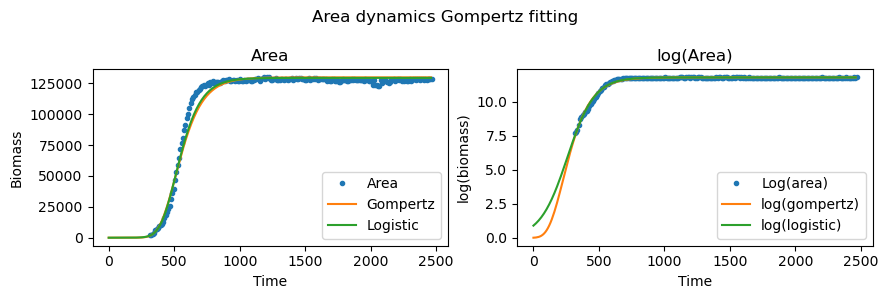

114
Gompertz Model:
  SSR: 0.5954
  R²: 0.9964
  AIC: -1267.0540
  BIC: -1256.9281

Logistic Model:
  SSR: 0.6692
  R²: 0.9960
  AIC: -1241.8251
  BIC: -1231.6992

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.18198214e+01 2.84978143e-02 5.37299657e+01]
Logistic params are: [1.18047579e+01 2.28791640e-02 4.78588869e-19]


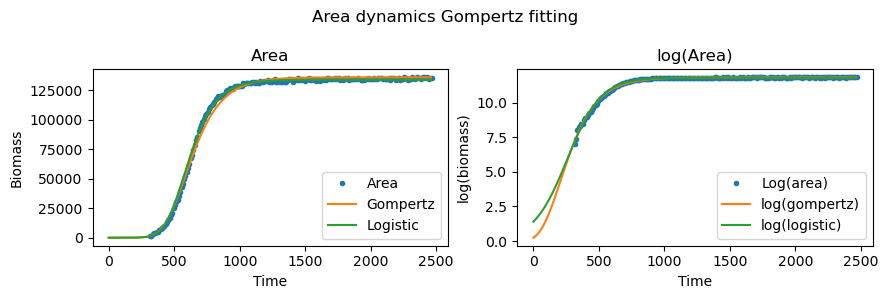

115
Gompertz Model:
  SSR: 0.9079
  R²: 0.9931
  AIC: -1175.9241
  BIC: -1165.7982

Logistic Model:
  SSR: 1.3018
  R²: 0.9901
  AIC: -1098.0944
  BIC: -1087.9686

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.11998890e+01 2.60184245e-02 2.89968066e+01]
Logistic params are: [1.11769727e+01 2.22152681e-02 2.07466533e-18]


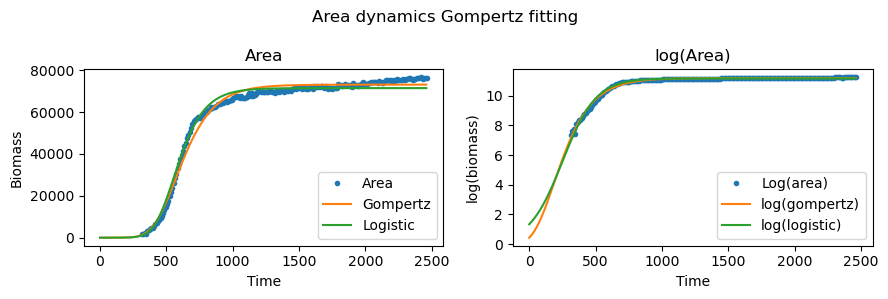

116
Gompertz Model:
  SSR: 0.3457
  R²: 0.9965
  AIC: -2799.3415
  BIC: -2787.3821

Logistic Model:
  SSR: 0.2434
  R²: 0.9975
  AIC: -2938.9951
  BIC: -2927.0357

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.20396491e+01 3.20848495e-02 8.98078042e+01]
Logistic params are: [12.0381615   0.02359093  4.24716821]


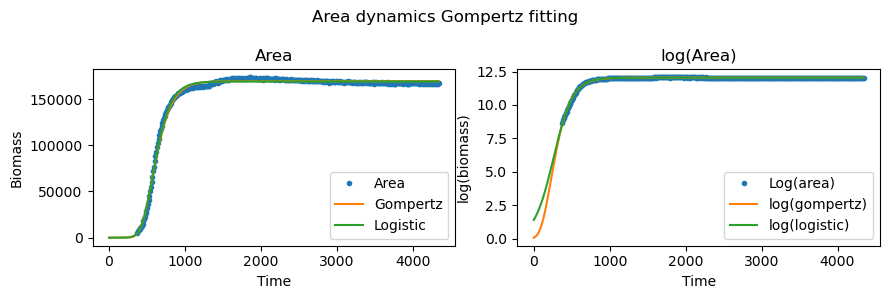

117
Gompertz Model:
  SSR: 0.4638
  R²: 0.9953
  AIC: -2682.3883
  BIC: -2670.4290

Logistic Model:
  SSR: 0.3389
  R²: 0.9966
  AIC: -2807.2194
  BIC: -2795.2601

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.21061045e+01 3.42347771e-02 1.09641386e+02]
Logistic params are: [1.21046352e+01 2.52322366e-02 3.01711887e+01]


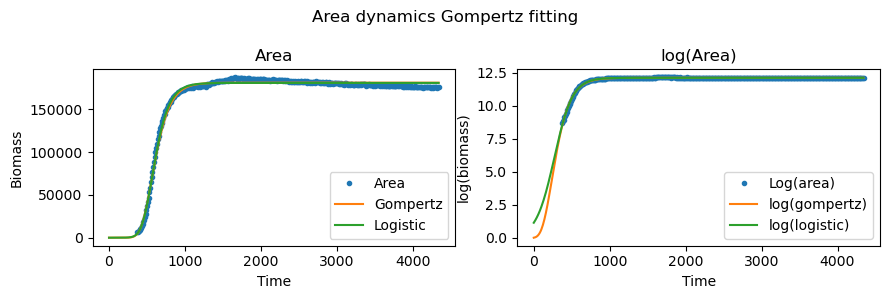

118
Gompertz Model:
  SSR: 0.5783
  R²: 0.9956
  AIC: -2594.5997
  BIC: -2582.6403

Logistic Model:
  SSR: 0.3710
  R²: 0.9972
  AIC: -2771.2066
  BIC: -2759.2473

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.21994328e+01 3.30292108e-02 1.15874115e+02]
Logistic params are: [1.21975306e+01 2.45857113e-02 3.77118998e+01]


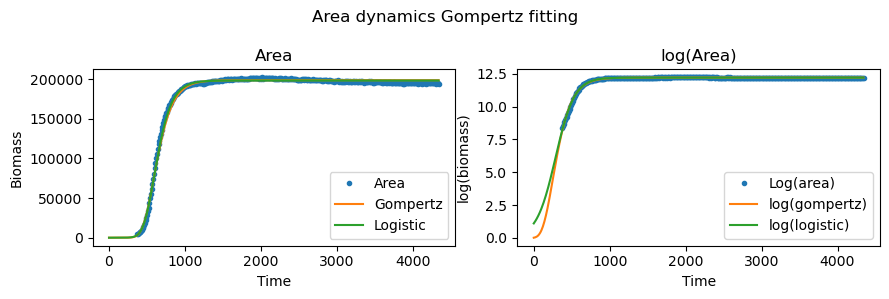

119
Gompertz Model:
  SSR: 0.6313
  R²: 0.9947
  AIC: -2559.6621
  BIC: -2547.7027

Logistic Model:
  SSR: 0.4316
  R²: 0.9964
  AIC: -2711.0502
  BIC: -2699.0909

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.19698473e+01 3.40897246e-02 1.27443977e+02]
Logistic params are: [1.19681006e+01 2.53675014e-02 5.30078008e+01]


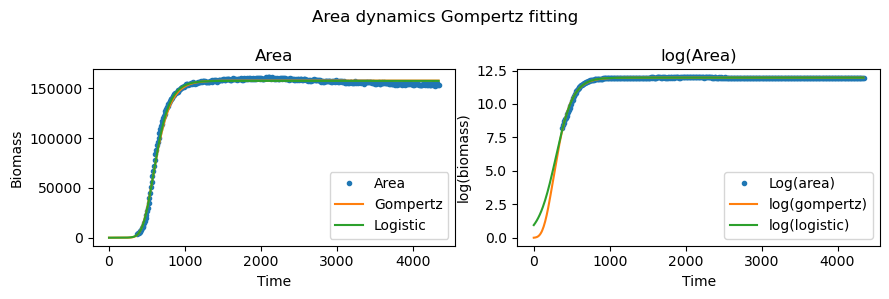

120
Gompertz Model:
  SSR: 1.4315
  R²: 0.9926
  AIC: -2233.8476
  BIC: -2221.8883

Logistic Model:
  SSR: 0.9386
  R²: 0.9952
  AIC: -2401.8187
  BIC: -2389.8593

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.17734580e+01 3.03465576e-02 1.38407167e+02]
Logistic params are: [1.17706278e+01 2.30979824e-02 6.70966635e+01]


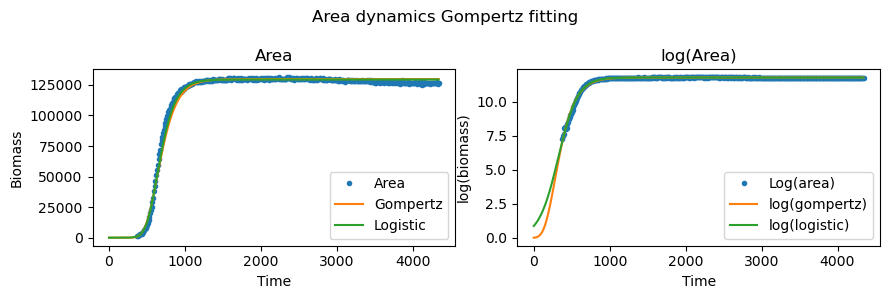

121
Gompertz Model:
  SSR: 1.0366
  R²: 0.9950
  AIC: -2362.2839
  BIC: -2350.3245

Logistic Model:
  SSR: 0.6316
  R²: 0.9969
  AIC: -2559.4954
  BIC: -2547.5360

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.22136644e+01 2.67812500e-02 8.20605885e+01]
Logistic params are: [1.22094524e+01 2.04786951e-02 1.35726912e-14]


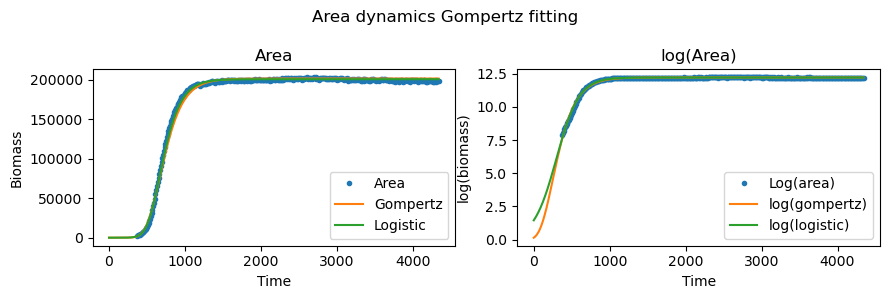

122
Gompertz Model:
  SSR: 0.4464
  R²: 0.9970
  AIC: -2697.6088
  BIC: -2685.6494

Logistic Model:
  SSR: 0.2713
  R²: 0.9982
  AIC: -2895.7863
  BIC: -2883.8269

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.24136752e+01 3.00251196e-02 8.40265541e+01]
Logistic params are: [1.24108791e+01 2.25171933e-02 2.56420201e-13]


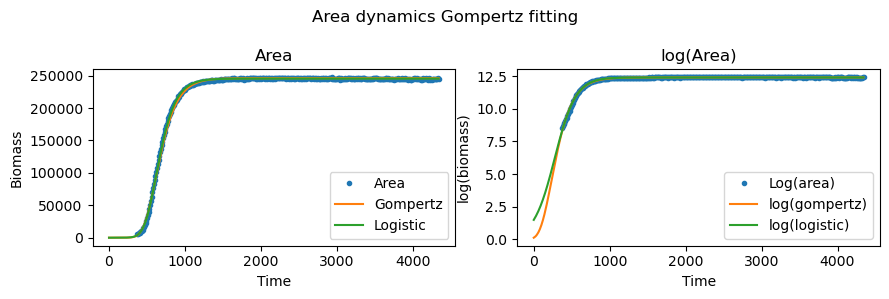

123
Gompertz Model:
  SSR: 0.6515
  R²: 0.9963
  AIC: -2547.1295
  BIC: -2535.1701

Logistic Model:
  SSR: 0.3835
  R²: 0.9978
  AIC: -2758.0321
  BIC: -2746.0727

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.25456546e+01 3.14058106e-02 1.09681380e+02]
Logistic params are: [1.25430771e+01 2.35750163e-02 2.93599882e+01]


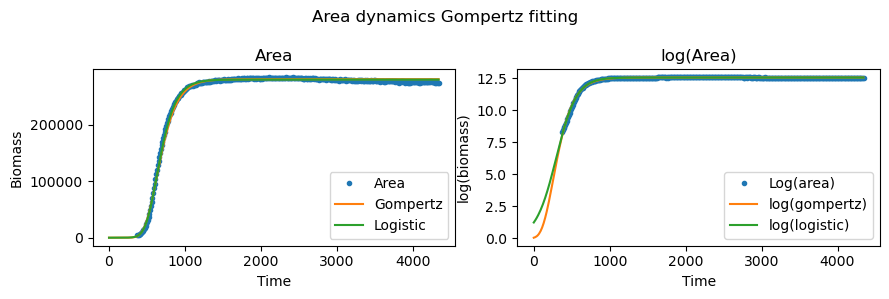

124
Gompertz Model:
  SSR: 0.4868
  R²: 0.9965
  AIC: -2663.1559
  BIC: -2651.1965

Logistic Model:
  SSR: 0.3069
  R²: 0.9978
  AIC: -2846.6906
  BIC: -2834.7313

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.24913531e+01 3.18801894e-02 9.80426630e+01]
Logistic params are: [12.48925211  0.02370582 14.51770274]


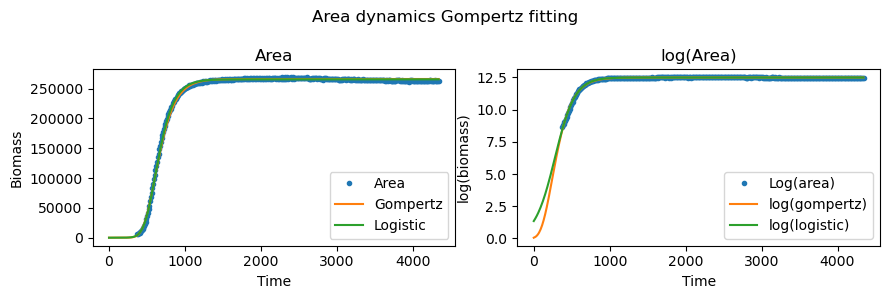

125
Gompertz Model:
  SSR: 7.4309
  R²: 0.9879
  AIC: -1578.3588
  BIC: -1566.3995

Logistic Model:
  SSR: 5.2751
  R²: 0.9914
  AIC: -1714.7385
  BIC: -1702.7791

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.13969816e+01 1.54691170e-02 4.38282896e+01]
Logistic params are: [1.13731305e+01 1.33926199e-02 3.96581126e-18]


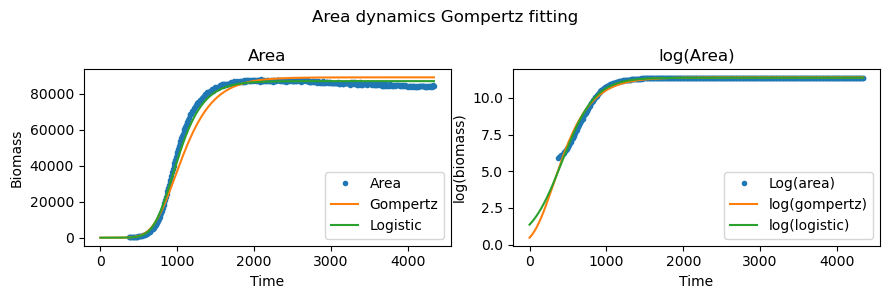

126
Gompertz Model:
  SSR: 3.7523
  R²: 0.9903
  AIC: -1850.3007
  BIC: -1838.3413

Logistic Model:
  SSR: 5.8044
  R²: 0.9850
  AIC: -1676.6770
  BIC: -1664.7176

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.80091155  0.01773369  5.24762556]
Logistic params are: [1.17716900e+01 1.62688310e-02 1.24546939e-14]


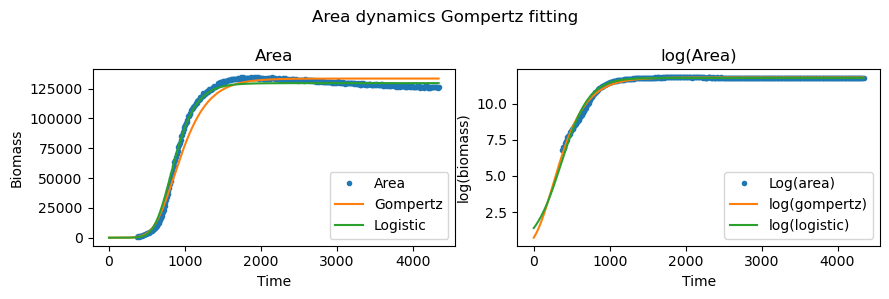

127
Gompertz Model:
  SSR: 2.5989
  R²: 0.9930
  AIC: -1996.4787
  BIC: -1984.5194

Logistic Model:
  SSR: 3.7146
  R²: 0.9900
  AIC: -1854.3231
  BIC: -1842.3638

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.19717971e+01 1.90095553e-02 2.17357456e+01]
Logistic params are: [1.19474574e+01 1.69041197e-02 4.99446543e-13]


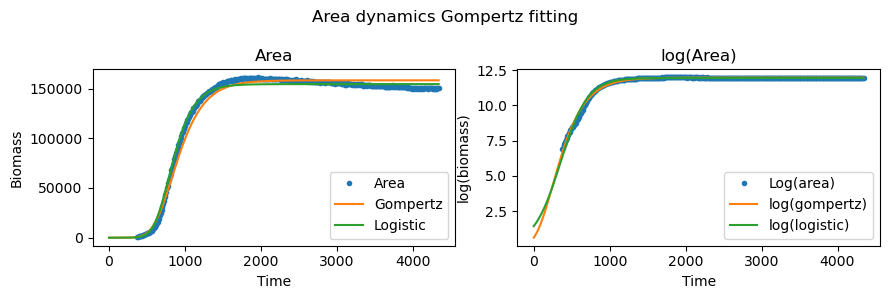

128
Gompertz Model:
  SSR: 2.2621
  R²: 0.9941
  AIC: -2051.7232
  BIC: -2039.7639

Logistic Model:
  SSR: 2.1354
  R²: 0.9944
  AIC: -2074.6676
  BIC: -2062.7082

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.20054328e+01 2.00180497e-02 4.77182738e+01]
Logistic params are: [1.19882551e+01 1.69278099e-02 3.94830001e-14]


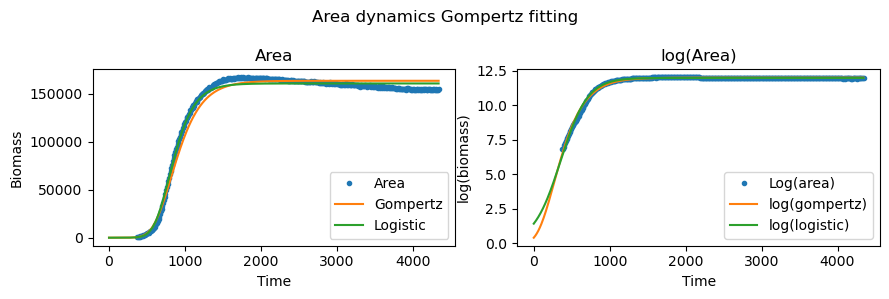

129
Gompertz Model:
  SSR: 2.3246
  R²: 0.9964
  AIC: -2040.8680
  BIC: -2028.9087

Logistic Model:
  SSR: 10.4168
  R²: 0.9839
  AIC: -1443.9287
  BIC: -1431.9693

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.27569611e+01 1.66757625e-02 8.54175070e-20]
Logistic params are: [1.27104122e+01 1.55904383e-02 1.36158314e-16]


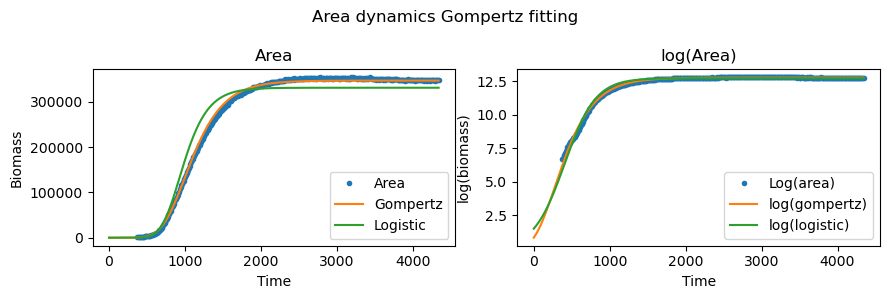

130
Gompertz Model:
  SSR: 2.7592
  R²: 0.9957
  AIC: -1972.6627
  BIC: -1960.7033

Logistic Model:
  SSR: 6.2506
  R²: 0.9904
  AIC: -1647.2040
  BIC: -1635.2446

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.45394669  0.0163985   7.58751669]
Logistic params are: [1.24114401e+01 1.51403936e-02 2.97421580e-15]


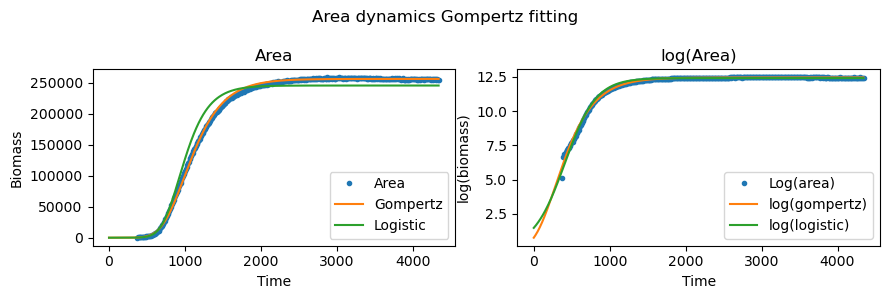

131
Gompertz Model:
  SSR: 2.3234
  R²: 0.9964
  AIC: -2041.0859
  BIC: -2029.1265

Logistic Model:
  SSR: 6.1538
  R²: 0.9904
  AIC: -1653.4118
  BIC: -1641.4525

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.44843652  0.01663107 12.62200894]
Logistic params are: [1.24076995e+01 1.52277188e-02 3.52686360e-15]


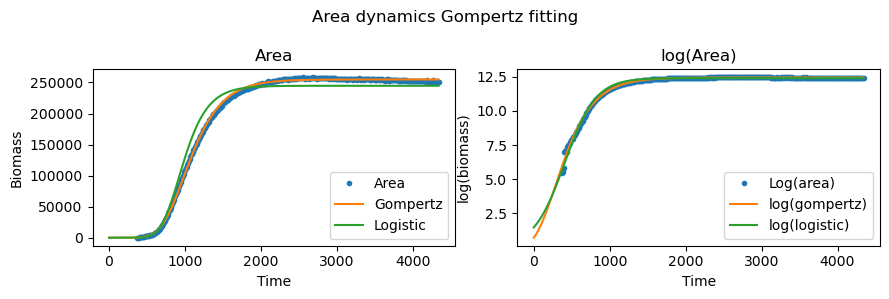

132
Gompertz Model:
  SSR: 3.5698
  R²: 0.9947
  AIC: -1870.1532
  BIC: -1858.1939

Logistic Model:
  SSR: 5.9379
  R²: 0.9911
  AIC: -1667.6315
  BIC: -1655.6721

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.26092982e+01 1.71773233e-02 2.53527911e+01]
Logistic params are: [1.25743871e+01 1.53649218e-02 2.09253136e-19]


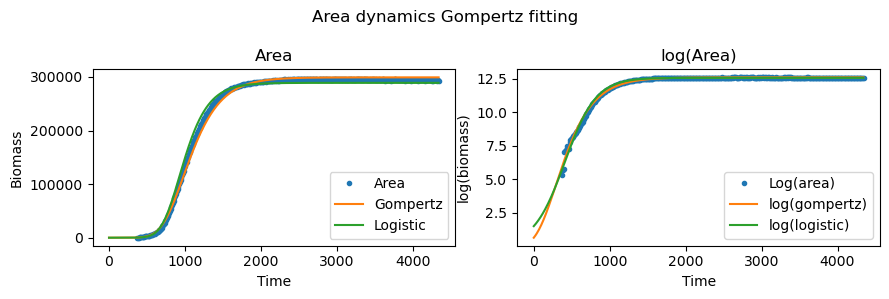

133
Gompertz Model:
  SSR: 2.8224
  R²: 0.9955
  AIC: -1963.6456
  BIC: -1951.6862

Logistic Model:
  SSR: 8.6015
  R²: 0.9863
  AIC: -1520.1358
  BIC: -1508.1764

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.29605371e+01 1.73833747e-02 7.89851676e-18]
Logistic params are: [1.29175911e+01 1.62039880e-02 2.00806332e-17]


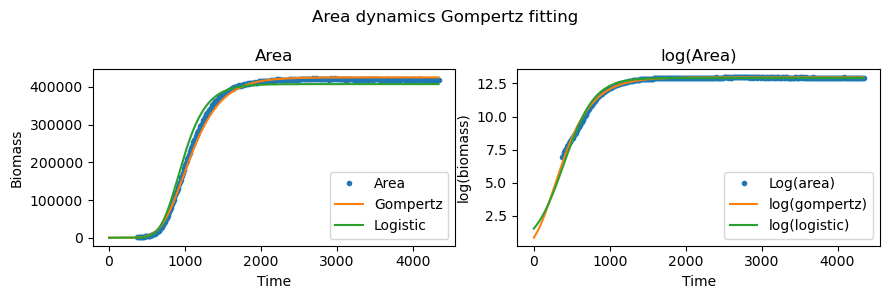

134
Gompertz Model:
  SSR: 3.1802
  R²: 0.9948
  AIC: -1916.1387
  BIC: -1904.1793

Logistic Model:
  SSR: 6.9739
  R²: 0.9886
  AIC: -1603.6236
  BIC: -1591.6643

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.29742575e+01 1.76537191e-02 3.81785212e-21]
Logistic params are: [1.29332700e+01 1.64347250e-02 2.02002851e-19]


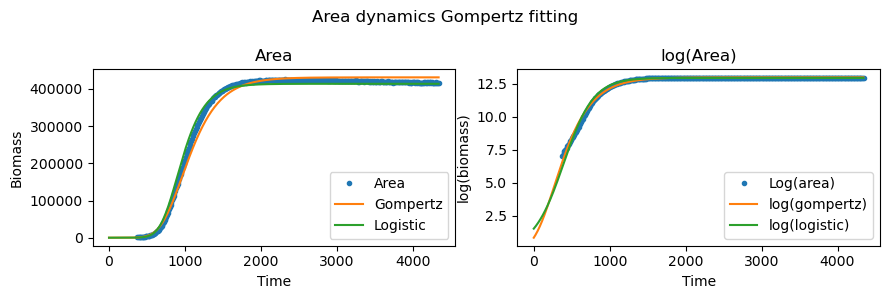

135
Gompertz Model:
  SSR: 0.8271
  R²: 0.9945
  AIC: -2452.1460
  BIC: -2440.1867

Logistic Model:
  SSR: 0.5379
  R²: 0.9964
  AIC: -2623.4055
  BIC: -2611.4461

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.21322247e+01 3.38769828e-02 1.36661791e+02]
Logistic params are: [1.21300790e+01 2.54357998e-02 6.48314188e+01]


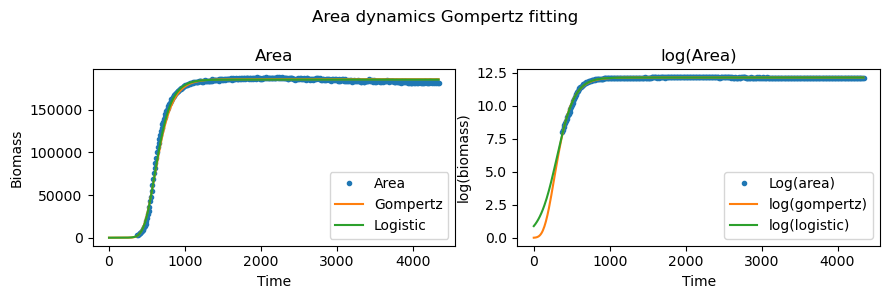

136
Gompertz Model:
  SSR: 0.2699
  R²: 0.9976
  AIC: -2964.2509
  BIC: -2952.2318

Logistic Model:
  SSR: 0.2276
  R²: 0.9980
  AIC: -3033.4743
  BIC: -3021.4553

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16161176e+01 3.45319670e-02 5.88050308e+01]
Logistic params are: [1.16127580e+01 2.65526965e-02 8.78031706e-17]


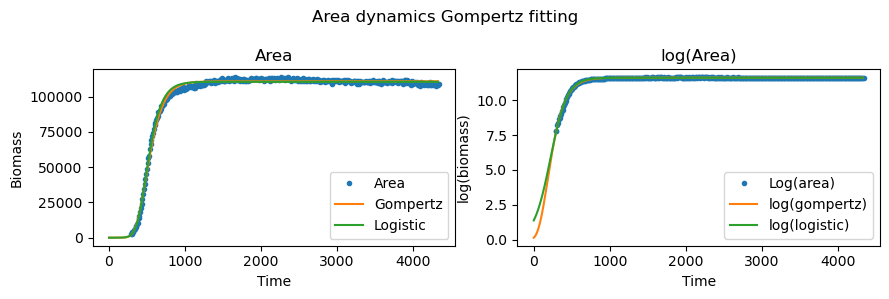

137
Gompertz Model:
  SSR: 0.2980
  R²: 0.9967
  AIC: -2924.0637
  BIC: -2912.0447

Logistic Model:
  SSR: 1.0362
  R²: 0.9886
  AIC: -2418.1372
  BIC: -2406.1182

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.52194568  0.03073889  8.18096369]
Logistic params are: [1.15109123e+01 2.72917783e-02 5.43269017e-17]


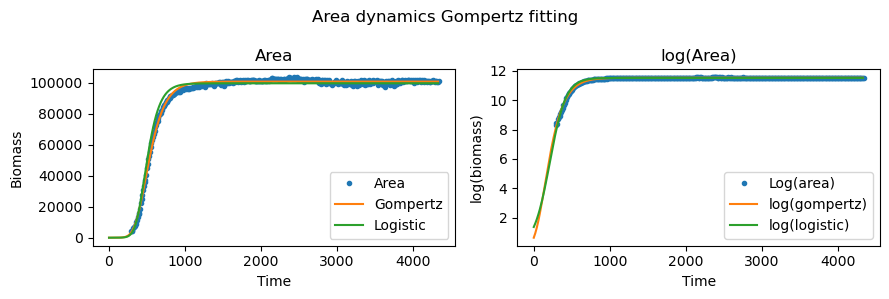

138
Gompertz Model:
  SSR: 0.4549
  R²: 0.9959
  AIC: -2752.4150
  BIC: -2740.3959

Logistic Model:
  SSR: 0.3845
  R²: 0.9965
  AIC: -2820.6811
  BIC: -2808.6621

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.16877470e+01 3.42448122e-02 5.14393833e+01]
Logistic params are: [1.16833269e+01 2.69035114e-02 8.20415341e-29]


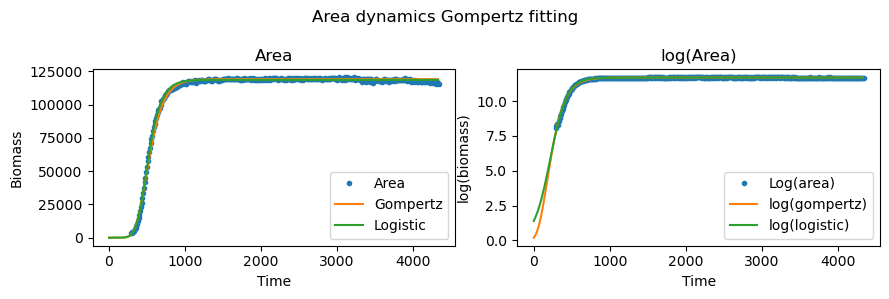

139
Gompertz Model:
  SSR: 0.4700
  R²: 0.9956
  AIC: -2739.1614
  BIC: -2727.1423

Logistic Model:
  SSR: 0.8312
  R²: 0.9923
  AIC: -2507.6186
  BIC: -2495.5995

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.78482256  0.03219937 25.61861141]
Logistic params are: [1.17761274e+01 2.72833667e-02 3.29542304e-18]


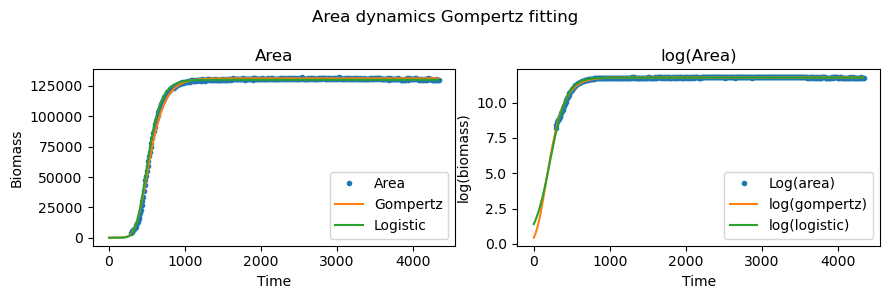

140
Gompertz Model:
  SSR: 0.9830
  R²: 0.9937
  AIC: -2439.5318
  BIC: -2427.5128

Logistic Model:
  SSR: 0.7011
  R²: 0.9955
  AIC: -2576.7373
  BIC: -2564.7183

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15663668e+01 3.18559628e-02 5.99871572e+01]
Logistic params are: [1.15625463e+01 2.46896107e-02 8.88951460e-18]


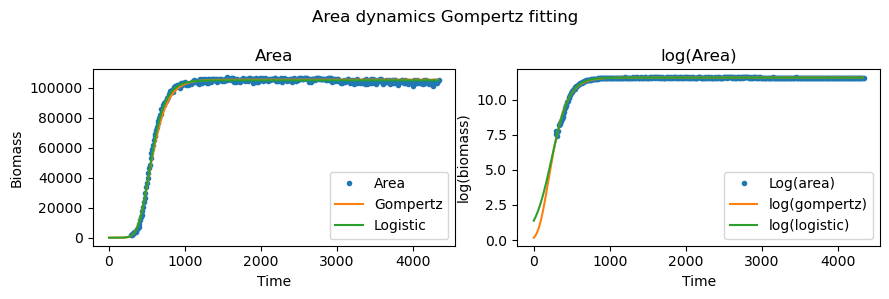

141
Gompertz Model:
  SSR: 0.6946
  R²: 0.9952
  AIC: -2580.5282
  BIC: -2568.5092

Logistic Model:
  SSR: 0.5458
  R²: 0.9962
  AIC: -2678.4399
  BIC: -2666.4209

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.15756611e+01 3.15141872e-02 5.02626490e+01]
Logistic params are: [1.15702078e+01 2.50880265e-02 9.77640497e-20]


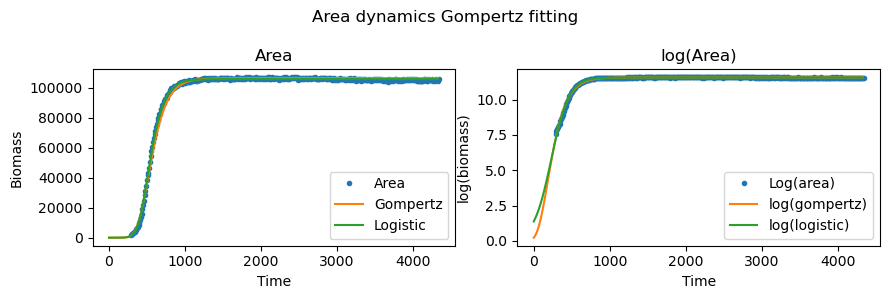

142
Gompertz Model:
  SSR: 0.2866
  R²: 0.9974
  AIC: -2939.9520
  BIC: -2927.9329

Logistic Model:
  SSR: 0.1744
  R²: 0.9984
  AIC: -3141.5135
  BIC: -3129.4945

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.22828785e+01 4.02737785e-02 7.59247739e+01]
Logistic params are: [12.28134486  0.02994087 10.86573651]


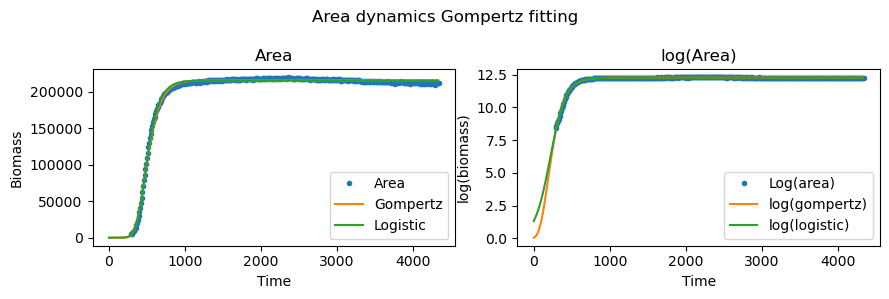

143
Gompertz Model:
  SSR: 0.2972
  R²: 0.9971
  AIC: -2925.1337
  BIC: -2913.1146

Logistic Model:
  SSR: 0.1766
  R²: 0.9983
  AIC: -3136.4156
  BIC: -3124.3966

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.20895505e+01 4.02486665e-02 7.72254468e+01]
Logistic params are: [12.08814621  0.02987345 12.55214122]


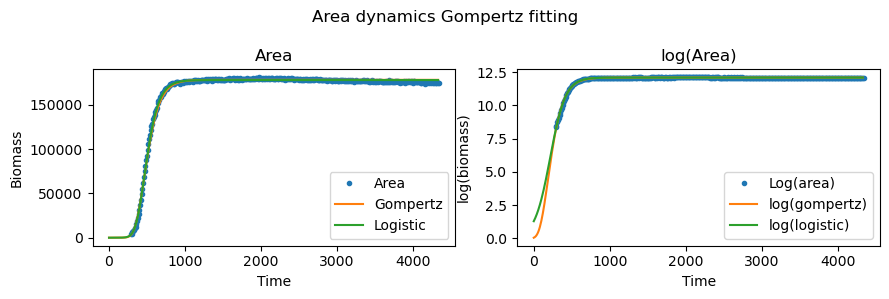

144
Gompertz Model:
  SSR: 0.5304
  R²: 0.9960
  AIC: -2690.0576
  BIC: -2678.0385

Logistic Model:
  SSR: 0.3399
  R²: 0.9974
  AIC: -2870.6674
  BIC: -2858.6484

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.18240562e+01 3.61725973e-02 7.40246756e+01]
Logistic params are: [11.82210251  0.02717231  8.57221214]


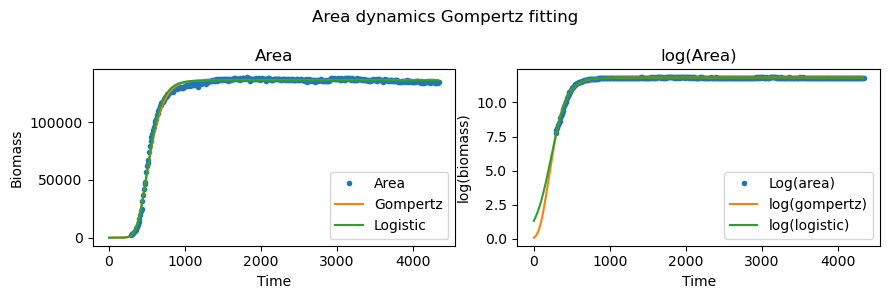

145
Gompertz Model:
  SSR: 5.1378
  R²: 0.9915
  AIC: -1768.1118
  BIC: -1756.0928

Logistic Model:
  SSR: 6.9459
  R²: 0.9885
  AIC: -1645.6897
  BIC: -1633.6706

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [12.11627051  0.01929522  7.17166078]
Logistic params are: [1.20865828e+01 1.77410573e-02 4.00510648e-13]


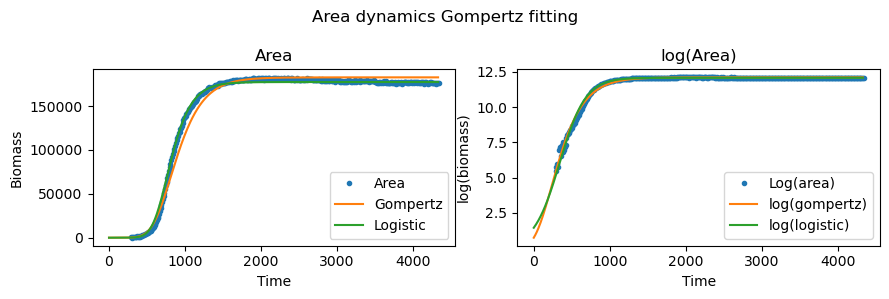

146
Gompertz Model:
  SSR: 18.8729
  R²: 0.9704
  AIC: -1231.7290
  BIC: -1219.7248

Logistic Model:
  SSR: 20.6483
  R²: 0.9676
  AIC: -1195.4084
  BIC: -1183.4041

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.12839070e+01 1.90749120e-02 7.33626688e+01]
Logistic params are: [1.12744811e+01 1.53276365e-02 4.20599012e-15]


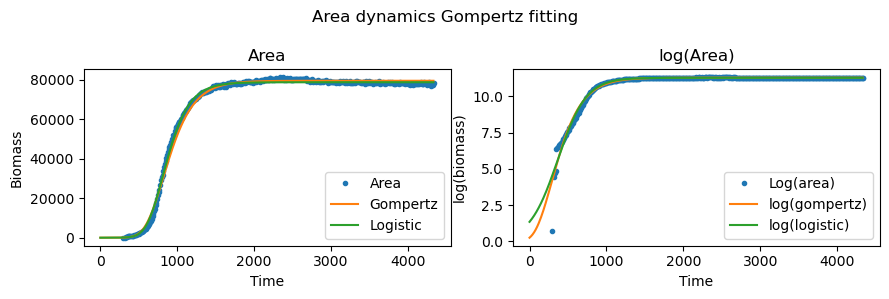

147
Gompertz Model:
  SSR: 9.3687
  R²: 0.9768
  AIC: -1514.6712
  BIC: -1502.6670

Logistic Model:
  SSR: 17.9493
  R²: 0.9555
  AIC: -1252.0016
  BIC: -1239.9974

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.09181591e+01 1.71523933e-02 3.10549147e-15]
Logistic params are: [1.08890132e+01 1.59698605e-02 3.32628902e-14]


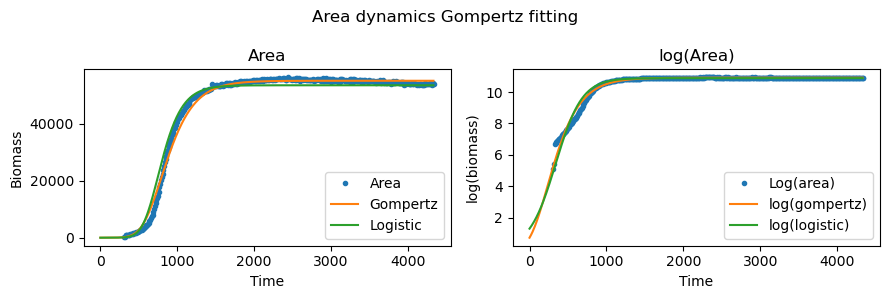

148
Gompertz Model:
  SSR: 16.6152
  R²: 0.9637
  AIC: -1291.5903
  BIC: -1279.5712

Logistic Model:
  SSR: 30.6090
  R²: 0.9331
  AIC: -1043.5340
  BIC: -1031.5149

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.09583477e+01 1.70536975e-02 1.56749390e-13]
Logistic params are: [1.09283762e+01 1.58918033e-02 2.70531336e-14]


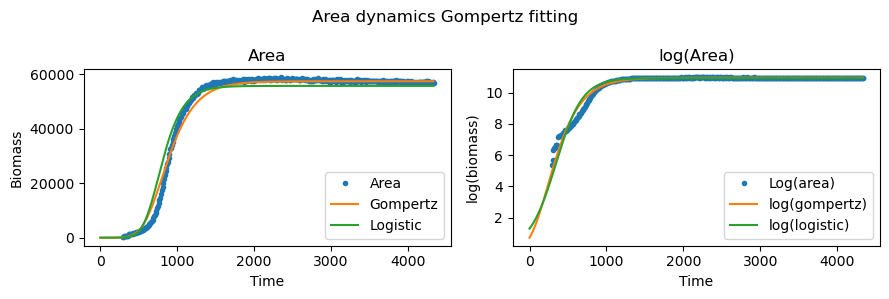

149
Gompertz Model:
  SSR: 2.0492
  R²: 0.9917
  AIC: -2016.0107
  BIC: -2004.1432

Logistic Model:
  SSR: 1.3762
  R²: 0.9945
  AIC: -2169.7003
  BIC: -2157.8328

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.12232295e+01 1.94951393e-02 1.43624836e+02]
Logistic params are: [1.12186097e+01 1.48632596e-02 3.86825752e+01]


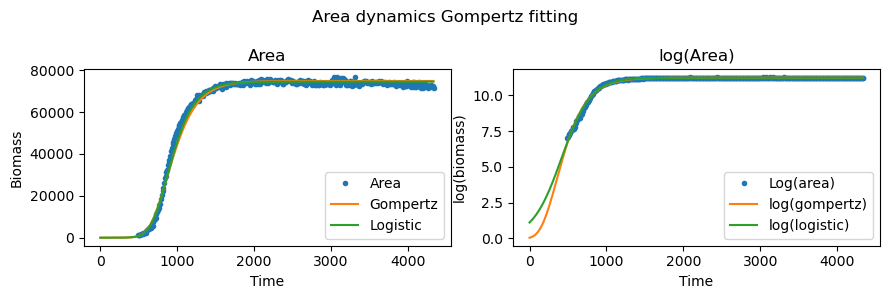

150
Gompertz Model:
  SSR: 5.0301
  R²: 0.9914
  AIC: -1776.7146
  BIC: -1764.6955

Logistic Model:
  SSR: 8.6230
  R²: 0.9853
  AIC: -1557.8774
  BIC: -1545.8584

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.13695553e+01 1.70162522e-02 2.28653401e-21]
Logistic params are: [1.13379524e+01 1.58747020e-02 8.52666526e-16]


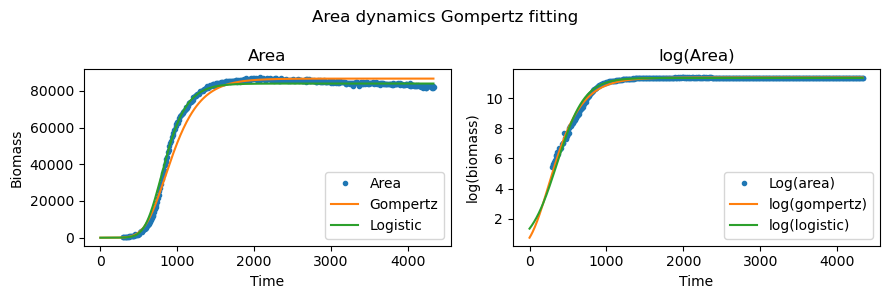

151
Gompertz Model:
  SSR: 7.6079
  R²: 0.9859
  AIC: -1608.7301
  BIC: -1596.7111

Logistic Model:
  SSR: 7.8338
  R²: 0.9855
  AIC: -1596.8481
  BIC: -1584.8290

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [11.71494965  0.01935458 15.05316175]
Logistic params are: [1.16909227e+01 1.74655576e-02 4.58681263e-17]


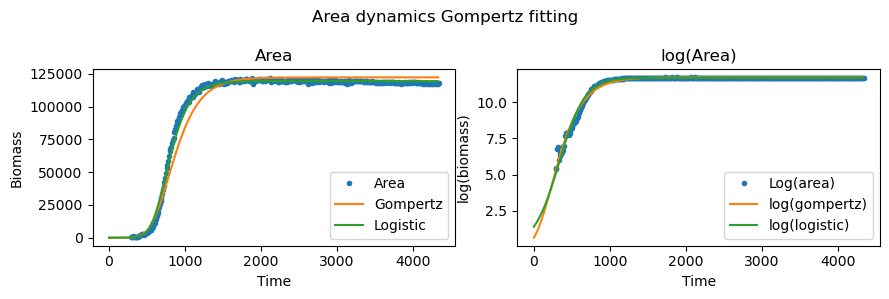

152
Gompertz Model:
  SSR: 7.6155
  R²: 0.9857
  AIC: -1598.3753
  BIC: -1586.3711

Logistic Model:
  SSR: 6.2849
  R²: 0.9882
  AIC: -1675.9609
  BIC: -1663.9566

The Logistic model is preferred based on AIC.
The Logistic model is preferred based on BIC.
Gompertz params are: [1.14821238e+01 1.97982416e-02 5.33375185e+01]
Logistic params are: [1.14687297e+01 1.65019646e-02 1.95724940e-15]


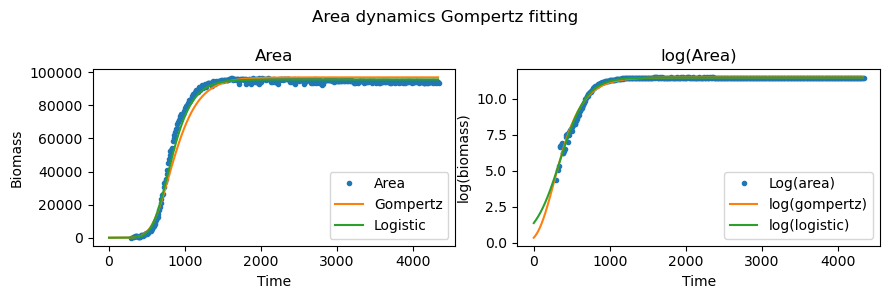

153
Gompertz Model:
  SSR: 28.5668
  R²: 0.9645
  AIC: -1056.9709
  BIC: -1044.9816

Logistic Model:
  SSR: 34.9140
  R²: 0.9566
  AIC: -976.3134
  BIC: -964.3240

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.14108140e+01 2.66127788e-02 2.06033954e+02]
Logistic params are: [1.14010475e+01 2.20414333e-02 1.65744188e+02]


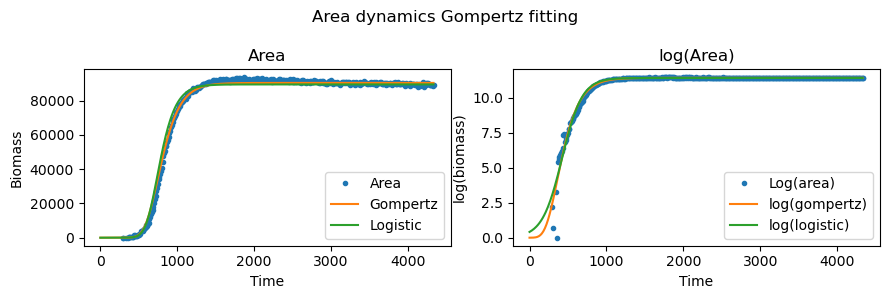

154
Gompertz Model:
  SSR: 3.0300
  R²: 0.9893
  AIC: -1982.4983
  BIC: -1970.4793

Logistic Model:
  SSR: 6.5292
  R²: 0.9769
  AIC: -1670.8104
  BIC: -1658.7913

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.13457962e+01 2.17598048e-02 9.40134990e-15]
Logistic params are: [1.13236864e+01 2.01556505e-02 8.72484261e-21]


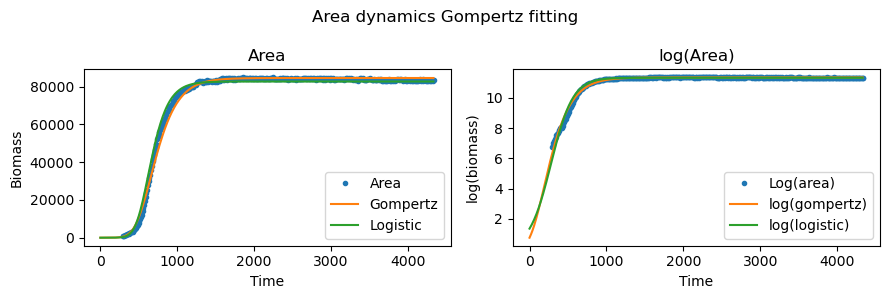

155
Gompertz Model:
  SSR: 2.6936
  R²: 0.9902
  AIC: -2030.2858
  BIC: -2018.2667

Logistic Model:
  SSR: 5.5735
  R²: 0.9797
  AIC: -1735.0647
  BIC: -1723.0456

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.14945113e+01 2.24632839e-02 1.95938408e-23]
Logistic params are: [1.14730251e+01 2.07836126e-02 2.87195256e-17]


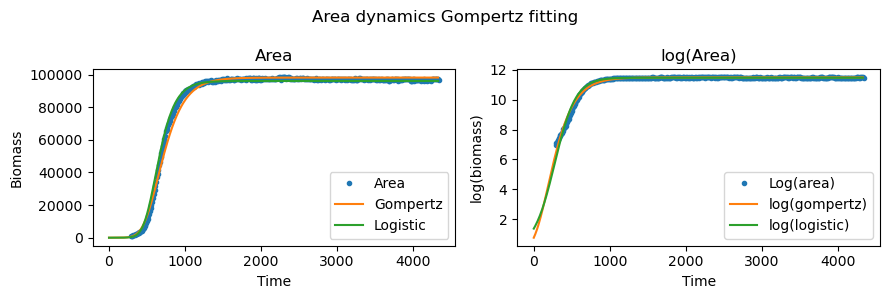

156
Gompertz Model:
  SSR: 3.0064
  R²: 0.9908
  AIC: -1985.6715
  BIC: -1973.6524

Logistic Model:
  SSR: 5.5940
  R²: 0.9829
  AIC: -1733.5695
  BIC: -1721.5504

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.15801217e+01 2.16001971e-02 1.04588848e-12]
Logistic params are: [1.15563980e+01 2.00401712e-02 1.52376016e-18]


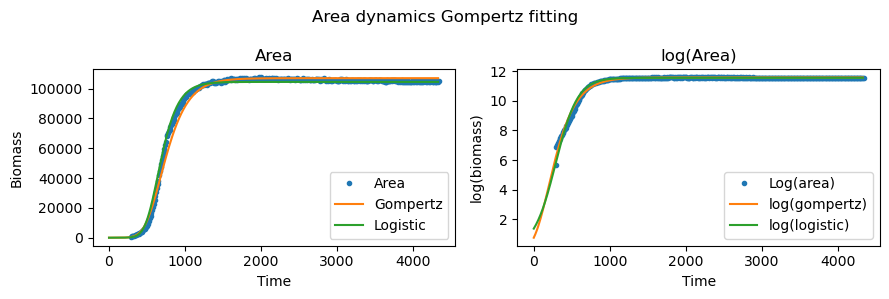

157
Gompertz Model:
  SSR: 0.5126
  R²: 0.9957
  AIC: -2703.9114
  BIC: -2691.8924

Logistic Model:
  SSR: 0.6267
  R²: 0.9947
  AIC: -2622.2718
  BIC: -2610.2528

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.16760438e+01 3.22175167e-02 3.77210093e+01]
Logistic params are: [1.16689903e+01 2.64437946e-02 3.24130747e-20]


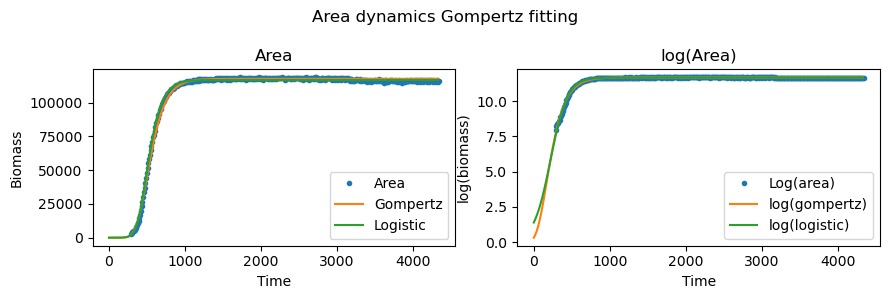

158
Gompertz Model:
  SSR: 10.7261
  R²: 0.9794
  AIC: -1469.2703
  BIC: -1457.2513

Logistic Model:
  SSR: 15.9930
  R²: 0.9693
  AIC: -1307.0856
  BIC: -1295.0665

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.15807246e+01 1.82468975e-02 1.07386526e-16]
Logistic params are: [1.15518657e+01 1.69764182e-02 2.37610282e-15]


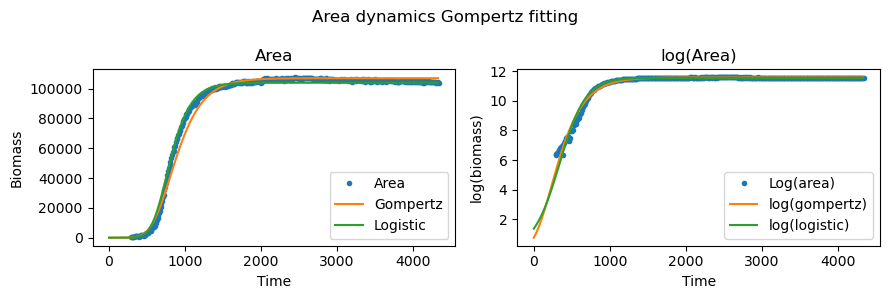

159
Gompertz Model:
  SSR: 36.5103
  R²: 0.8902
  AIC: -971.9558
  BIC: -959.9367

Logistic Model:
  SSR: 56.7964
  R²: 0.8292
  AIC: -792.5533
  BIC: -780.5342

The Gompertz model is preferred based on AIC.
The Gompertz model is preferred based on BIC.
Gompertz params are: [1.00479244e+01 1.61378129e-02 1.74191816e-13]
Logistic params are: [1.00196840e+01 1.50438943e-02 1.00158830e-13]


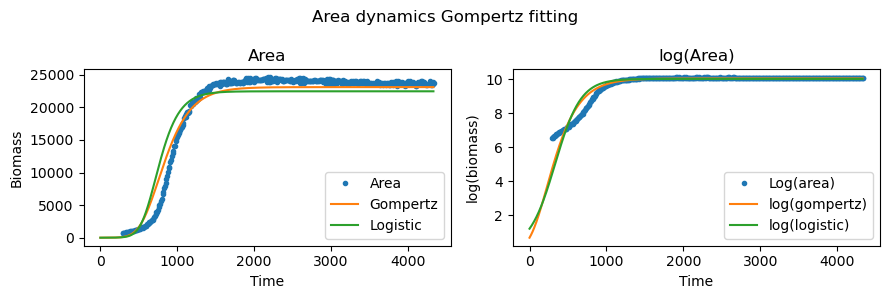

In [70]:
aic_gomp = 0
aic_log = 0
bic_gomp = 0
bic_log = 0

gomp_params = np.zeros((len(df.index.values),3))
log_params = np.zeros((len(df.index.values),3))

for i in df.index.values:
    print(i)
    # Fit the model
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60
    area = extract_array(df.loc[i,'area_px'])
    #area = extract_array(df.loc[i,'area_px']) * df.loc[i,'um_px']**2
    time_points = np.arange(0, df.loc[i, 'exp length'])*10 + incub_time_n

    # this is for positions i in [146,147,149,152,153] that contain area = 0 then log(a) = inf
    valid_indices = area > 0
    time_points = time_points[valid_indices]
    area = area[valid_indices]
    
    #p0_gomp=[area[-1], 200, incub_time_n]
    #p0_log=[np.log(area[-1]), 0.1, incub_time_n]

    p0_gomp=[np.log(area[-1]), 0.02, 300]
    p0_log=[np.log(area[-1]), 0.02, 300]

    # Fit both models   
    ## gomp
    bounds_gomp = ([0, 0, 0], [np.inf, np.inf, np.inf])
    bounds_log = ([0, 0, 0], [np.inf, np.inf, np.inf])
    
    #try:
    params_gompertz, cov_gompertz = curve_fit(gompertz, time_points, np.log(area), p0_gomp, bounds=bounds_gomp, maxfev=10000)
    #except:
    #    idx = np.where(np.isfinite(np.log(area)))[0]
    #    params_gompertz, cov_gompertz = curve_fit(gompertz, time_points[idx], np.log(area)[idx], p0_gomp, bounds=bounds_gomp, maxfev = 10000)#, bounds=([1, 0, 0], [np.inf, np.inf, np.inf]), max_nfev=10000)
    
    ## logistic
    #try:
    params_logistic, cov_logistic = curve_fit(logistic, time_points, np.log(area), p0_log, bounds=bounds_log, maxfev=10000)     
    #except:
    #    idx = np.where(np.isfinite(np.log(area)))[0]
    #    params_logistic, cov_logistic = curve_fit(logistic, time_points[idx], np.log(area)[idx], p0_log, bounds=bounds_log, maxfev=10000)#, bounds=([1, 0, 0], [np.inf, np.inf, np.inf]), max_nfev=10000)

    gomp_params[i,:] = params_gompertz
    log_params[i,:] = params_logistic
    
     # Calculate predicted values
    pred_gompertz = gompertz(time_points, *params_gompertz)
    pred_logistic = logistic(time_points, *params_logistic)
    
    # Calculate residuals
    residuals_gompertz = np.log(area) - pred_gompertz
    residuals_logistic = np.log(area) - pred_logistic
    
    # Calculate SSR (Sum of Squared Residuals)
    ssr_gompertz = np.sum(residuals_gompertz**2)
    ssr_logistic = np.sum(residuals_logistic**2)
    
    # Calculate R²
    r2_gompertz = r2_score(np.log(area), pred_gompertz)
    r2_logistic = r2_score(np.log(area), pred_logistic)
    
    # Calculate AIC
    n = len(area)
    aic_gompertz = n * np.log(ssr_gompertz/n) + 2 * len(params_gompertz)
    aic_logistic = n * np.log(ssr_logistic/n) + 2 * len(params_logistic)
    
    # Calculate BIC
    bic_gompertz = n * np.log(ssr_gompertz/n) + len(params_gompertz) * np.log(n)
    bic_logistic = n * np.log(ssr_logistic/n) + len(params_logistic) * np.log(n)
    
    # Print results
    print("Gompertz Model:")
    print(f"  SSR: {ssr_gompertz:.4f}")
    print(f"  R²: {r2_gompertz:.4f}")
    print(f"  AIC: {aic_gompertz:.4f}")
    print(f"  BIC: {bic_gompertz:.4f}")
    
    print("\nLogistic Model:")
    print(f"  SSR: {ssr_logistic:.4f}")
    print(f"  R²: {r2_logistic:.4f}")
    print(f"  AIC: {aic_logistic:.4f}")
    print(f"  BIC: {bic_logistic:.4f}")
    
    # Determine which model is better
    if aic_gompertz < aic_logistic:
        print("\nThe Gompertz model is preferred based on AIC.")
        aic_gomp = aic_gomp + 1
        
    else:
        print("\nThe Logistic model is preferred based on AIC.")
        aic_log = aic_log + 1
    
    if bic_gompertz < bic_logistic:
        print("The Gompertz model is preferred based on BIC.")
        bic_gomp = bic_gomp + 1
        
    else:
        print("The Logistic model is preferred based on BIC.")
        bic_log = bic_log + 1

    print(f"Gompertz params are: {params_gompertz}")
    print(f"Logistic params are: {params_logistic}")

    ## store fitting results in data_processed file
    pars_gomp_dict = {'A': params_gompertz[0], 'mu_m': params_gompertz[1], 'lambda': params_gompertz[2]}
    pars_log_dict = {'A': params_logistic[0], 'mu_m': params_logistic[1], 'lambda': params_logistic[2]}
    df.at[i, 'gompertz_params_px'] = json.dumps(pars_gomp_dict)
    df.at[i, 'logistic_params_px'] = json.dumps(pars_log_dict)

    time = np.arange(0, time_points[-1], 10, like=time_points)
    #params = list(json.loads(df.loc[i,'logistic_params']).values())
    #params_gomp = list(json.loads(df.loc[i,'gomp_params']).values())
    
    gompertz_full = gompertz(time, *params_gompertz)
    logistic_full = logistic(time, *params_logistic)

    # create subplots
    fig, axes = plt.subplots(1, 2, figsize=(9,3))

    # plot data
    axes[0].plot(time_points, area, '.', label='Area')
    axes[0].plot(time, np.exp(gompertz_full), label='Gompertz')
    axes[0].plot(time, np.exp(logistic_full), label='Logistic')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Biomass')
    axes[0].set_title('Area')
    axes[0].legend()

    # log area
    axes[1].plot(time_points, np.log(area), '.', label='Log(area)')
    axes[1].plot(time, gompertz_full, label='log(gompertz)')
    axes[1].plot(time, logistic_full, label='log(logistic)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('log(biomass)')
    axes[1].set_title('log(Area)')
    axes[1].legend()
    
    plt.suptitle('Area dynamics Gompertz fitting')
    plt.tight_layout()
    plt.show()

In [71]:
df.to_excel('../data_processed.xlsx', index=False)

In [64]:
aic_gomp

89

In [65]:
bic_gomp

89

In [73]:
df = pd.read_excel('../data_processed.xlsx')

##### $\mu m$ fitting vs pixels

In [74]:
gomp_params_px = np.zeros((160,3))
gomp_params_um = np.zeros((160,3))
log_params_px = np.zeros((160,3))
log_params_um = np.zeros((160,3))
for i in df.index.values:
    gomp_px = json.loads(df.loc[i,'gompertz_params_px'])
    gomp_params_px[i,0] = gomp_px['A']
    gomp_params_px[i,1] = gomp_px['mu_m']
    gomp_params_px[i,2] = gomp_px['lambda']

    gomp_um = json.loads(df.loc[i,'gompertz_params_um'])
    gomp_params_um[i,0] = gomp_um['A']
    gomp_params_um[i,1] = gomp_um['mu_m']
    gomp_params_um[i,2] = gomp_um['lambda']

    log_px = json.loads(df.loc[i,'logistic_params_px'])
    log_params_px[i,0] = log_px['A']
    log_params_px[i,1] = log_px['mu_m']
    log_params_px[i,2] = log_px['lambda']

    log_um = json.loads(df.loc[i,'logistic_params_um'])
    log_params_um[i,0] = log_um['A']
    log_params_um[i,1] = log_um['mu_m']
    log_params_um[i,2] = log_um['lambda']

In [76]:
np.linalg.norm(gomp_params_px-gomp_params_um)

104.30034842750784

In [78]:
np.linalg.norm(log_params_px-log_params_um)

72.13079962277197

#### Computing t_m $\mu m$ & pixels

In [ ]:
df = pd.read_excel('../data_processed.xlsx')

In [81]:
for i in df.index.values:
    pars_gomp_px = json.loads(df.loc[i,'gompertz_params_px'])
    t_m_gomp_px = tm_gomp(pars_gomp_px['A'], pars_gomp_px['mu_m'], pars_gomp_px['lambda'])
    
    pars_gomp_um = json.loads(df.loc[i,'gompertz_params_um'])
    t_m_gomp_um = tm_gomp(pars_gomp_um['A'], pars_gomp_um['mu_m'], pars_gomp_um['lambda'])
    
    pars_logistic_px = json.loads(df.loc[i,'logistic_params_px'])
    t_m_logistic_px = tm_logistic(pars_logistic_px['A'], pars_logistic_px['mu_m'], pars_logistic_px['lambda'])

    pars_logistic_um = json.loads(df.loc[i,'logistic_params_um'])
    t_m_logistic_um = tm_logistic(pars_logistic_um['A'], pars_logistic_um['mu_m'], pars_logistic_um['lambda'])

    df.at[i, 't_m_gomp_px'] = t_m_gomp_px
    df.at[i, 't_m_gomp_um'] = t_m_gomp_um
    
    df.at[i, 't_m_logistic_px'] = t_m_logistic_px
    df.at[i, 't_m_logistic_um'] = t_m_logistic_um
    
    print(f'Colony: {i}, tm_gomp_px: {t_m_gomp_px}, tm_gomp_um: {t_m_gomp_um}, t_m_logistic_px: {t_m_logistic_px}, t_m_logistic_um: {t_m_logistic_um}')

Colony: 0, tm_gomp_px: 196.23390190126986, tm_gomp_um: 192.65225688597317, t_m_logistic_px: 225.21958209332928, t_m_logistic_um: 222.19259582024122
Colony: 1, tm_gomp_px: 189.07135430439905, tm_gomp_um: 185.7591507961924, t_m_logistic_px: 216.25472701733372, t_m_logistic_um: 214.61629572251323
Colony: 2, tm_gomp_px: 180.60896841221168, tm_gomp_um: 177.38356352842527, t_m_logistic_px: 209.42839534555003, t_m_logistic_um: 207.88246671221057
Colony: 3, tm_gomp_px: 151.43910459139005, tm_gomp_um: 148.04561552453396, t_m_logistic_px: 199.9044225215117, t_m_logistic_um: 198.4369910456967
Colony: 4, tm_gomp_px: 186.95402049153427, tm_gomp_um: 183.77360312790168, t_m_logistic_px: 211.5737186855637, t_m_logistic_um: 208.80417399643457
Colony: 5, tm_gomp_px: 192.85300674166376, tm_gomp_um: 189.48087275377455, t_m_logistic_px: 219.23741818804282, t_m_logistic_um: 215.5179005553303
Colony: 6, tm_gomp_px: 182.81373011206642, tm_gomp_um: 178.0506429186527, t_m_logistic_px: 241.7055522502598, t_m_log

In [82]:
df.to_excel('../data_processed.xlsx', index=False)

### Growth rate

In [23]:
df = pd.read_excel('../data_processed.xlsx')

In [ ]:
for pos in df.index.values:
    df_pos = df.loc[pos,:]
    print(f"Date: {df_pos['Date']}, Machine: {df_pos['Machine']}, Position: {df_pos['Position']}")
    gparams = json.loads(df_pos['gompertz_params_um'])
    lparams = json.loads(df_pos['logistic_params_um'])
    
    gA = gparams['A']
    gmu = gparams['mu_m']
    gl = gparams['lambda']
    lA = lparams['A']
    lmu = lparams['mu_m']
    ll = lparams['lambda']
    
    idx = pos
    area = extract_array(df.loc[idx,'area'])
    incub_time_s = datetime.strptime(df.loc[idx,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[idx,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60
    time_points = np.arange(0, df.loc[idx, 'exp length'])*10 + incub_time_n
    t = np.arange(0, time_points[-1]+1, 10)

    gg = gompertz(t,gA,gmu,gl)
    lg = logistic(t,lA,lmu,ll)
    plt.plot(t,np.exp(gg), label='Gompertz')
    plt.plot(t,np.exp(lg), label='Logistic')
    plt.plot(time_points,area, label='Area')
    plt.legend()
    plt.show()

    ggr = gompertz_growth_rate(t,gA,gmu,gl)
    lgr = logistic_growth_rate(t,lA,lmu,ll)
    
    rel_a = savgol_filter(np.log(area), 21, 3, deriv=1) / 10# / savgol_filter(np.log(area), 21, 3), delta t
    
    plt.plot(t, ggr, label='Gompertz')
    plt.plot(t, lgr, label='Logistic')
    #plt.plot(time_points, ggr[(len(ggr)-len(area)):] / np.log(area), label='Gompertz')
    #plt.plot(time_points, lgr[(len(lgr)-len(area)):] / np.log(area), label='Logistic')
    plt.plot(time_points, rel_a, label='1/log(A) dlog(A)/dt')
    #plt.plot(time_points,area, label='Area')
    plt.legend()
    plt.show()